 # Совместный хакатон Яндекс.Практикума и R1


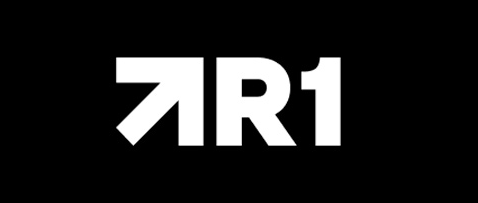

**Цель этого проекта** - разработка модели склонности (бинарной классификации) к покупке клиентом оборудования после коммуникации с ним в одном из каналов.

Датасет собран для случайного множества клиентов ('id' – идентификатор клиента), с которыми была попытка коммуникации в одном из каналов ('channel_name'). Целевая переменная ('target') равна единице, если после коммуникации с клиентом была продажа
оборудования и нулю если нет.
Поле 'period' соответствует месяцу сбора признаков на клиента. Лаг между датой коммуникации и сборкой признаков на клиента: 2 месяца, поэтому, если коммуникация была в марте (любой день), то признаки на клиента собирались на 31 января.

**Признаки**

Для каждой пары 'id' + 'period' собрано более 2500 признаков. Названия признаков интерпретируются следующим образом: 

*<модуль><номер признака><глубина агрегации>_<тип>*

Если признак построен как агрегат (например сумма за период), то указывается <глубина агрегации> в месяцах, в противном случае ставится 0. Также, в качестве <глубина агрегации> может быть запись вида '3d6', что указывает на отношение агрегата за 3 месяца к агрегату за 6 месяцев.

Различные типы признаков (<тип>) описаны ниже:

 - *flg* - флаг (значение 1 или 0)
 - *ctg* - категориальный признак
 - *num* - числовой признак
 - *dt* - дата
 - *cnt* - количество
 - *sum* - сумма
 - *avg* - среднее
 - *sumpct* - персентиль по сумме
 - *part* - доля

В файле features_types.json дополнительно записан словарь, где для каждой фичи в соответствие ставится тип из списка (numeric, categorical_int, categorical_string).

In [1]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gc
import json
import re
import os

import shap
import scipy.stats as ss
from statsmodels.stats.stattools import medcouple

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

import optuna
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from tqdm import notebook, tqdm

import phik
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

RANDOM_SEED = 12345
np.random.seed(RANDOM_SEED)
path = os.path.abspath(os.curdir)

## Обработка данных и получение признаков

<div style="border:solid green 2px; padding: 20px">
    
*Этот этап потребует значительных ресурсов cpu. Если компьютер слабый, рекомендуется сразу перейти к этапу "Первичное обучение"*

Для начала переберем все столбцы в данных и изменим тип данных чтобы уменьшить использование памяти.

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif 'datetime' not in col_type.name:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    
    return df

In [3]:
parquet_file = pq.ParquetFile(os.path.join(path, 'dataset_train.parquet'))

In [4]:
def read_parquet_file(parquet_file):
    df = pd.DataFrame()
    for i in tqdm(parquet_file.iter_batches(batch_size=1000)):
        data = reduce_mem_usage(i.to_pandas())
        df = pd.concat([df, data], ignore_index=True)
    return df

In [5]:
%%time
df = read_parquet_file(parquet_file)

del parquet_file

В данных присутствуют колонки, где всего одно или два значения. Например, с одинаковыми значениями и одним отличным от остальной выборки, значением-выбросом. Колонки, где пропусков более нескольких десятков тысяч. Удалим их.

In [6]:
# колонки с единственным значением
cols_1_item = []
for col in df.columns:
    if len(df[col].value_counts()) == 1:
        cols_1_item.append(col)

df = df.drop(cols_1_item, axis=1)

In [7]:
# колонки с двумя значениями 
cols_2_item = []
for col in df.columns:
    if len(df[col].value_counts()) == 2:
        cols_2_item.append(col)

# некоторые колонки с 2-мя значениями удалять не будем
cols_to_remove = ["target", "user_lifetime_1_1_flg", "social_dem_0_0_flg", "scheme_types_4_1_flg", "autopay_1_1_flg", "social_dem_1_0_flg"]
cols_2_item = [i for i in cols_2_item if i not in cols_to_remove]

df = df.drop(cols_2_item, axis=1)

In [8]:
# колонки, где пропусков больше 70000
cols_isna = df.columns[df.isna().sum() > 70000]

df = df.drop(cols_isna, axis=1)

del cols_1_item, cols_2_item, cols_isna
gc.collect()

In [9]:
df.to_pickle(os.path.join(path, 'train_data_temp'), compression="zip")

In [10]:
df = pd.read_pickle(os.path.join(path, 'train_data_temp'), compression="zip")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Columns: 1904 entries, id to communication_availability_69_1_flg
dtypes: float16(1731), int16(10), int32(8), int8(153), object(2)
memory usage: 2.4+ GB


Еще нам потребуется выделить принадлежность признаков.

In [12]:
pattern = r'_[0-9]+[A-Za-z0-9_]+'
names = []
for name in df.columns:
    if name not in ['id', 'period', 'target', 'channel_name']:
        name = re.sub(pattern, '', name)
        names.append(name)
names = sorted(list(set(names)))

Приступим к отбору признаков. Выбор будем производить используя встроенные методы sklearn, основанные на отборе по критерию хи-квадрат, измеряющий зависимость между случайными переменными - отсеиваются признаки, которые с наибольшой вероятностью не зависят от класса.

In [13]:
# функция отбора признаков 
def featureSelect_dataframe(X, target, criteria, k, column):
    
    cols_len = len(X.columns)
    
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
    imp_mean.fit(X)
    temp_df = imp_mean.transform(X)
    
    scaler = MinMaxScaler()
    scaler.fit(temp_df)
    temp_df = scaler.fit_transform(temp_df)
    
    if cols_len < k:
        reg = SelectKBest(criteria, k='all').fit(temp_df, target)
    else:
        reg = SelectKBest(criteria, k=k).fit(temp_df, target)
    
    X_transformed = reg.transform(temp_df)
    X = X[[val for i,val in enumerate(X.columns) if reg.get_support()[i]]]

    cols = X.columns.to_list()
    
    del temp_df
    return cols

In [14]:
# выбор признаков для всего таргета
final_features = []

for name in tqdm(names):
    temp_lst = [col for col in df.columns if name in col and name not in ['period', 'channel_name']]
    temp_df = df[temp_lst]
    lst = featureSelect_dataframe(temp_df, df['target'], chi2, 2, name)
    final_features.extend(lst)
    del temp_df
    gc.collect()
    
final_features.extend(['period', 'channel_name'])
print('Length final_features:', len(final_features))

del df
gc.collect()

100%|██████████| 32/32 [08:46<00:00, 16.47s/it]


Length final_features: 60


0

<div style="border:solid green 2px; padding: 20px">
    
*Если компьютер обладает недостаточной оперативной памятью, запуск кода можно начать с этого этапа. Отобранные ранее программой фичи вынесены в список final_features (см. ниже)*

## Первичное обучение моделей

In [15]:
final_features

['agreement_type_0_0_ctg',
 'area_1_0_ctg',
 'arpu_1_3_avg',
 'arpu_2_6_avg',
 'autopay_8_0_ctg',
 'autopay_3_1_flg',
 'balance_details_0_1_num',
 'basic_info_1_0_max',
 'basic_info_2_0_min',
 'campaigns_92_3_part',
 'campaigns_93_6_part',
 'charges_details_13_3_avg',
 'charges_details_14_6_avg',
 'cities_1_0_ctg',
 'cities_2_0_ctg',
 'communication_availability_17_1_flg',
 'communication_availability_30_1_flg',
 'deact_react_7_1_ctg',
 'deact_react_10_1_ctg',
 'exist_tariff_0_1_flg',
 'exist_tariff_2_1_flg',
 'info_house_6_0_num',
 'info_house_9_0_flg',
 'markers_567_1_cnt',
 'markers_706_1_cnt',
 'materials_details_10_1_flg',
 'materials_details_20_1_flg',
 'migrant_0_1_flg',
 'overdue_payments_0_1_cnt',
 'payments_details_27_1_sumpct',
 'payments_details_29_6_sumpct',
 'plan_costs_2_6_avg',
 'plan_costs_5_6_avg',
 'scheme_types_0_1_flg',
 'scheme_types_2_1_flg',
 'social_dem_1_0_flg',
 'social_dem_4_0_flg',
 'spas_symptoms_agr_13_1_sum',
 'spas_symptoms_agr_16_3_sum',
 'spas_symptom

Прежде чем взять данные в работу разделим их на категориальные и числовые признаки.

In [4]:
description_features_path = os.path.join(path, 'features_types.json')
description_features = json.load(open(description_features_path))

description_features['period']='numeric'
description_features['channel_name']='categorical'
description_features['target']='-'
categorial_features = [column for column in final_features if 'categorical' in description_features[column]]
numerical_features = [column for column in final_features if 'numeric' in description_features[column]]

Итак, у нас есть все для работы:
 - Загрузим информацию из витрины с данными по требуемым нам колонкам
 - Заменим пропуски с колонками, где значение таргета равно 1 на нули
 - Получим столбцы, по токорым количество пропусков превышает заданный порог
 - Удалим данные по отобранным параметрам
 - Трансформируем колонки при необходимости
 - Разделим выборки

In [5]:
list_features = final_features.copy()

In [6]:
def get_datasets(list_features, mode=None):

    df = pd.read_parquet(os.path.join(path, 'dataset_train.parquet'), columns=list_features)
    test = pd.read_parquet(os.path.join(path, 'features_oot.parquet'), columns=list_features)
    target = pd.read_parquet(os.path.join(path, 'dataset_train.parquet'), columns=['target'])
    data = pd.read_parquet(os.path.join(path, 'dataset_train.parquet'), columns=list_features + ['target'])

    df.channel_name = df.channel_name.astype('int32')
    test.channel_name = test.channel_name.astype('int32')
    data.channel_name = data.channel_name.astype('int32')

    index_target = target.loc[target['target'] == 1].index
    df.iloc[index_target] = df.iloc[index_target].fillna(0)

    dff = df.isna().sum().to_frame()
    columns_drop = list(dff.loc[dff[0] > 70000].index)
    inds = []

    for column in df.columns:
        if column not in columns_drop:
            inds.extend(list(df.loc[df[column].isna()].index))
    inds = list(set(inds))
    df = df.drop(index=inds, columns=columns_drop)
    test = test.drop(columns=columns_drop)
    target = target.drop(index=inds)

    if mode is not None:
        df = preprocessing(df)
        test = preprocessing(test)

    features_train, features_test, target_train, target_test = train_test_split(
        df, target, stratify=target, test_size=0.25, random_state=RANDOM_SEED)

    return features_train, features_test, target_train, target_test, data, test

In [7]:
features_train, features_test, target_train, target_test, data, test = get_datasets(final_features)

В качестве моделей будем использовать:
 - CatBoostClassifier
 - LGBMClassifier
 - XGBClassifier

<div style="border:solid green 2px; padding: 20px">
    
*Все параметры для моделей были подобраны на optuna. Приведенный здесь код с диапазонами носит ознакомительный характер.*

In [20]:
list_model = []

param_distrs = {
                'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.2),
                'min_data_in_leaf':optuna.distributions.IntDistribution(1,8),
                'depth': optuna.distributions.IntDistribution(5,10),
                'l2_leaf_reg': optuna.distributions.FloatDistribution(0.1,95.),
                }

clf = CatBoostClassifier(verbose=False, random_seed=RANDOM_SEED)
opt_search = optuna.integration.OptunaSearchCV(clf, param_distrs, cv = 3,
                                                n_trials=50, scoring='roc_auc', timeout=500)
opt_search.fit(features_train, target_train)

list_model.append(opt_search.best_estimator_)

param_distrs = {
                'learning_rate': optuna.distributions.FloatDistribution(0.01, 0.2),
                'max_depth': optuna.distributions.IntDistribution(5,10),
                'alpha': optuna.distributions.IntDistribution(5,10),
                'max_leaves': optuna.distributions.IntDistribution(5,10),
                'gamma': optuna.distributions.FloatDistribution(0.01, 0.2),
                'scale_pos_weight': optuna.distributions.IntDistribution(1,100)
                }

lgb = lgb.LGBMClassifier(random_state=RANDOM_SEED, verbose= -1, metric='auc',
            boosting_type='gbdt', n_estimators=1000)
opt_search = optuna.integration.OptunaSearchCV(lgb, param_distrs, cv = 3,
                                                n_trials=50, scoring='roc_auc', timeout=500)
opt_search.fit(features_train, target_train)

list_model.append(opt_search.best_estimator_)

param_distrs = {
                'learning_rate': optuna.distributions.FloatDistribution(0.01, 0.2),
                'max_depth': optuna.distributions.IntDistribution(5,10),
                'alpha': optuna.distributions.IntDistribution(5,10),
                'max_leaves': optuna.distributions.IntDistribution(5,10),
                'gamma': optuna.distributions.FloatDistribution(0.01, 0.2),
                'scale_pos_weight': optuna.distributions.IntDistribution(1,100)
                }

xg = xgb.XGBClassifier(random_state=RANDOM_SEED)
opt_search = optuna.integration.OptunaSearchCV(xg, param_distrs, cv = 3,
                                                n_trials=50, scoring='roc_auc', timeout=500)
opt_search.fit(features_train, target_train)

list_model.append(opt_search.best_estimator_)

Еще нам пригодится функция, которые рассчитывает заданные метрики roc-auc и gini. Кроме этого нам потребуется матрица ошибок и отчет по классификации. Прогноз по единицам получим из расчета вероятности - все, что выше порога в 0,8 приравнивается к положительному классу.

In [8]:
#получить метрики
def show_metric(model, X, y):
    probabilities = model.predict_proba(X)[:,1]
    roc_auc = roc_auc_score(y, probabilities)
    gini = roc_auc*2-1
    list_metrics.append([model.__class__.__name__, roc_auc, gini, model])
    pred = np.where(probabilities>0.8, 1,0)
    print(classification_report(y, pred))

    cf_matrix = confusion_matrix(np.array(y), np.array(pred))
    plt.figure(figsize=(4, 4))
    plt.title(f'Confusion_matrix {model.__class__.__name__}')
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    lbls = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    lbls = np.asarray(lbls).reshape(2,2)
    sns.heatmap(cf_matrix, annot=lbls, fmt='', cmap='Set3')
    plt.show()

In [9]:
#модели, с подобранными ранее параметрами
models = [
    CatBoostClassifier(random_seed=RANDOM_SEED, eval_metric='AUC',metric_period=1000, learning_rate = 0.037, 
                       depth=5, l2_leaf_reg=9.337230928976561, min_data_in_leaf=6), #
    lgb.LGBMClassifier(random_state=RANDOM_SEED, learning_rate=0.01, verbose= -1, metric='auc',
            boosting_type='gbdt', max_depth=9, n_estimators=1000),
    xgb.XGBClassifier(random_state=RANDOM_SEED, eval_metric='auc', reg_lambda=8, alpha=6, scale_pos_weight=3,
              learning_rate=0.0930551830163883, max_depth=6, max_leaves=8, gamma = 0.0885573260155167)
]

Настало время получить метрики

0:	total: 174ms	remaining: 2m 53s
999:	total: 20.7s	remaining: 0us
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    152422
           1       1.00      0.07      0.13      1367

    accuracy                           0.99    153789
   macro avg       1.00      0.53      0.56    153789
weighted avg       0.99      0.99      0.99    153789



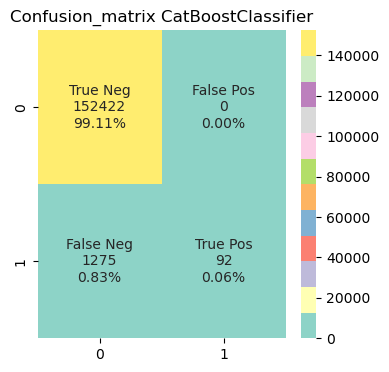

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    152422
           1       1.00      0.06      0.11      1367

    accuracy                           0.99    153789
   macro avg       1.00      0.53      0.55    153789
weighted avg       0.99      0.99      0.99    153789



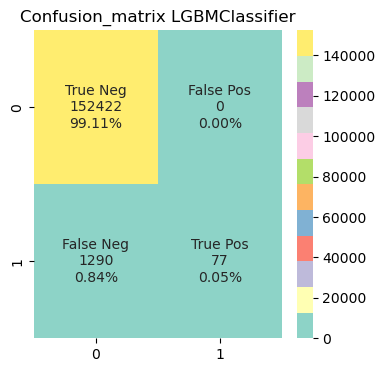

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    152422
           1       1.00      0.03      0.07      1367

    accuracy                           0.99    153789
   macro avg       1.00      0.52      0.53    153789
weighted avg       0.99      0.99      0.99    153789



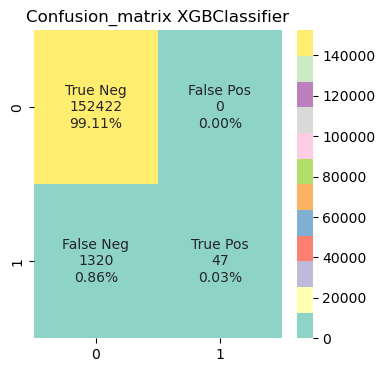

In [10]:
#получим метрики по всем моделям
list_metrics = []
for model in models:
    model.fit(features_train, target_train)
    show_metric(model, features_test, target_test)

In [11]:
pd.DataFrame(list_metrics, columns = ['model', 'roc_auc', 'gini', 'model_fit'])[['model', 'roc_auc', 'gini']]

model   roc_auc      gini
0  CatBoostClassifier  0.764621  0.529242
1      LGBMClassifier  0.759282  0.518565
2       XGBClassifier  0.756520  0.513040

Итак, с базовым набором признаков нам удалось получить значение площади под кривой, превышающей 0,76. Этот результат показала модель, обученная с помощью классификатора CatBoost, другие же хуже спрогнозировали вероятность положительного класса, что дало  чуть более низкий результат метрики. CatBoostClassifier продемонстрировал и самый высокий процент правильных ответов по единицам, в сравнении с остальными - разрыв получился значительный. Возьмем эту модель как основную.

Посмотрим теперь важность признаков и их влияние.

In [12]:
#визуализация feature_importance и влияния признаков
def get_feature_importance(model):
    if model.__class__.__name__=='CatBoostClassifier':
        importances = model.get_feature_importance(prettified=True)
    else:
        importances = pd.DataFrame(np.vstack((np.array(features_test.columns).T, \
           np.array(model.feature_importances_/sum(model.feature_importances_)*100))).T, \
                                   columns = ['Feature Id', 'Importances']).sort_values('Importances', ascending=False)
    
    importances.loc[importances['Importances'] >=4.5, 'color'] = 'O'
    importances.loc[importances['Importances'] < 4.5, 'color'] = 'B'

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = {'O':(1.0, 0.7333333333333333, 0.47058823529411764), \
              'B':(0.6823529411764706, 0.7803921568627451, 0.9098039215686274)}
    plt.bar(importances['Feature Id'], importances['Importances'], color=importances['color'].map(colors)) 
    plt.gca().set_yticklabels([f'{x/100:.0%}' for x in plt.gca().get_yticks()]) 
    sns.lineplot(x = importances['Feature Id'], y=4.5, style=True, dashes=[(3,3)], color = 'salmon')

    plt.xticks(rotation=90)
    plt.tick_params(axis='x', labelsize= 8)
    plt.ylabel('Importances (shape, %)')
    plt.title(f'Важность признаков для модели {model.__class__.__name__}')
    plt.show()

    explainer = shap.Explainer(model)
    shap_values = explainer(features_test)
    feature_names = [a + ": " + str(b) for a,b in zip(features_test.columns, np.abs(shap_values.values).mean(0).round(2))]
    
    plt.title(f'Влияние признаков на {model.__class__.__name__}')
    if model.__class__.__name__=='LGBMClassifier':
        shap.summary_plot(shap_values[:, :, 1], features_test, cmap='GnBu', max_display = 12, feature_names=feature_names)
    else:
        shap.summary_plot(shap_values, features_test, cmap='GnBu', max_display = 12, feature_names=feature_names)
    plt.show()

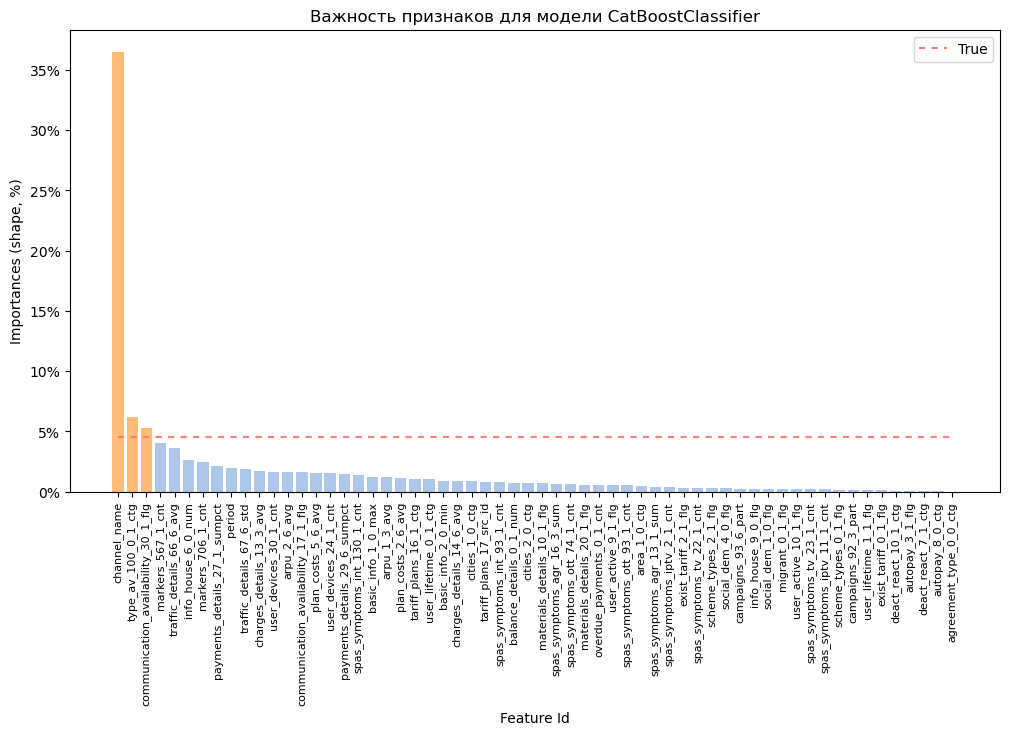

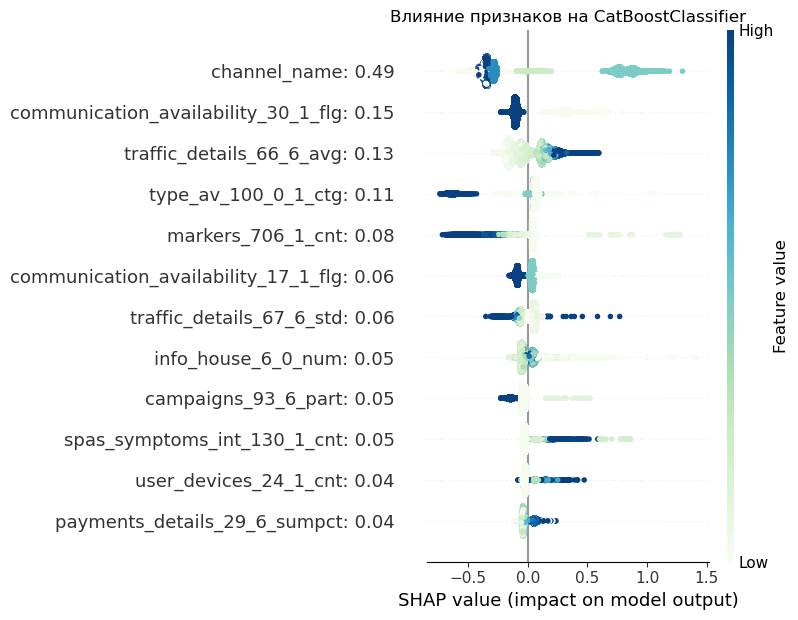

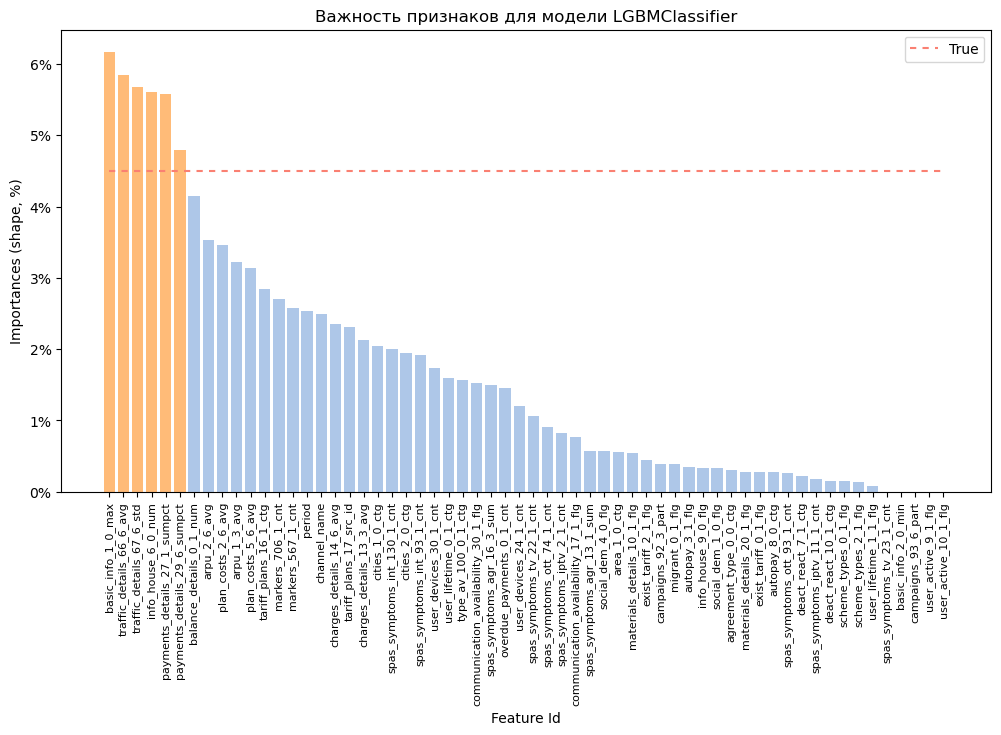

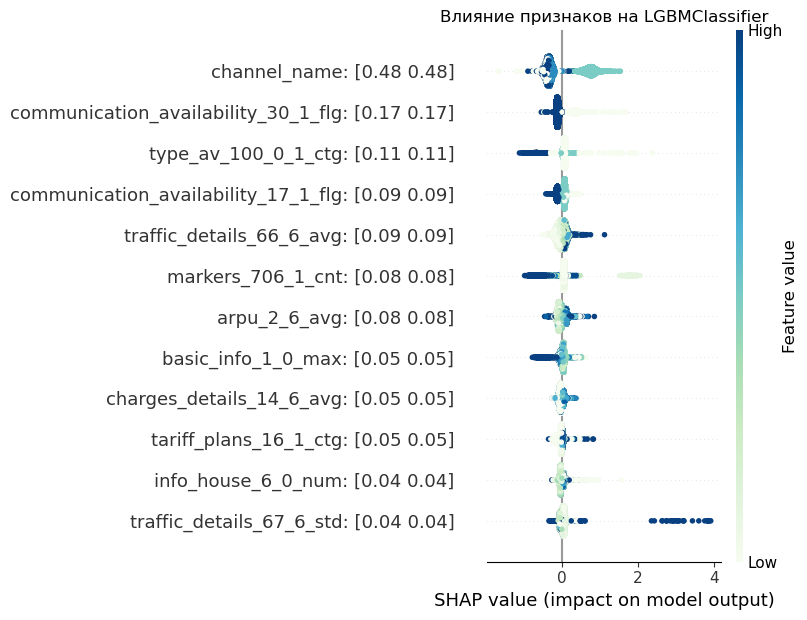

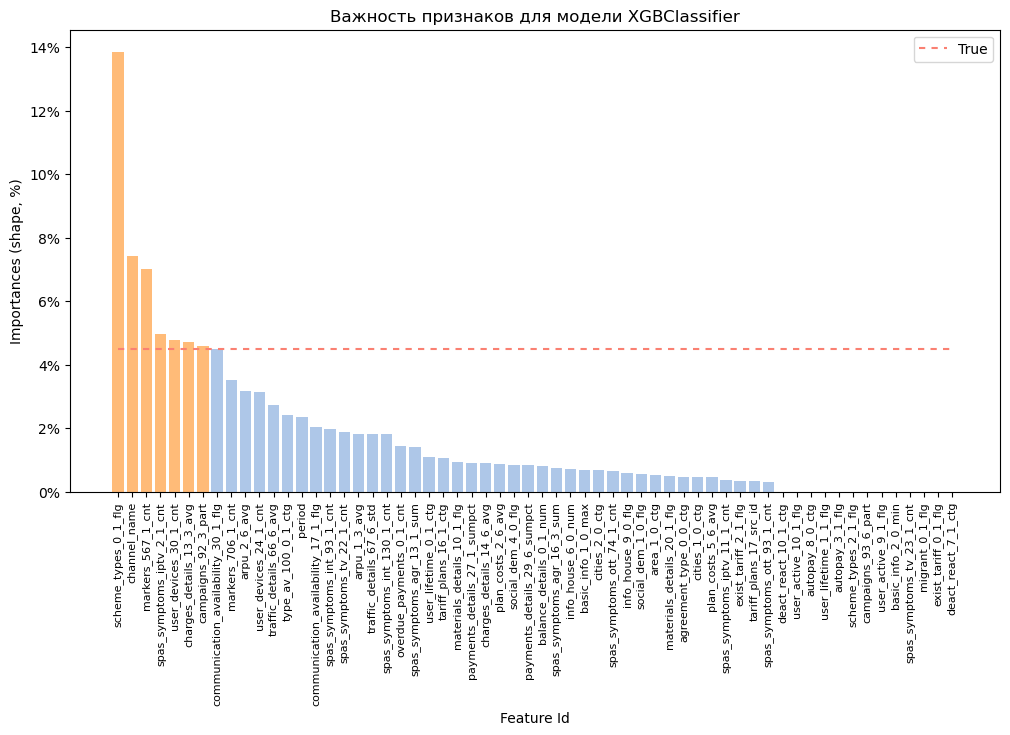

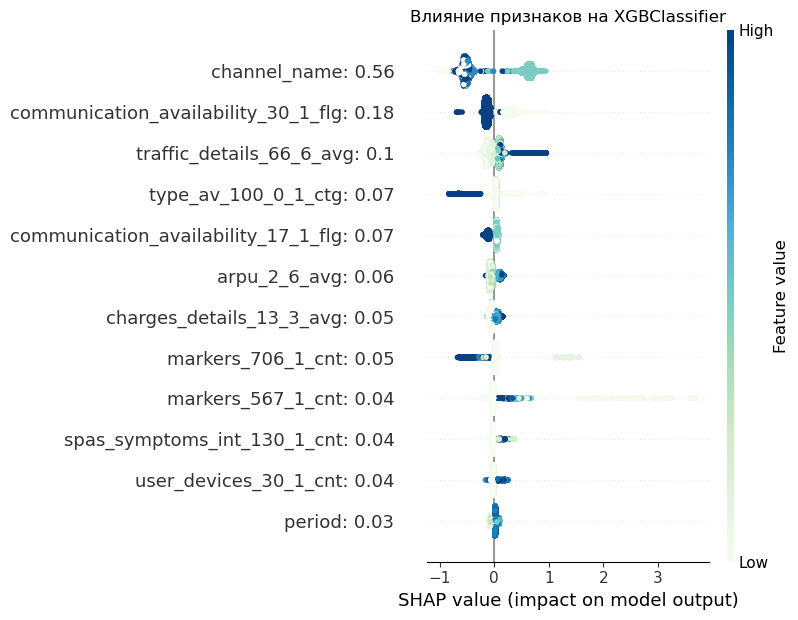

In [13]:
for i in range(len(list_metrics)):
    get_feature_importance(list_metrics[i][-1])

Наиболее значимыми признаками для модели классификатора CatBoost оказались:
 - канал продаж - более 35%. Что в принципе логично, т.к. в своем большинстве продажи были совершены через канал под номером 3.
 - type_av_100_0_1_ctg
 - communication_availability_30_1_flg

Теперь посмотрим на график влияния.

Для каждой точки вертикальное расположение показывает, какой признак она отражает;
Цвет показывает, является ли этот объект сильно значимым или слабо значимым для этой строки датасета;
Горизонтальное расположение показывает, привело ли влияние значения этого признака к более точному прогнозу или нет.
Таким образом мы видим, что каналы отличные от третьего снижают вероятность продаж, также как и высокие значения маркера 706, type_av_100_0_1_ctg, тогда как большие значения traffic_details_66_6_avg наоборот - увеличивают.

Первое число в каждой строке показывает, насколько снизилась производительность модели при случайной перетасовке (в данном случае с использованием "точности" в качестве метрики производительности). Существует некоторая случайность в точном изменении производительности от перетасовки столбца. Мы измеряем количество случайности в нашем вычислении важности перестановки, повторяя процесс с несколькими перестановками. Поэтому в дальнейшем мы попробуем сгладить за счет проебразований данные признаки и посмотреть, как это повлияет на модель.

Для модели LGBMClassifier на передний план вышли - информация о трафике и о платежах. Также оказалась значимой информация об абоненте и о доме, в котором подключены к услугам. Следует отметить, что доля каждого из признаков в структуре не превышает 7% и не очень коррелирует с признаками влияющими на прогноз. Не меняя ничего в этой моделе и данных мы получили достойные резутьтаты сабмита на тесте - около 0,645. 

## Исследовательский анализ данных

In [14]:
def show_base_info_category_columns(df, column):

    df_pr_0 = df.loc[df['target']==0][column].value_counts(normalize=True).to_frame().reset_index()
    df_pr_1 = df.loc[df['target']==1][column].value_counts(normalize=True).to_frame().reset_index()
    fig = plt.figure(figsize=(22, 7))
    
    x, y = df[['target', column]].T.values

    font = {'family': 'serif', 'color':  'darkred','weight': 'normal','size': 16}
    plt.subplot(1, 2, 1)
     
    sns.lineplot(df_pr_0, x = column, y='proportion', color = 'darkcyan') 
    sns.lineplot(df_pr_1, x = column, y='proportion', color = 'salmon')
    sns.lineplot(df_pr_0, x = column, y=0.02, style=True, dashes=[(3,3)], color = 'tan')
    plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])
    plt.ylabel('Share')
    plt.xlabel('Values in category')
    plt.text(df_pr_0[column].min(), 0.07, 'phik         =  %.2f'%phik.phik_from_array(x, y, num_vars=['x']), fontdict=font,  ha='left', va='top')
    plt.text(df_pr_0[column].min(), 0.02, 'significance = %.2f'%phik.significance_from_array(x, y, num_vars=['x'])[1], fontdict=font,  ha='left', va='top')
    plt.title(f'Category structure {column}')
    plt.legend(['target_0', 'threshold','target_1',])

    plt.subplot(1, 2, 2)
    
    sns.lineplot(x = [0,1], y = mean, style=True, dashes=[(3,3)], color = 'salmon')
    sns.lineplot(x = [0,1], y = median, style=True, dashes=[(4,4)], color = 'brown')
    plt.legend(['mean', 'median'])
    sns.boxplot(df, x = 'target', y = column, palette = ['cornflowerblue', 'darkcyan'], fill=False, gap=.3)
    plt.title(f'Category distribution {column}')
    plt.show()

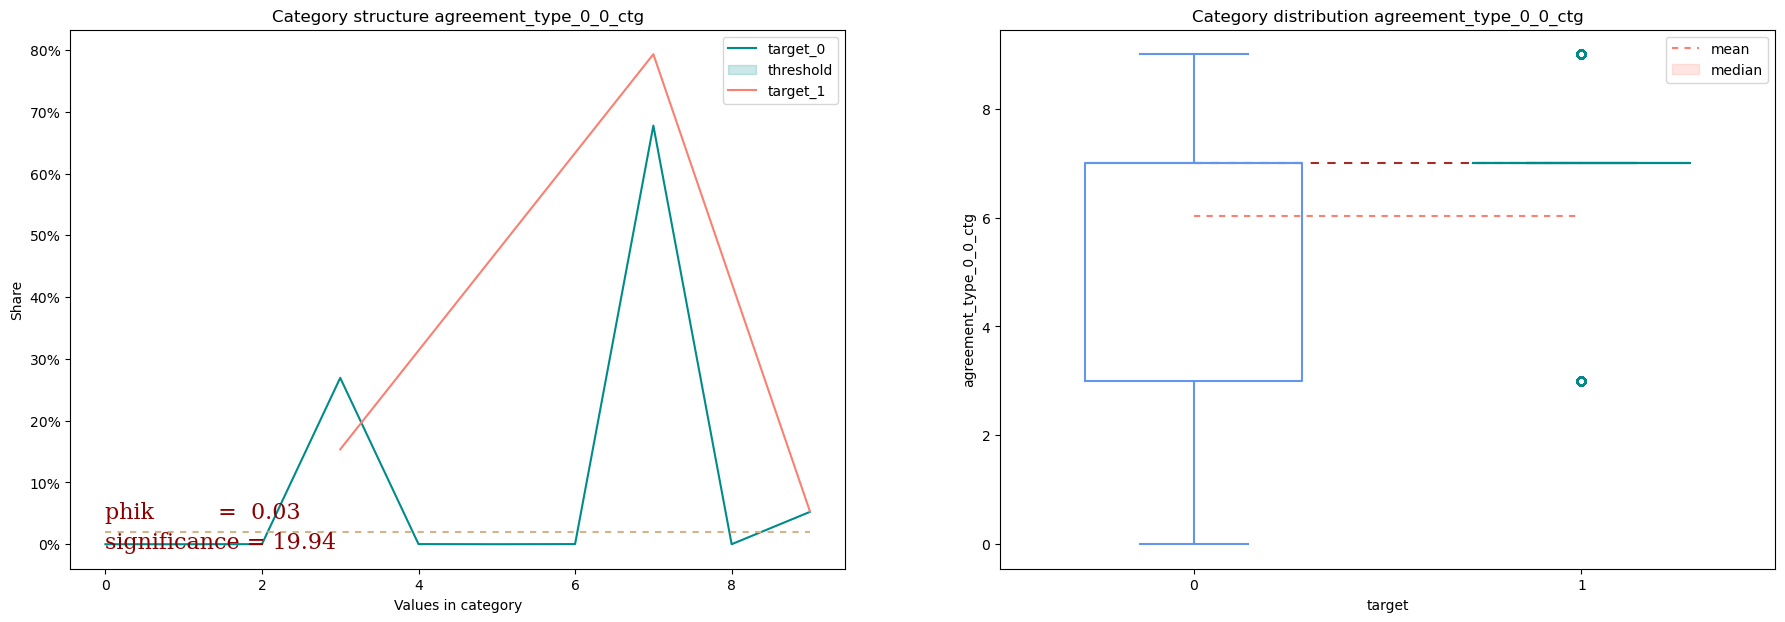

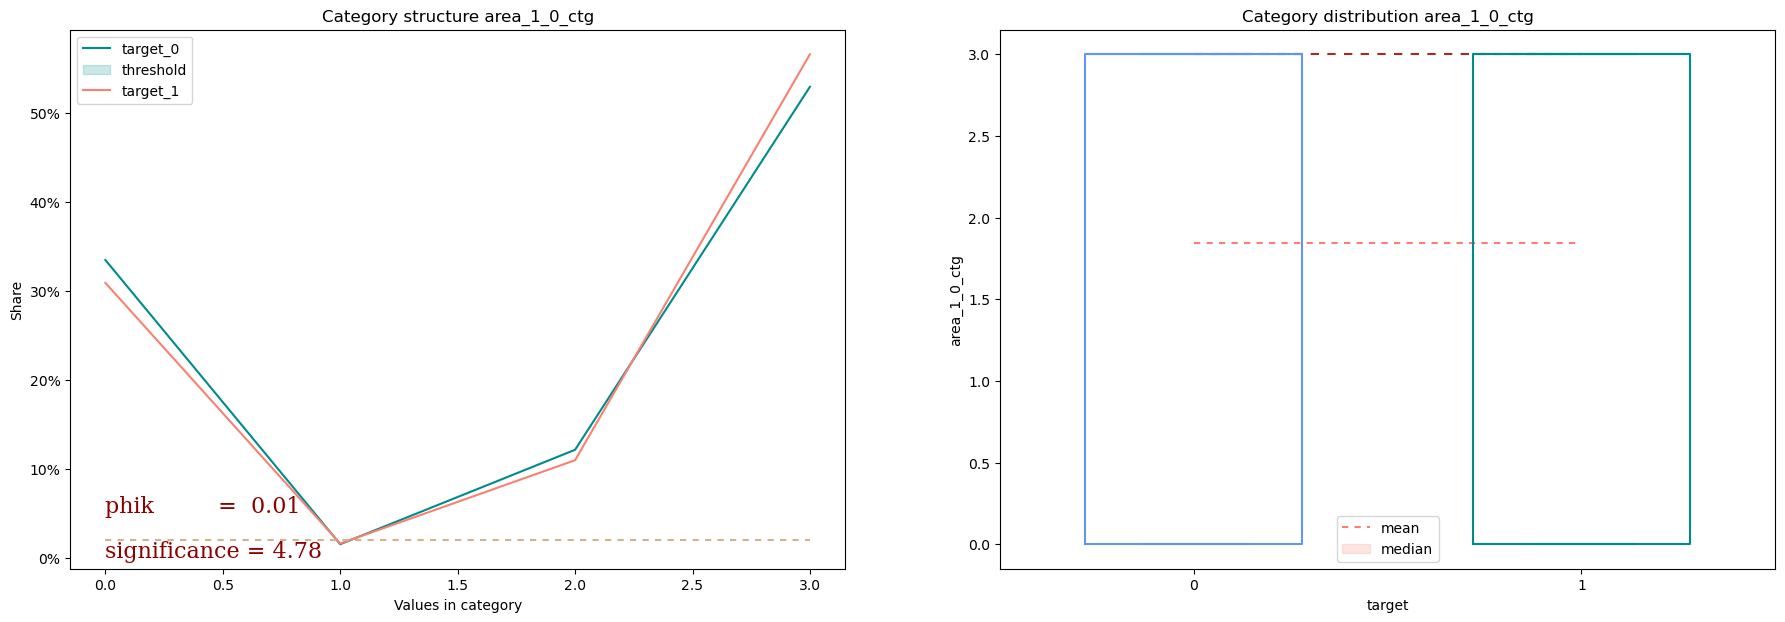

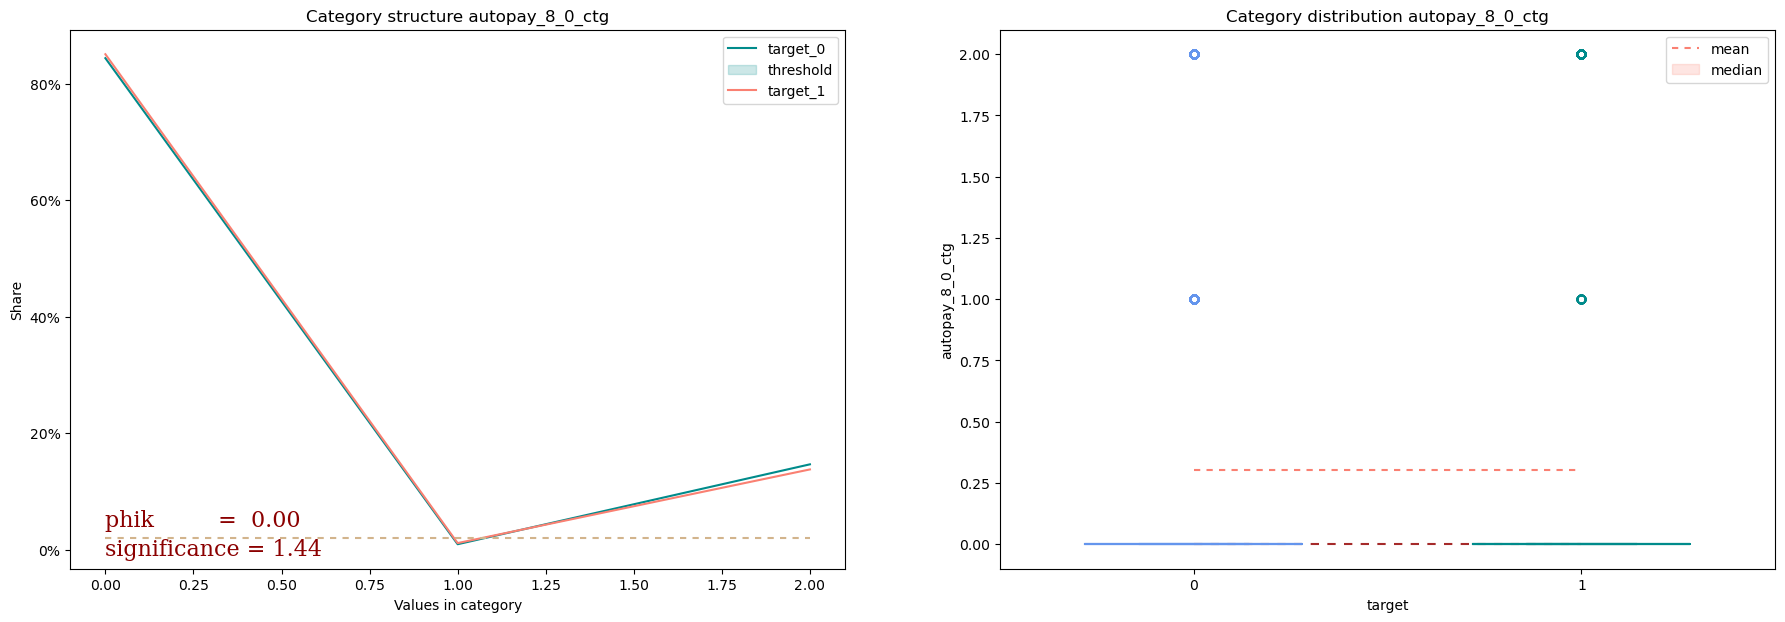

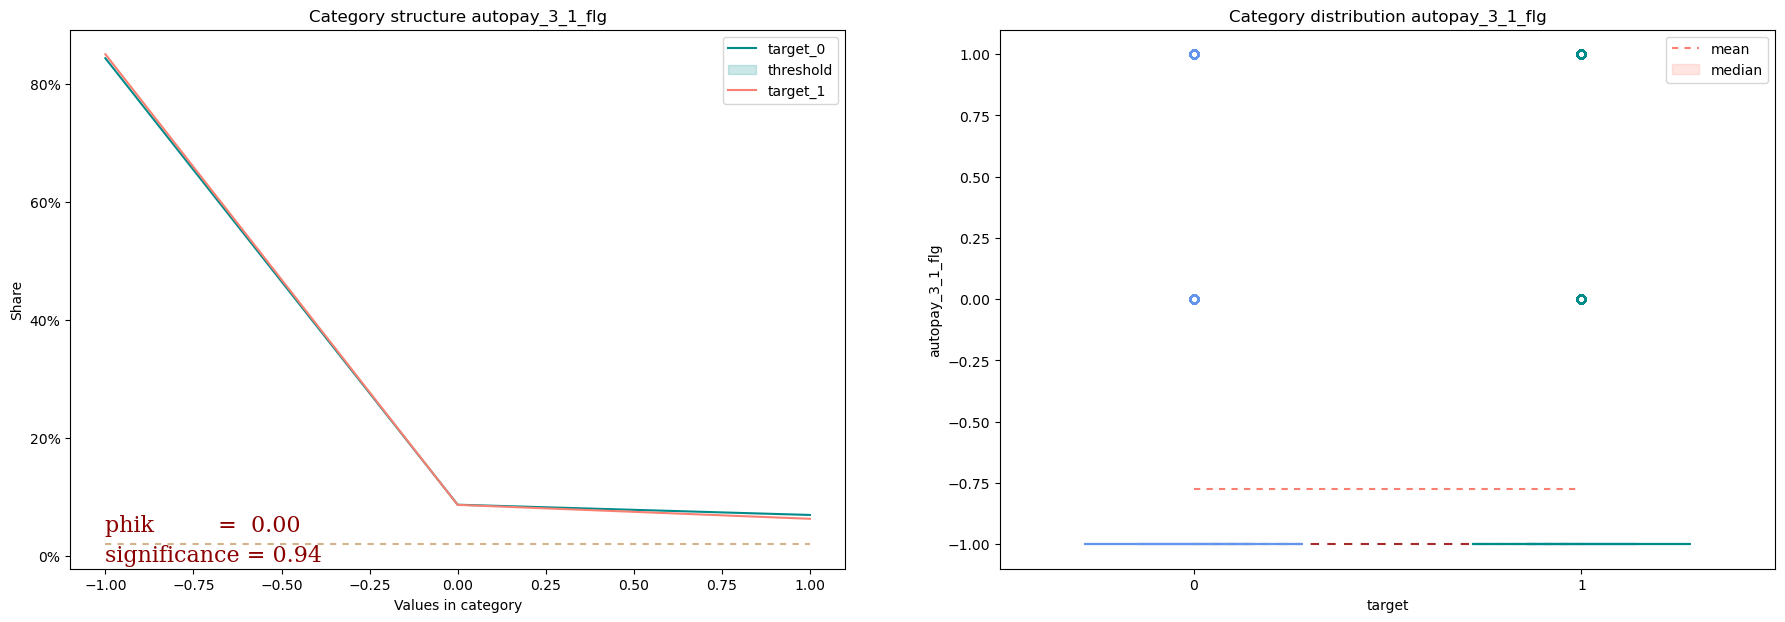

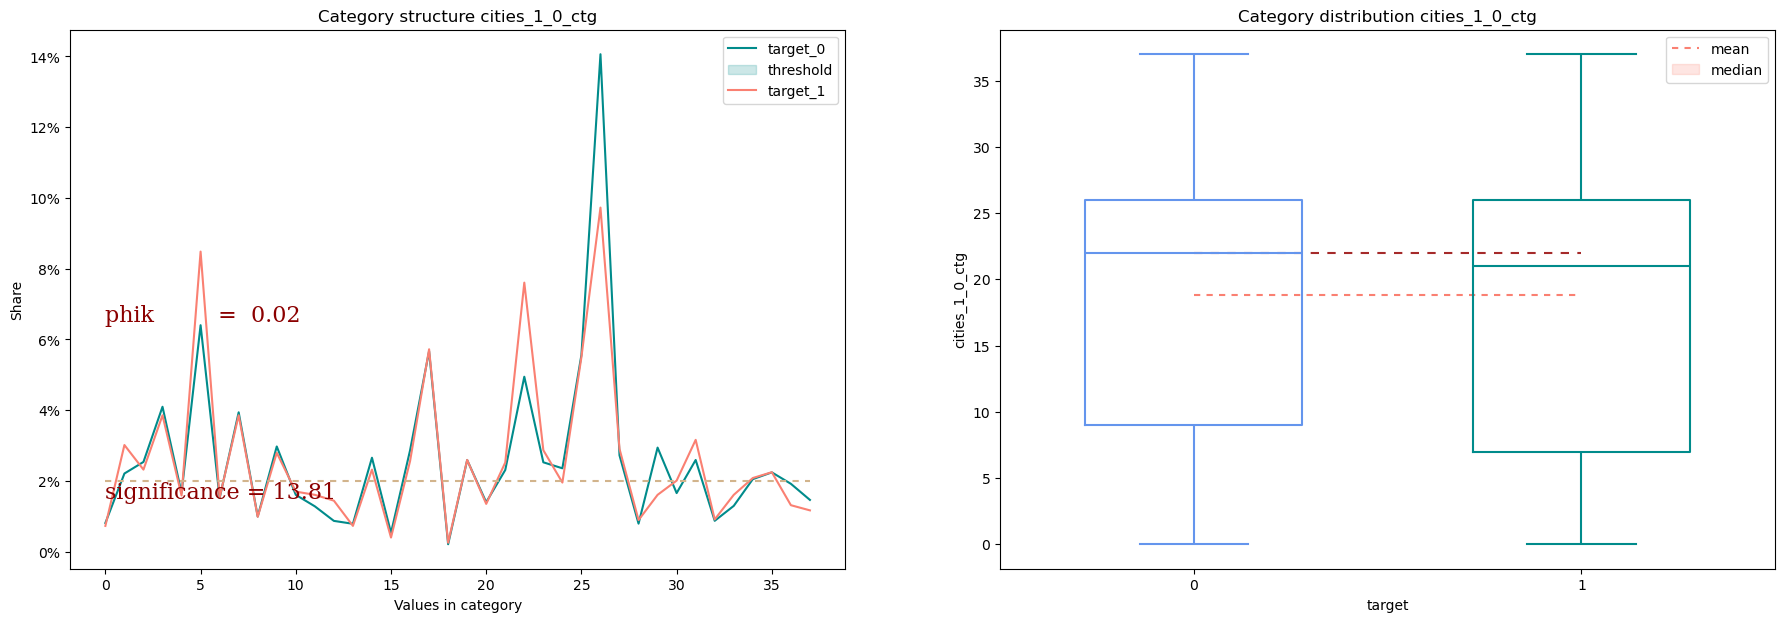

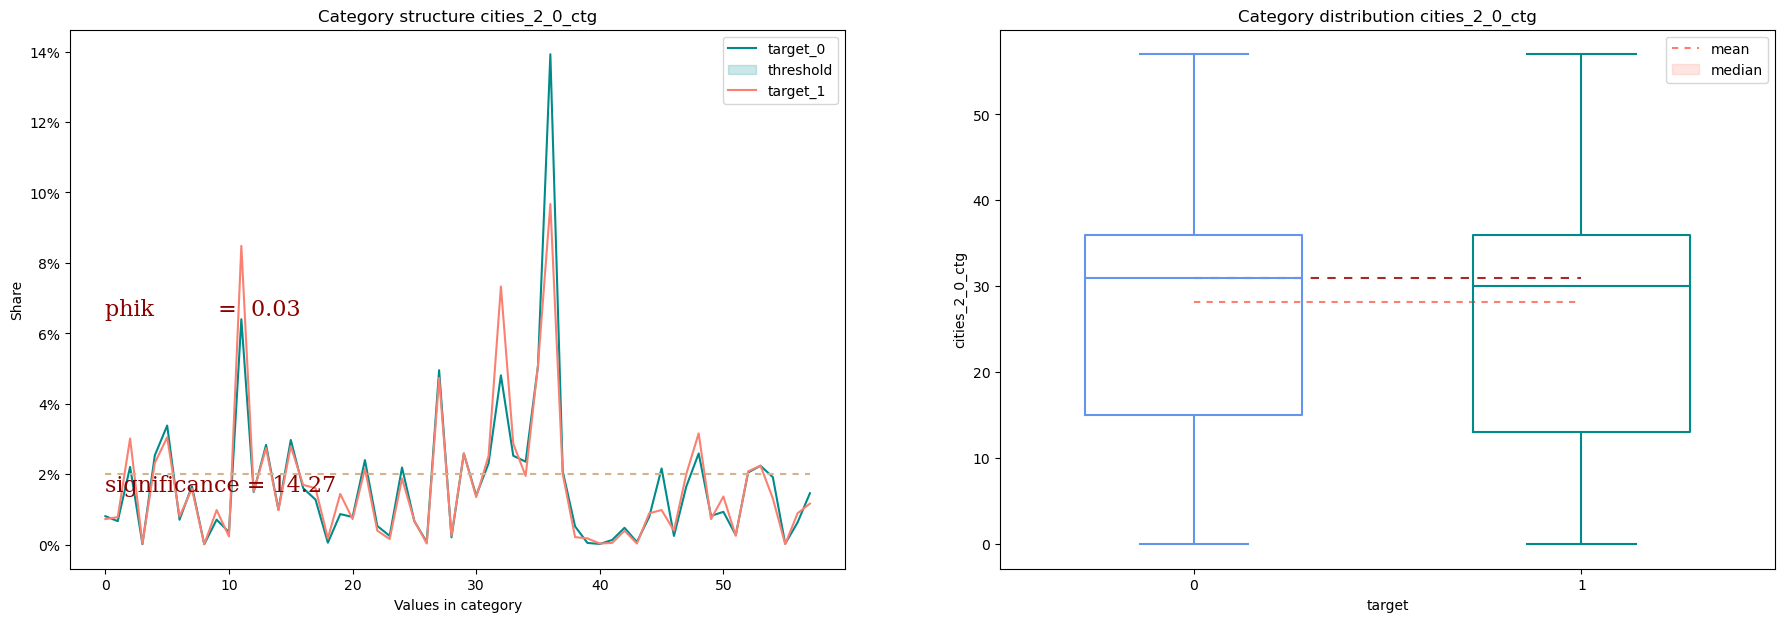

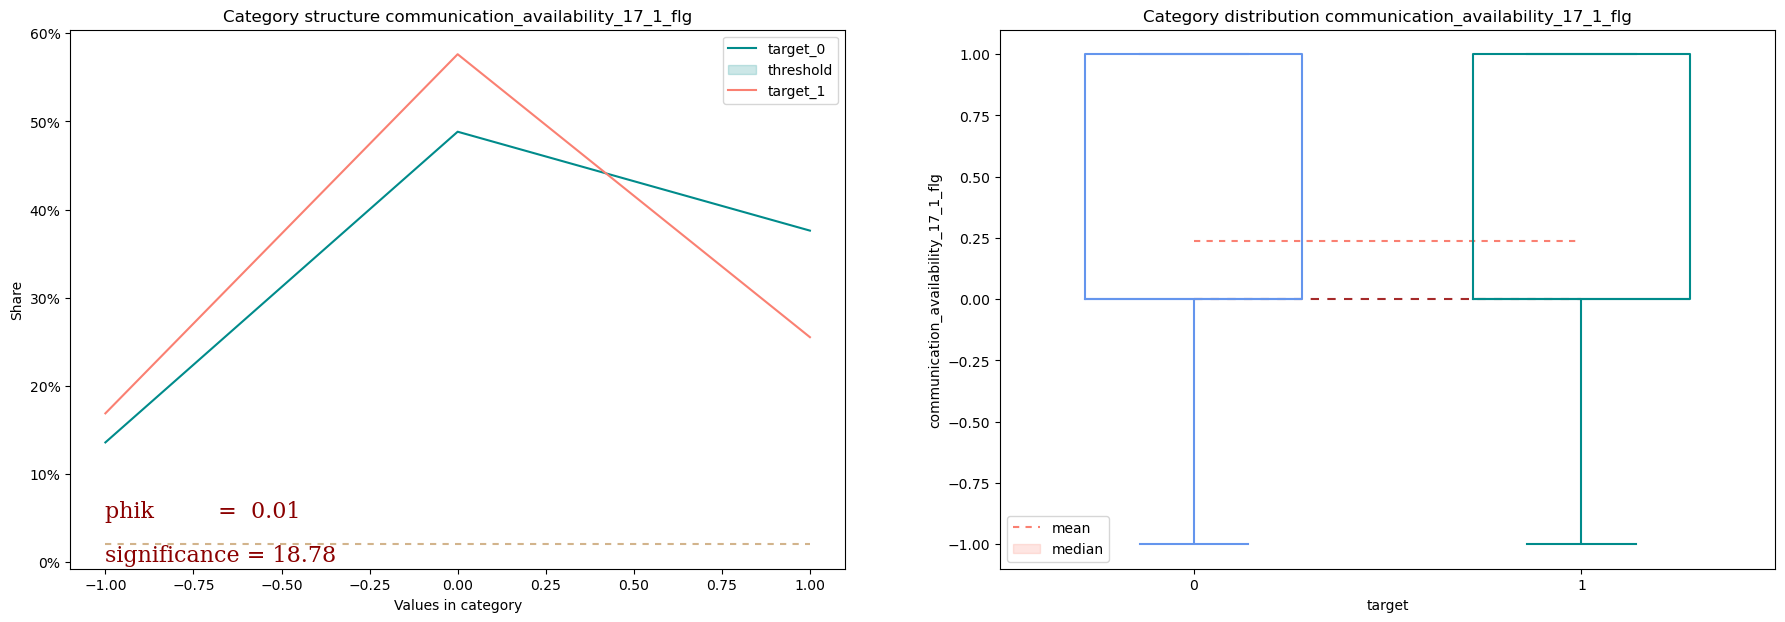

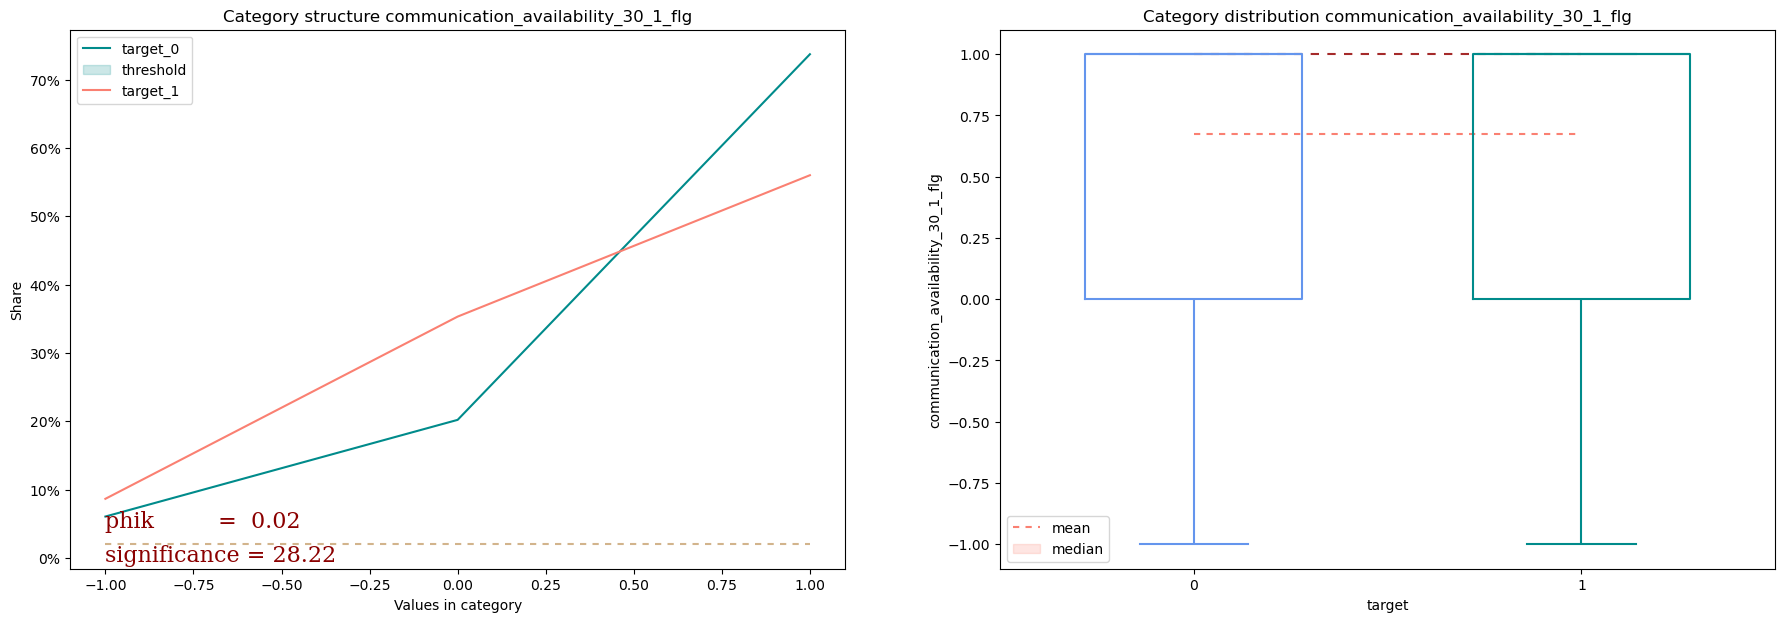

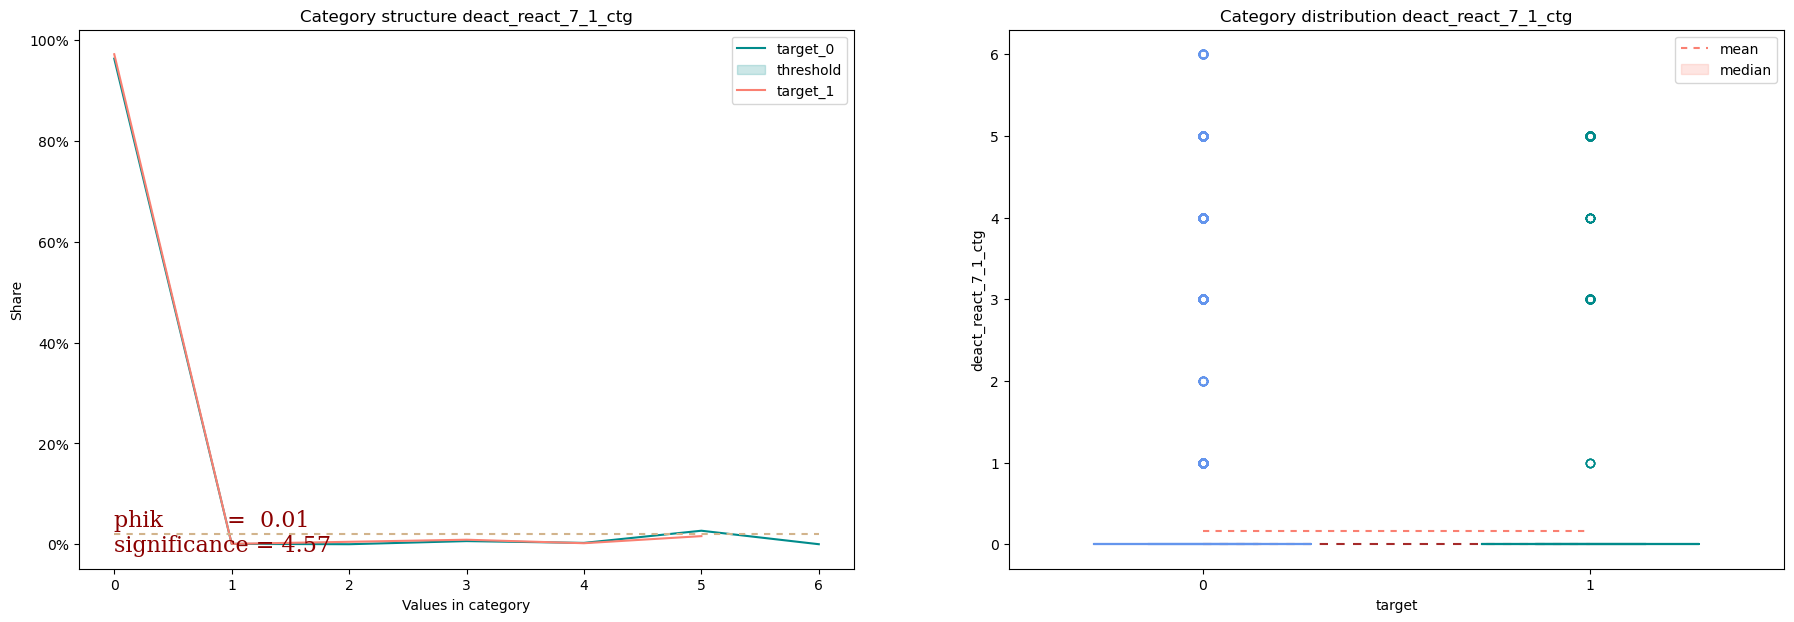

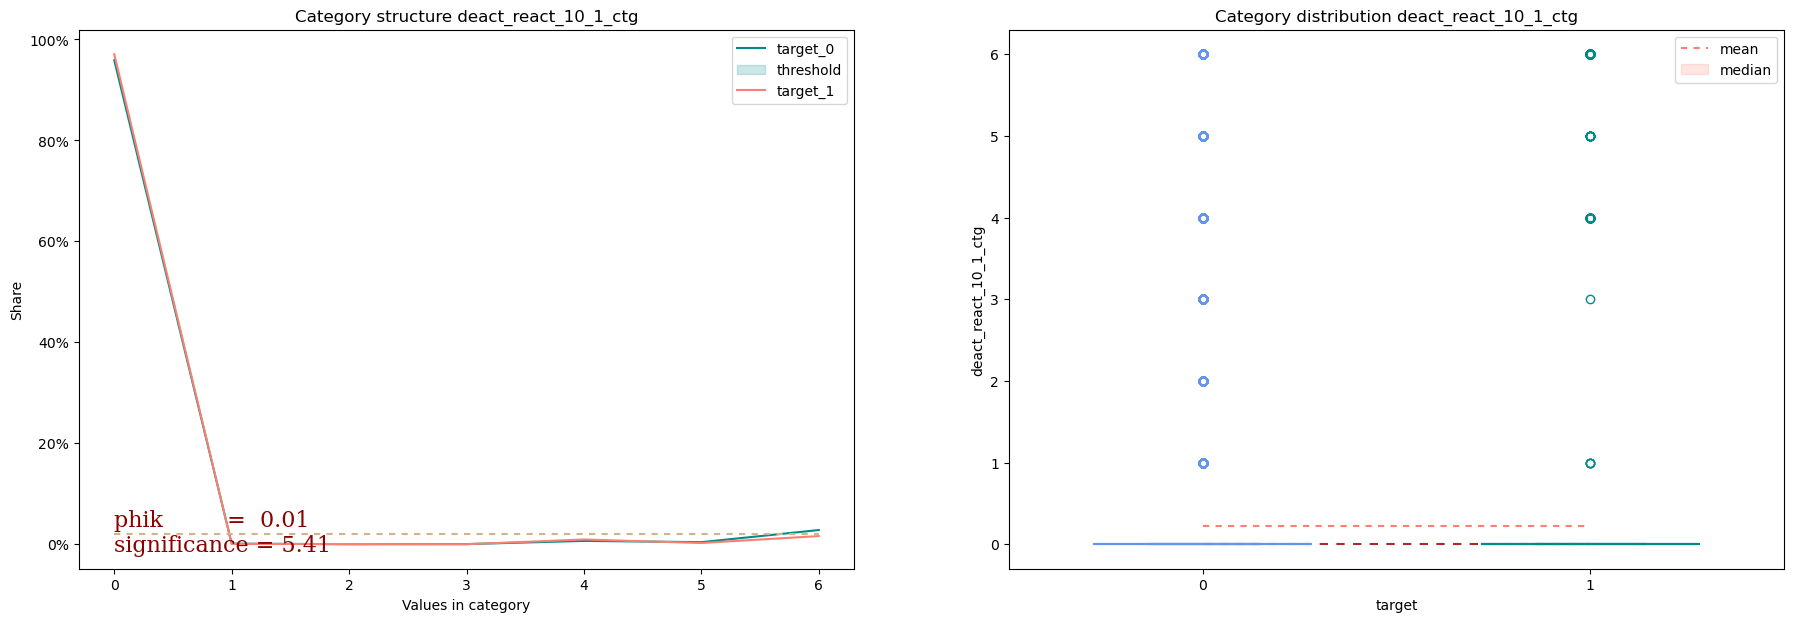

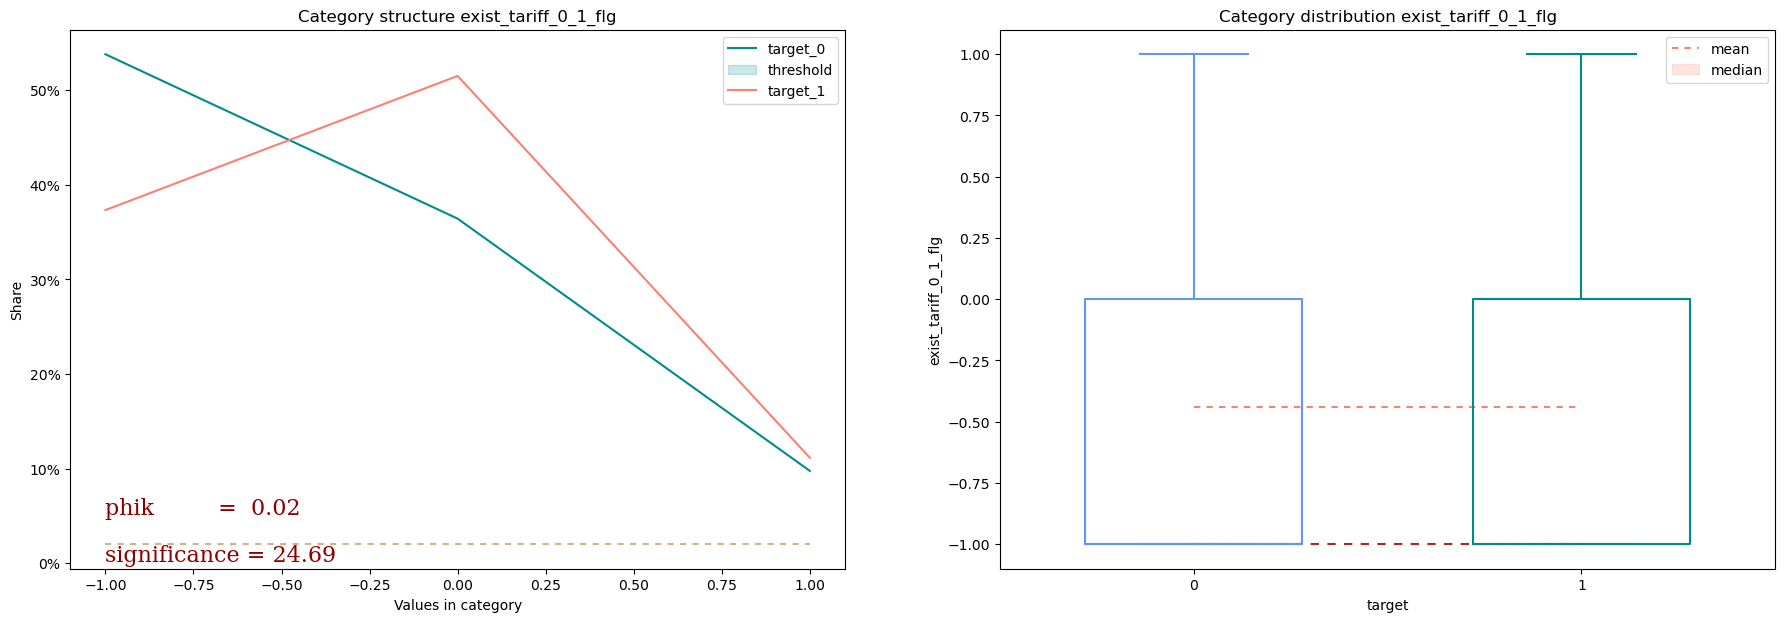

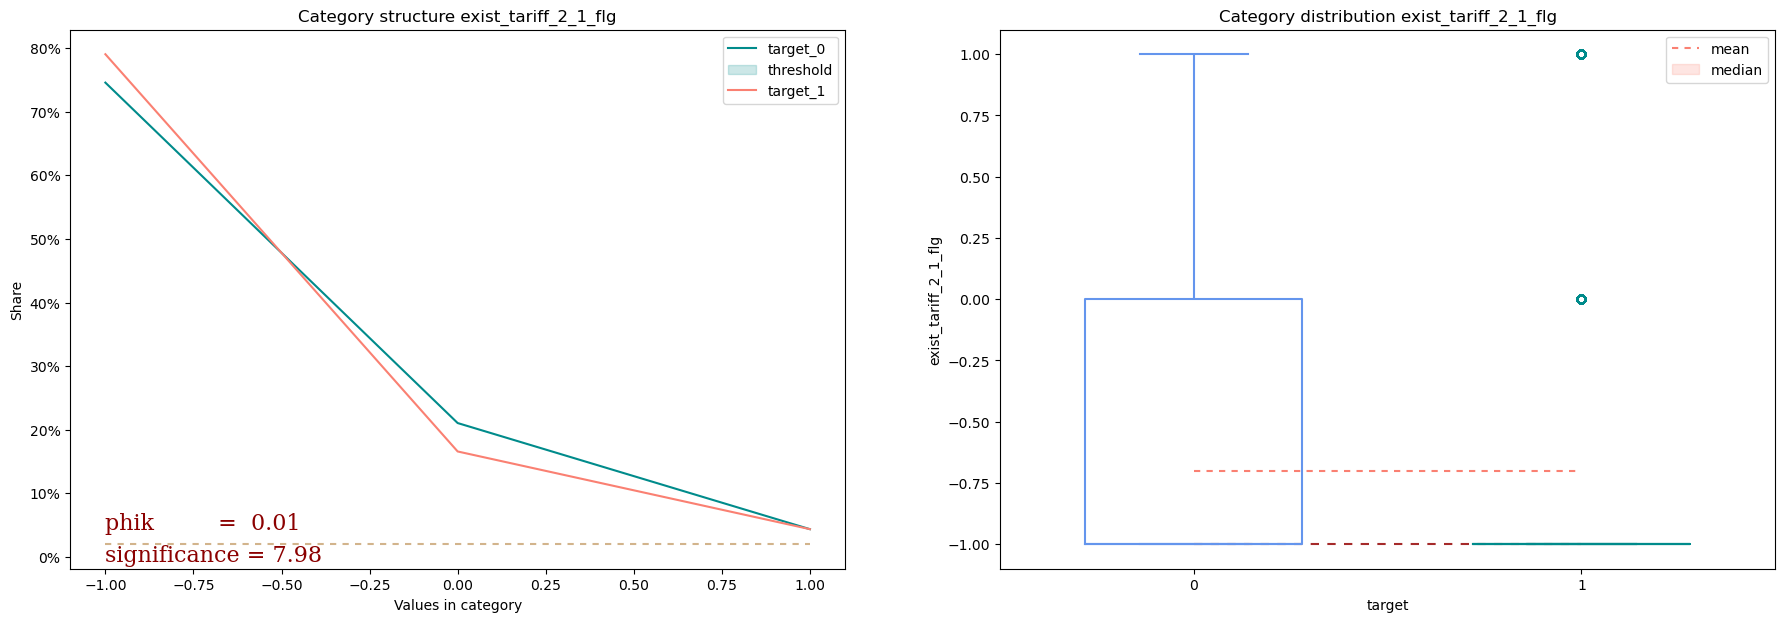

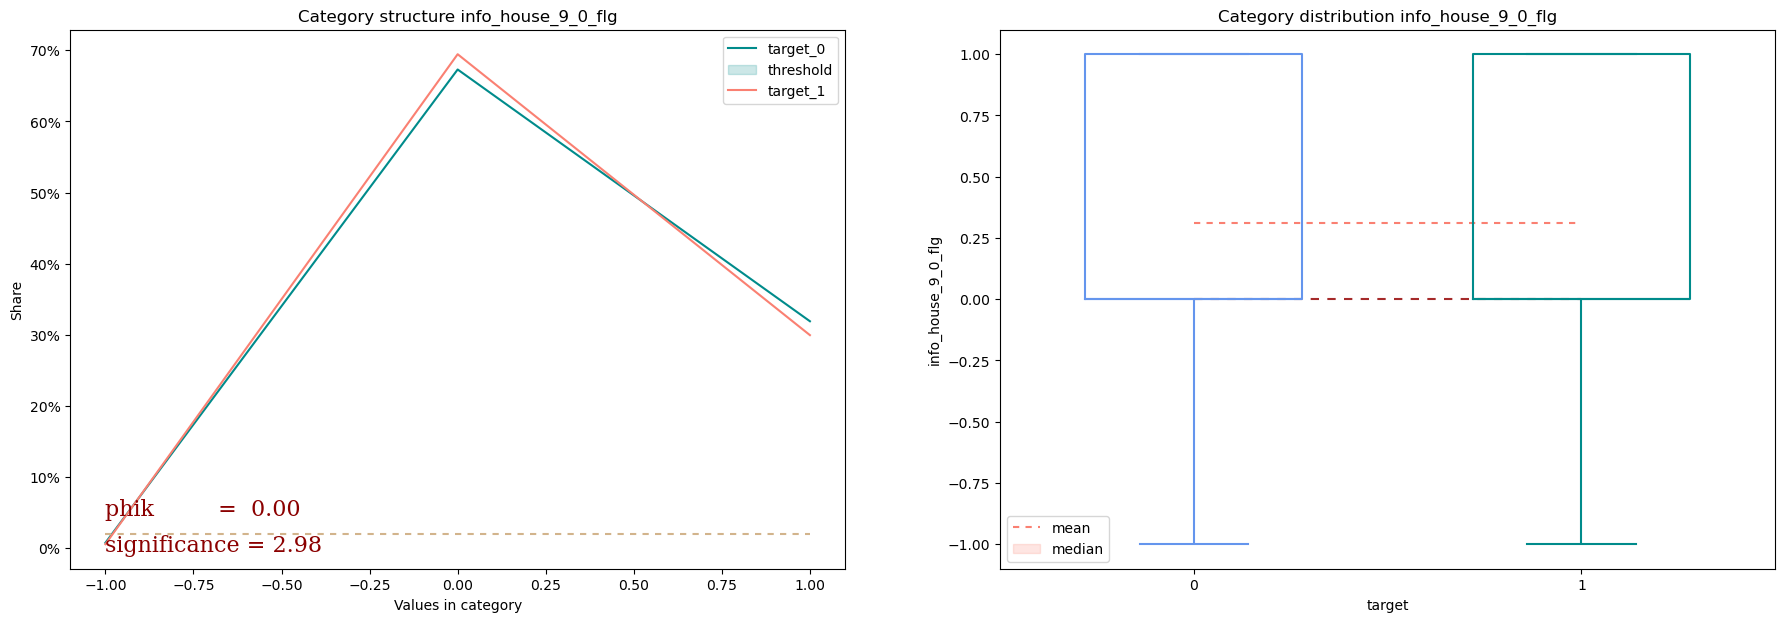

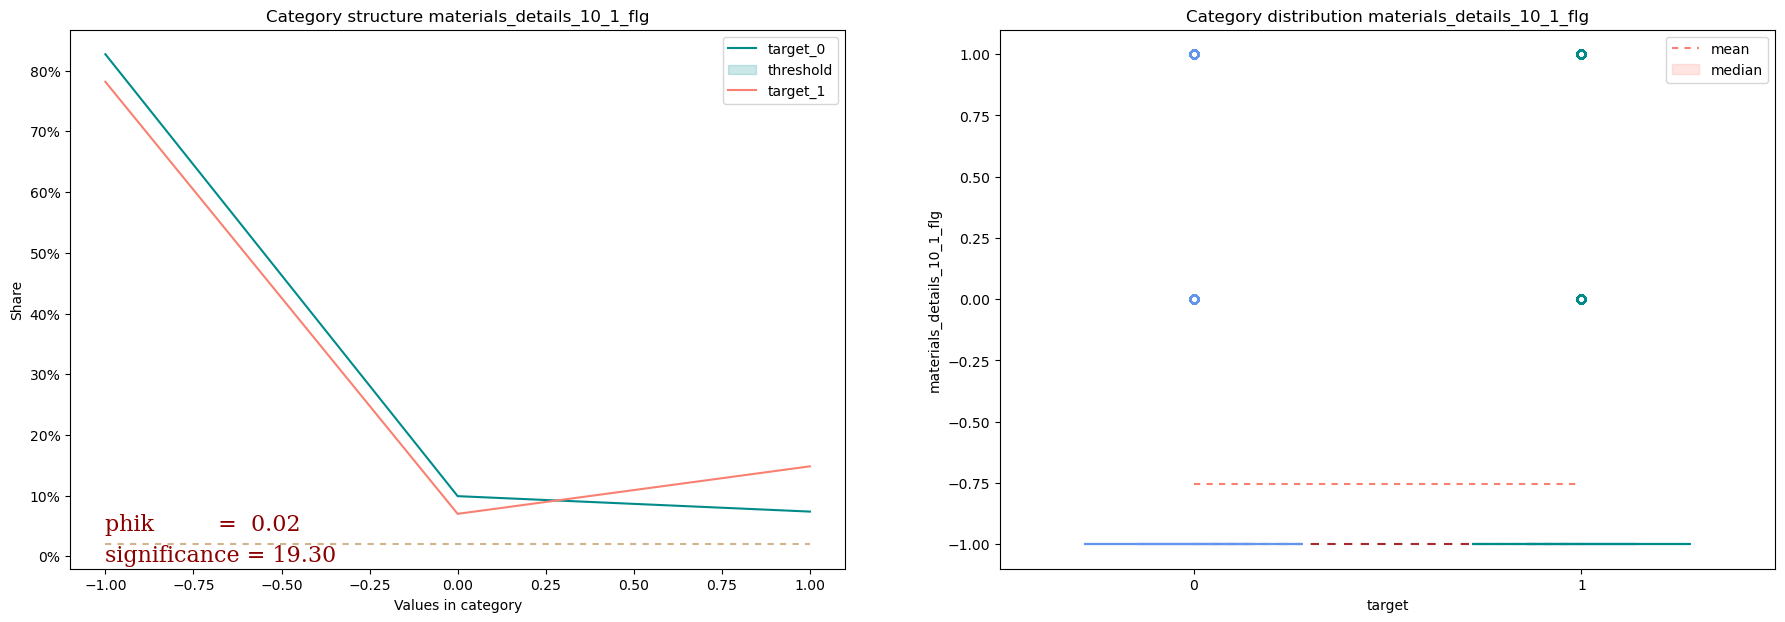

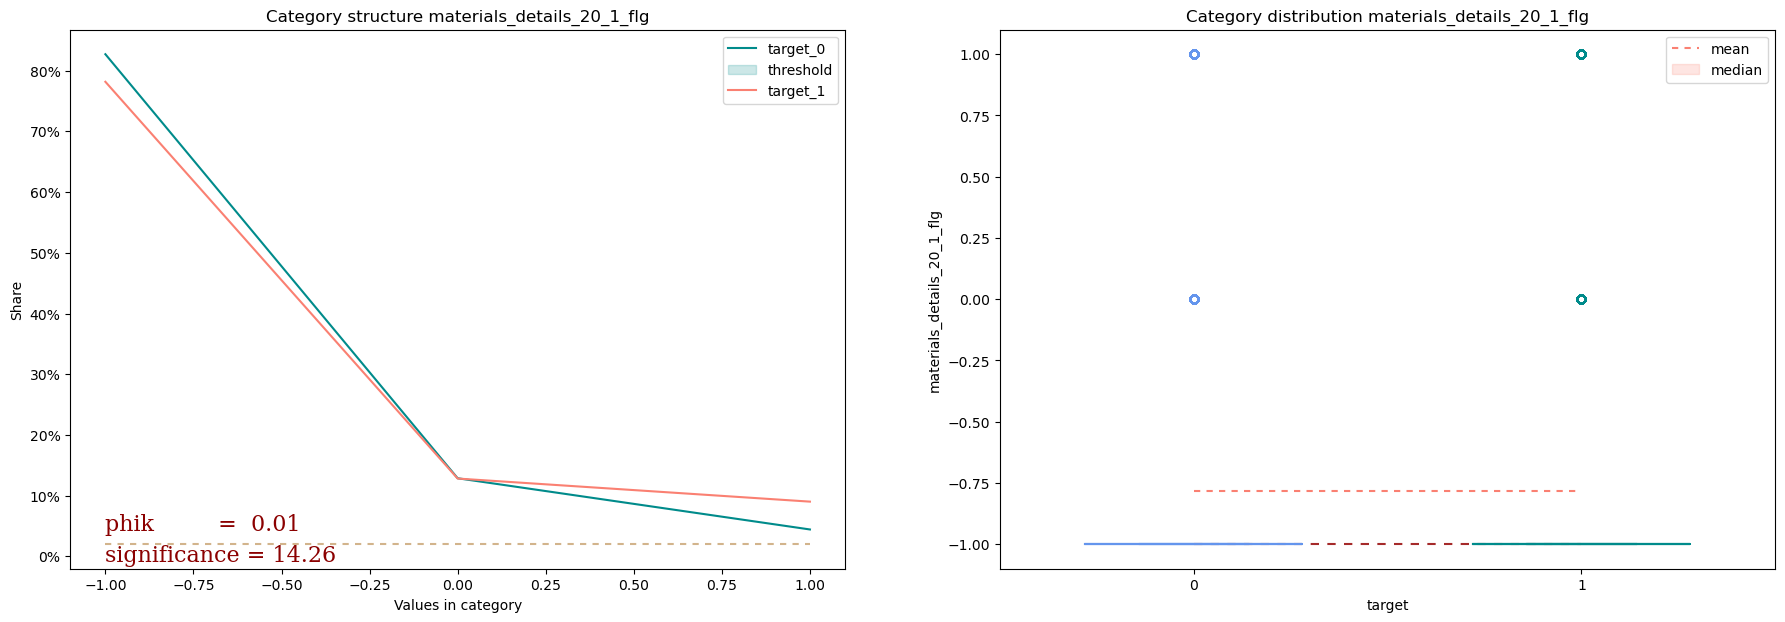

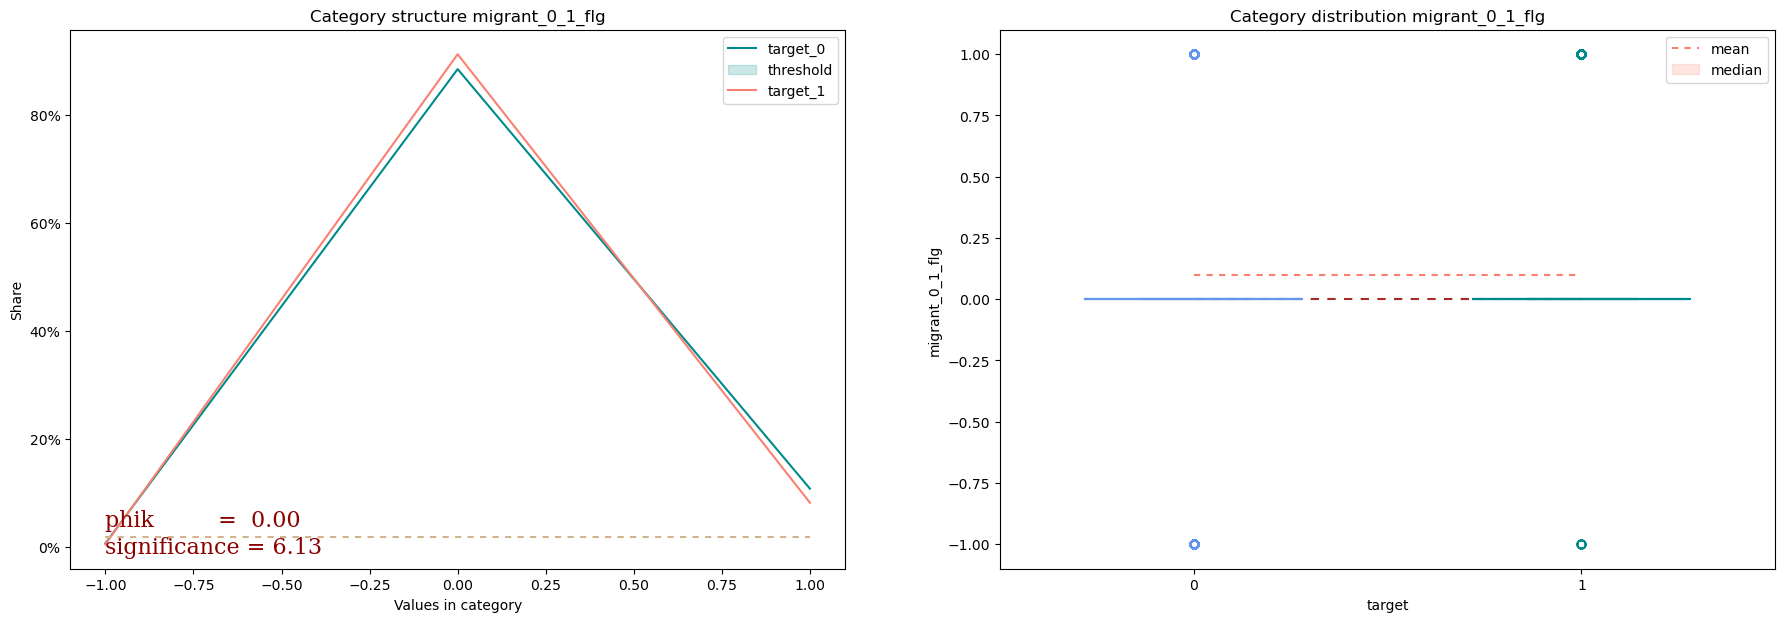

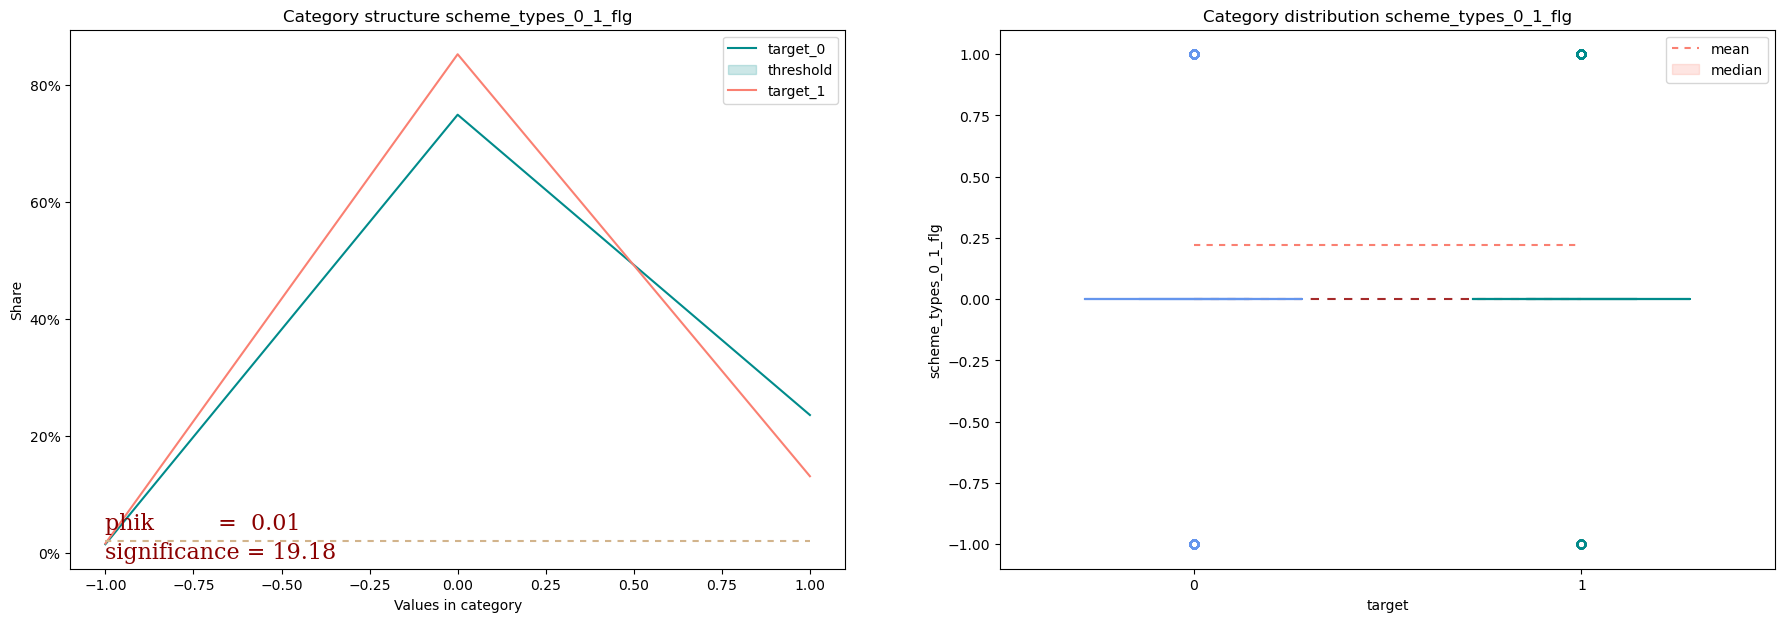

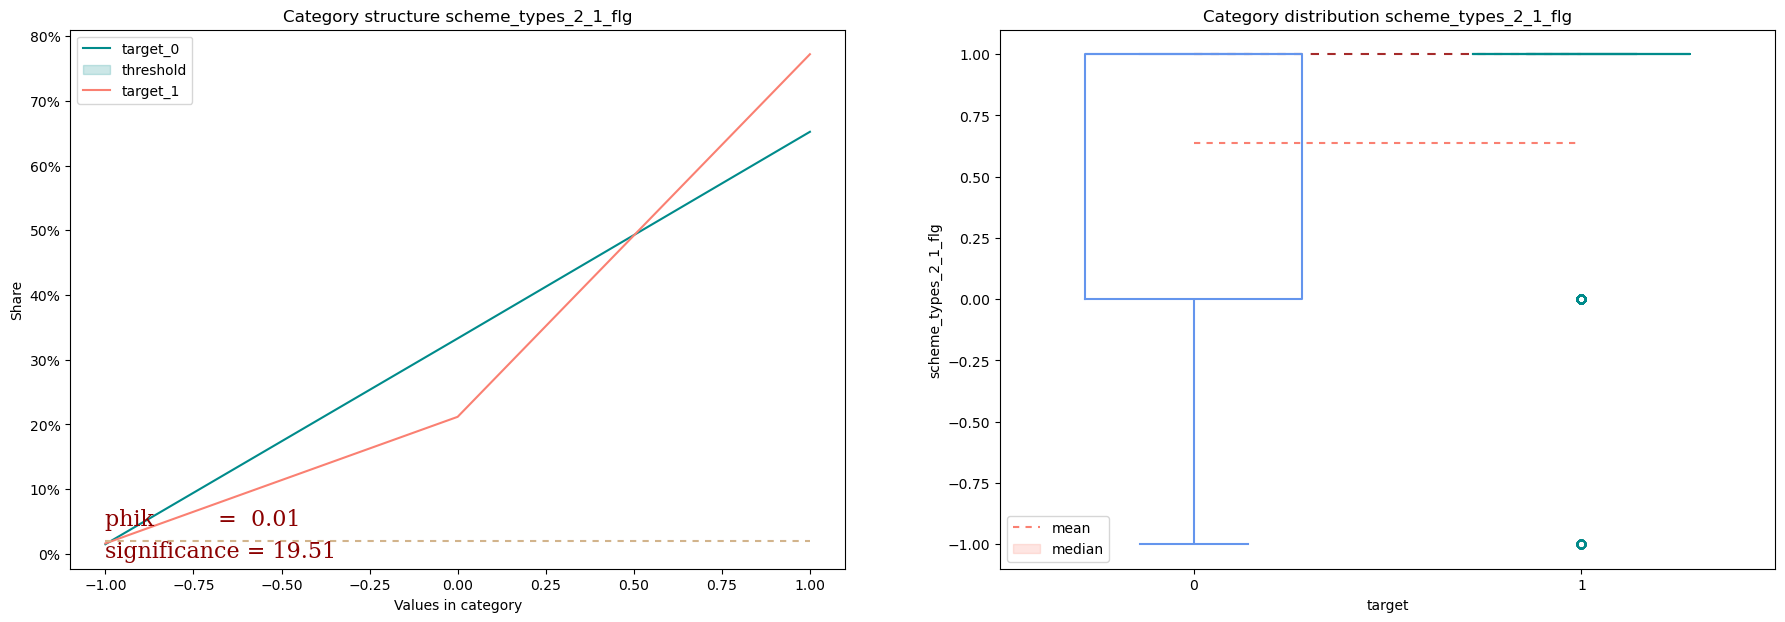

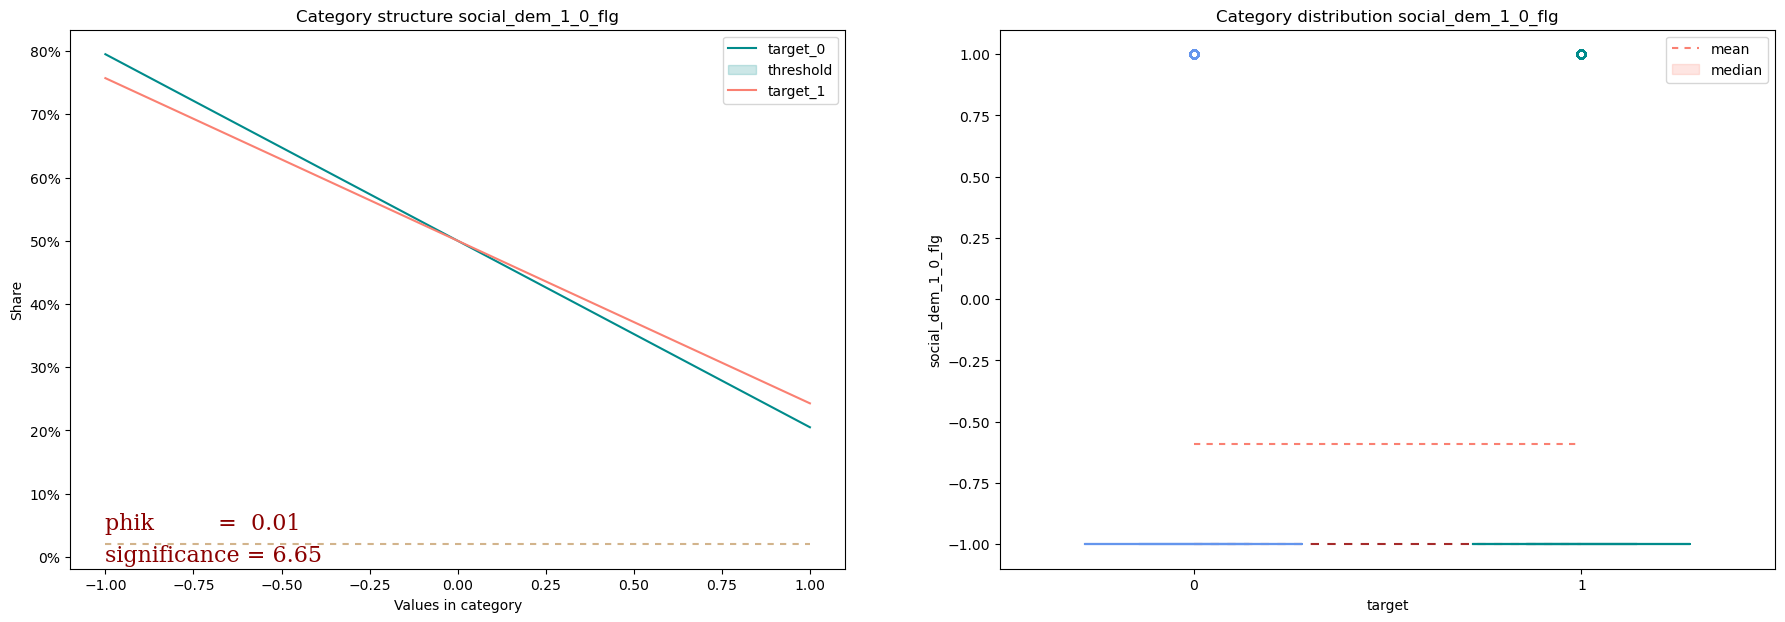

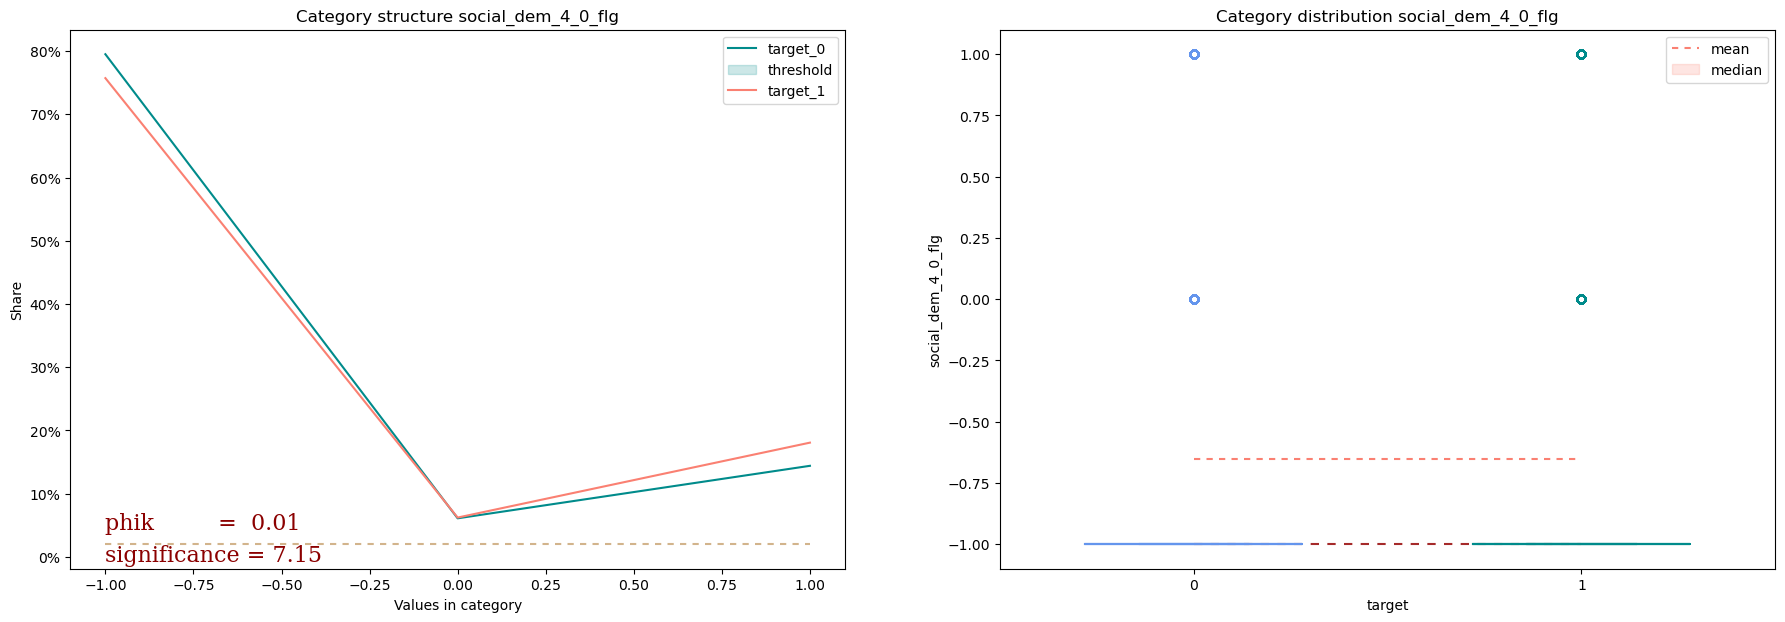

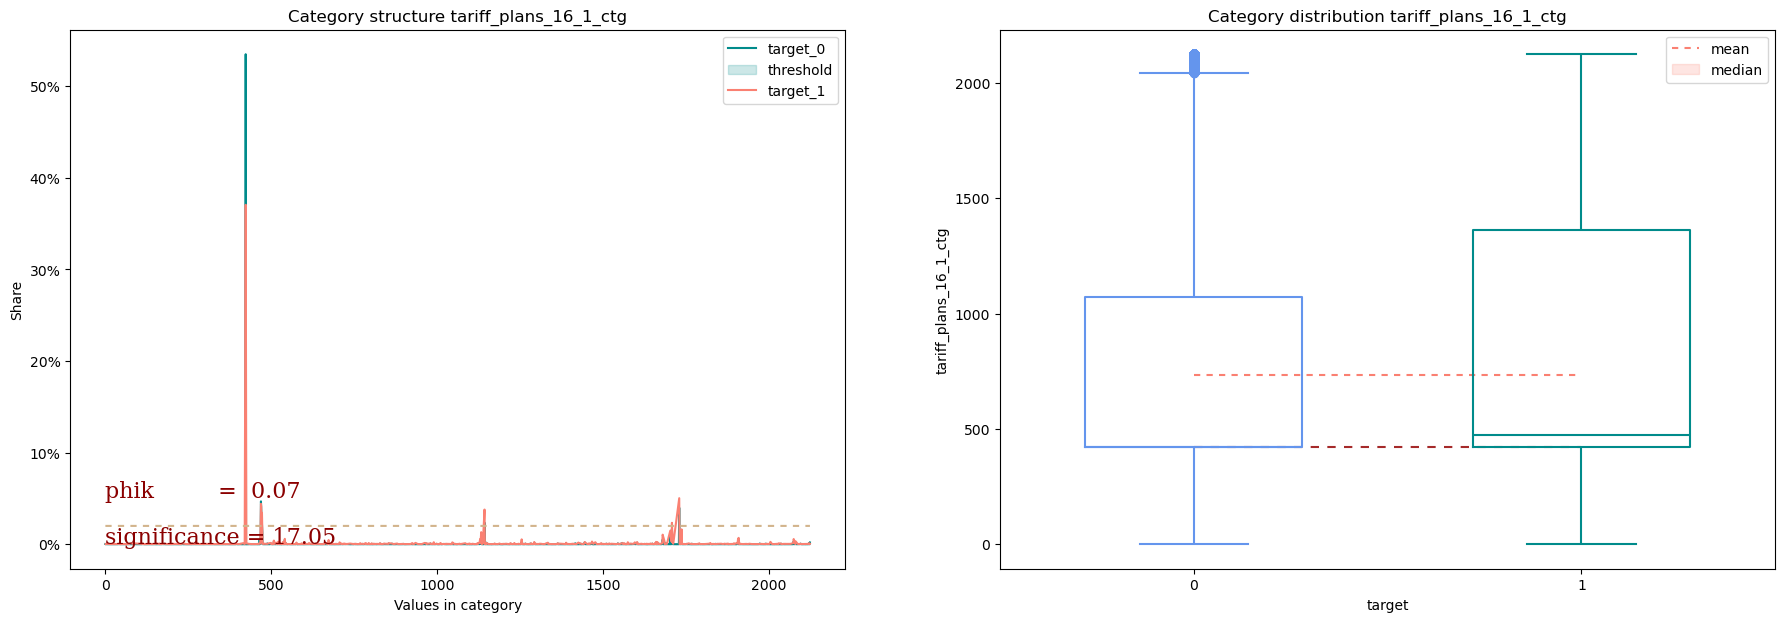

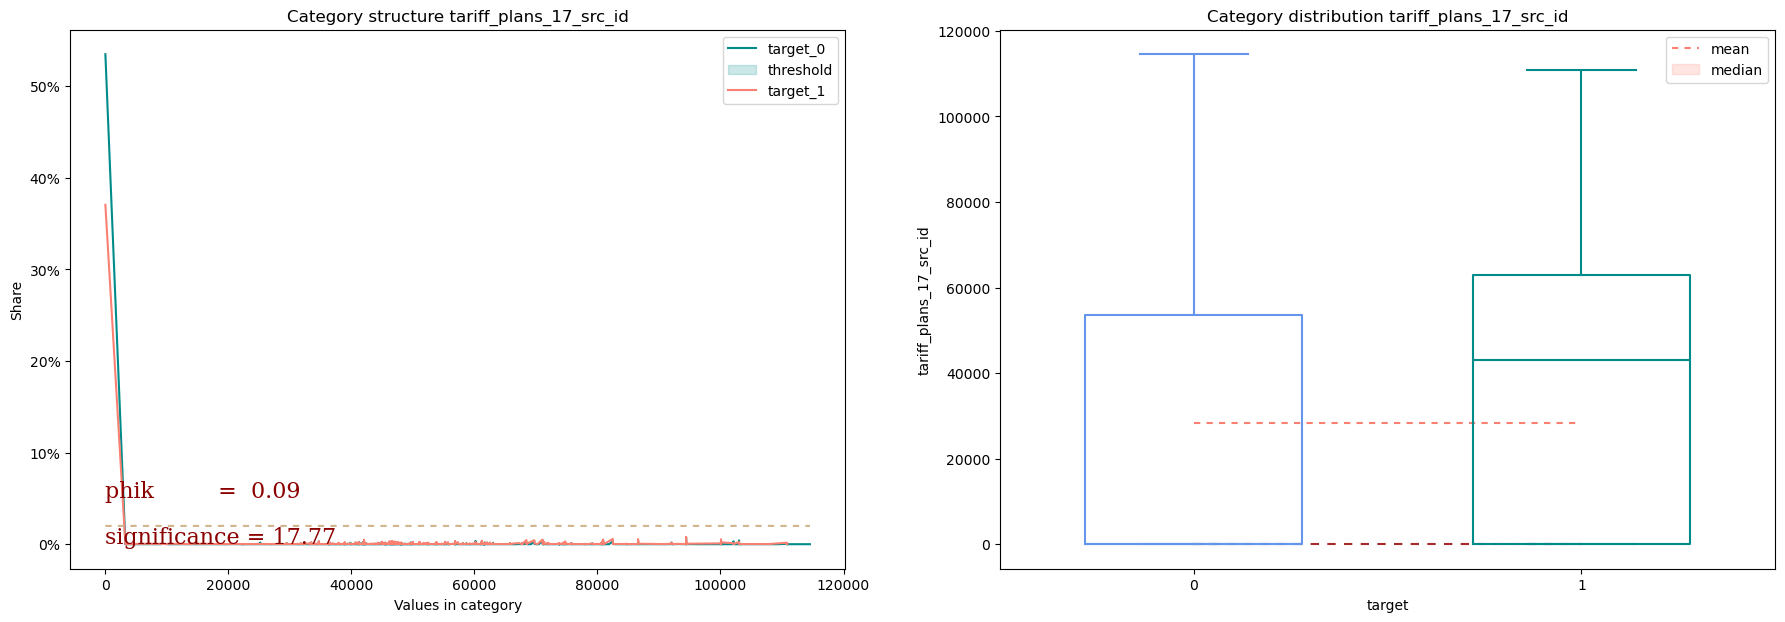

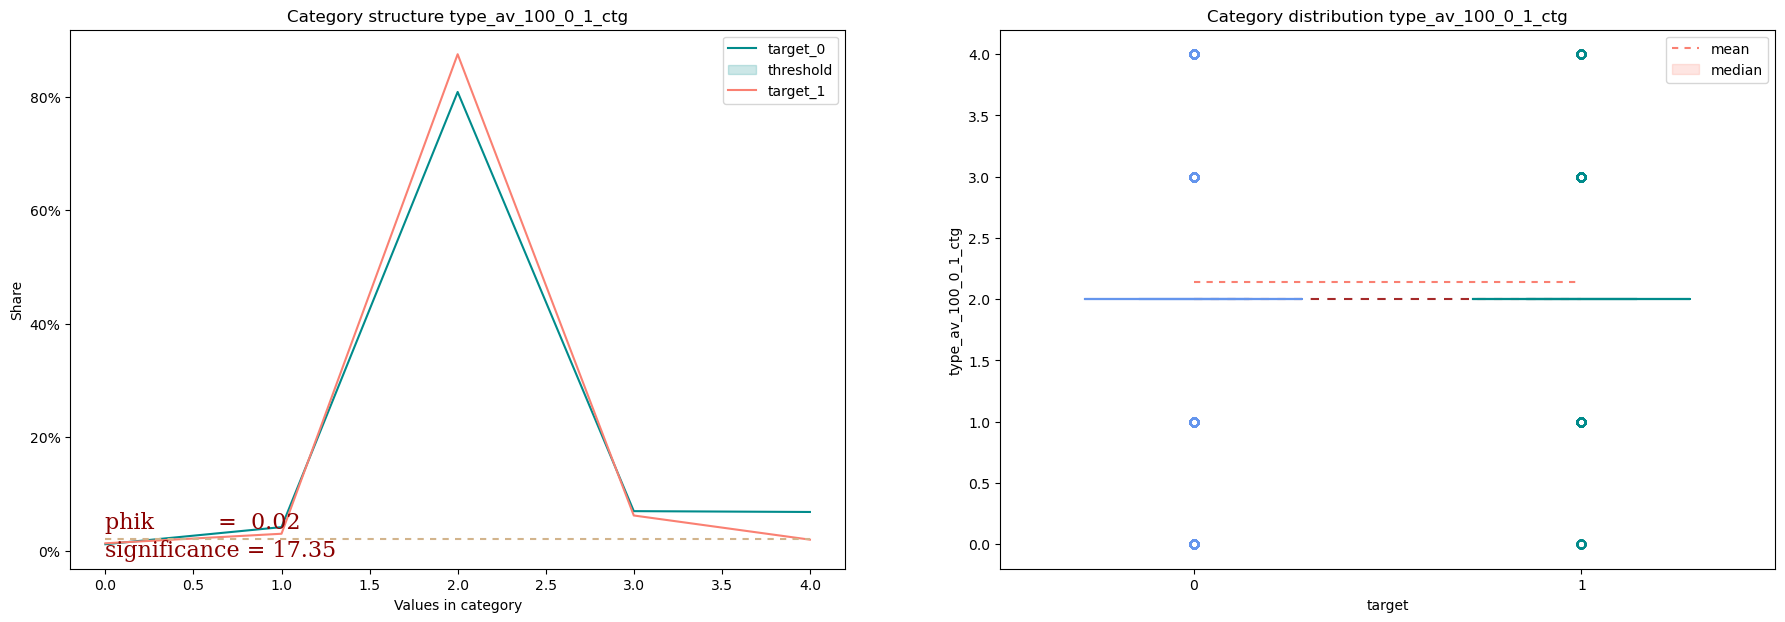

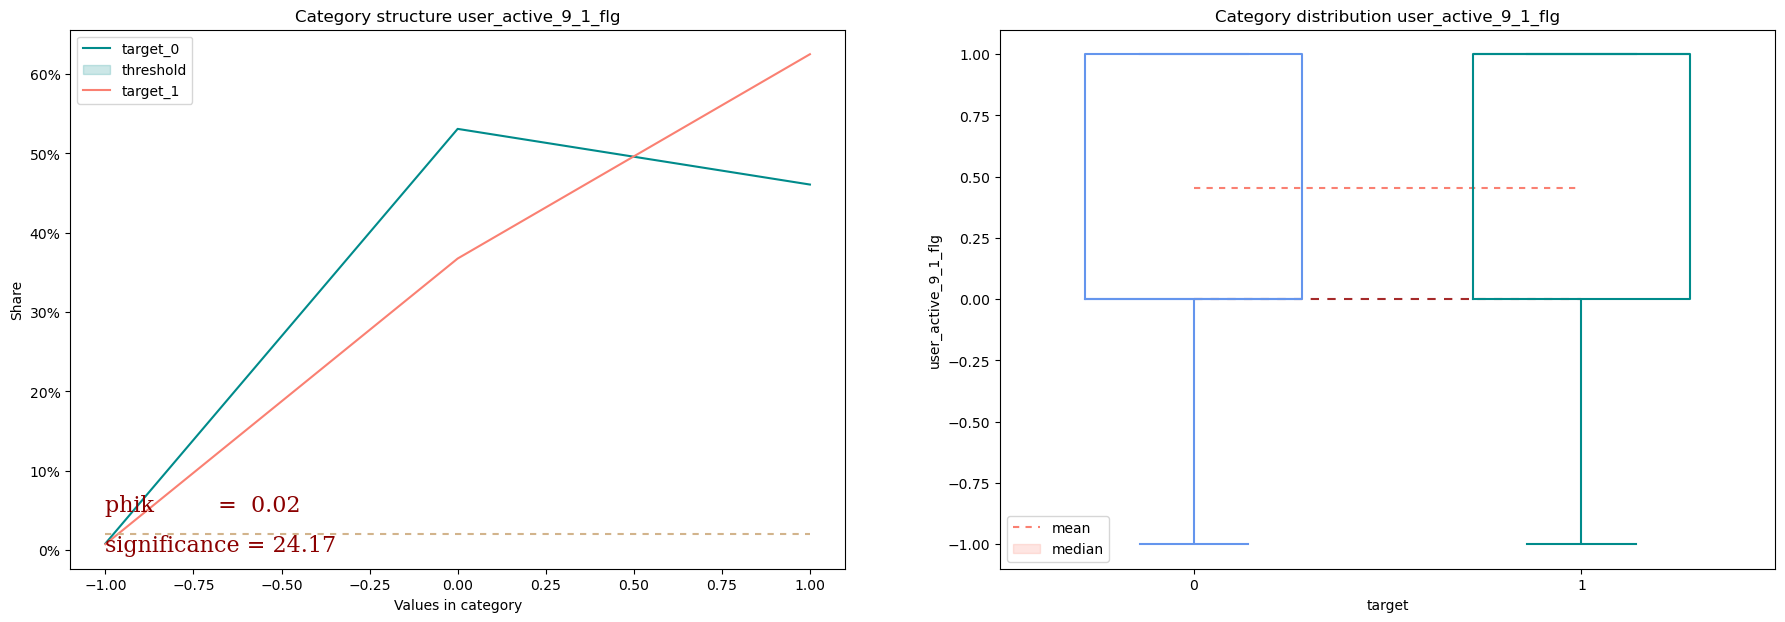

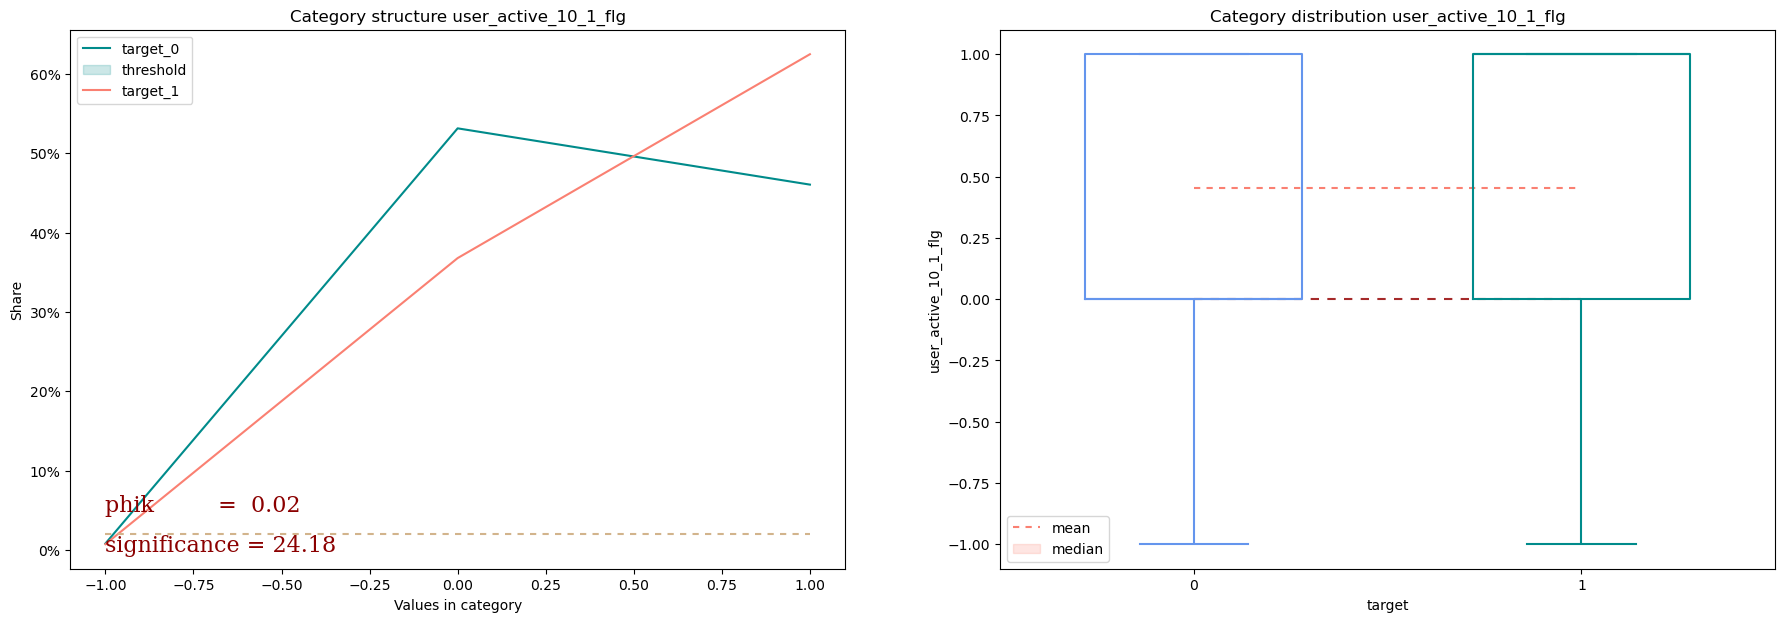

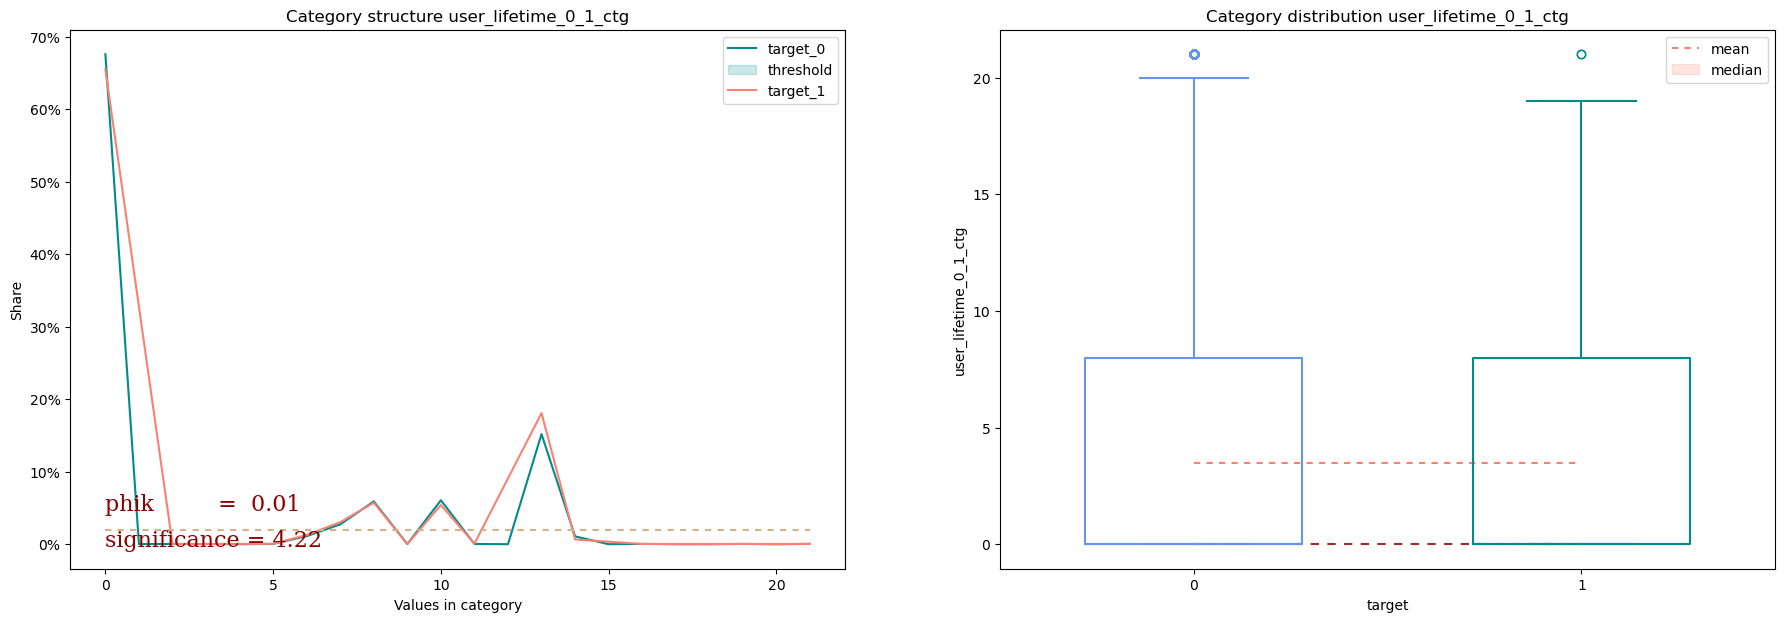

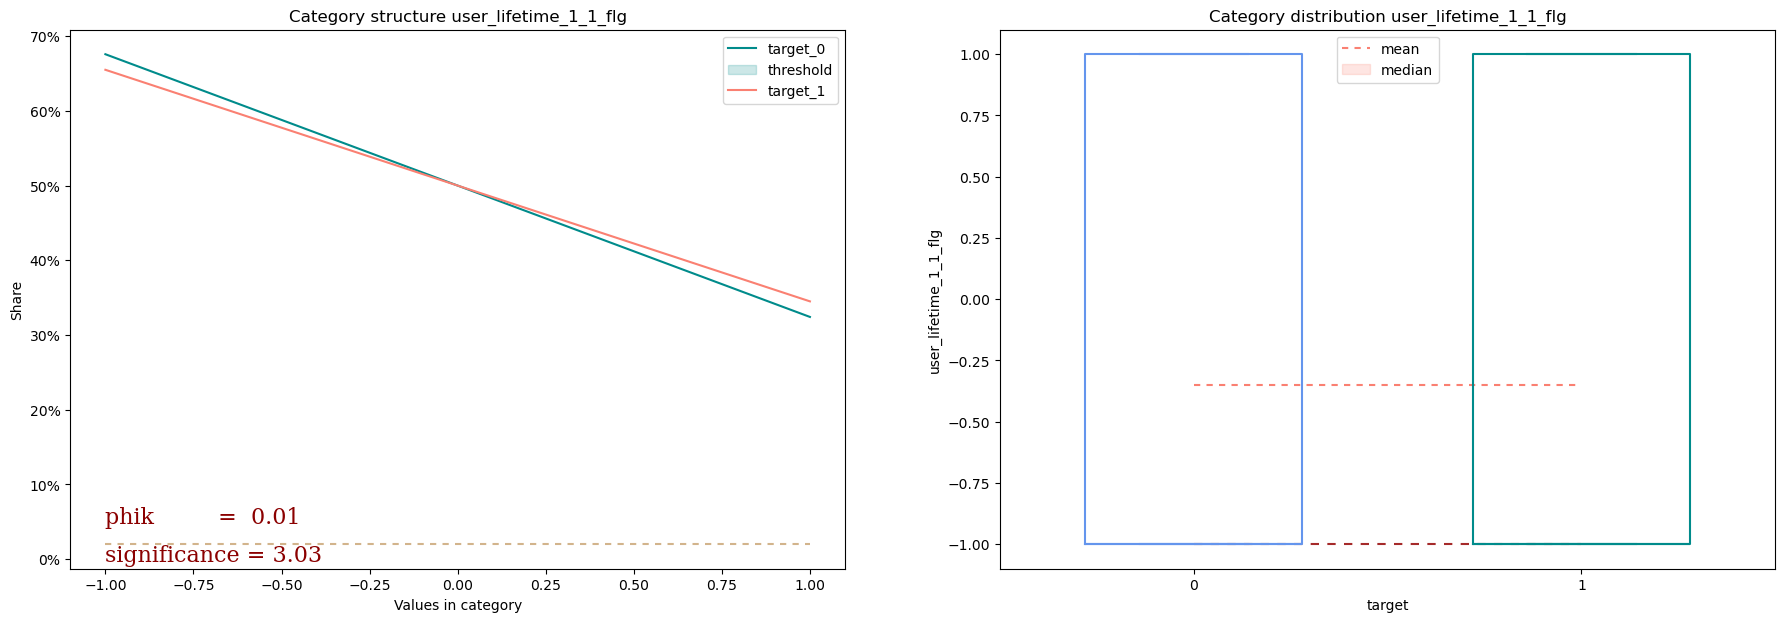

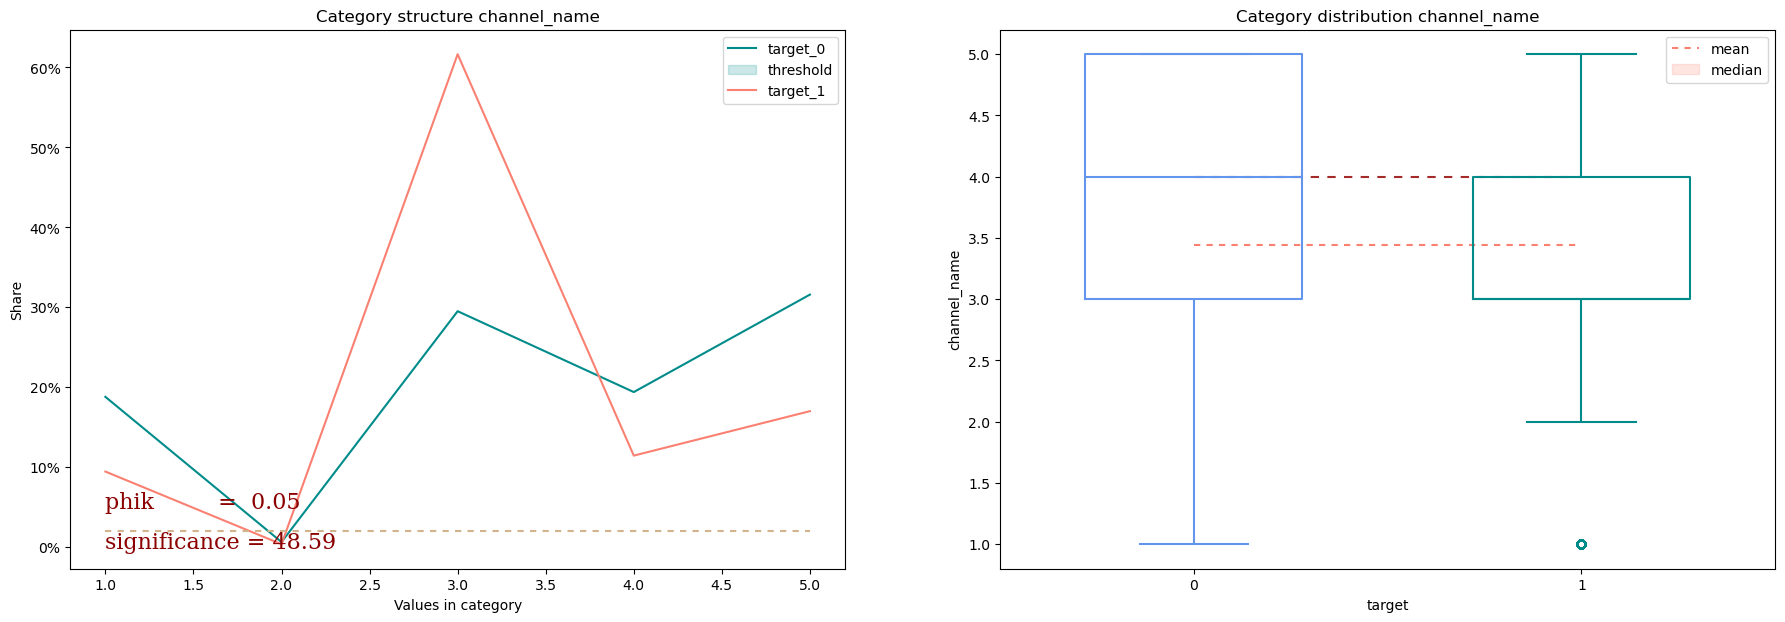

In [15]:
for column in categorial_features:
    mean, median = data[column].mean(), data[column].median()
    show_base_info_category_columns(data, column)

In [16]:
def show_base_info_numerical_columns(df, column):
    plt.figure(figsize=(25, 5))
    x, y = df[['target', column]].T.values
    font = {'family': 'serif','color': 'darkred','weight': 'normal','size': 16}
    
    ax = plt.subplot(1, 3, 1)
    plt.title(f'Boxplot feature {column}')
    sns.lineplot(x = [0,1], y = mean, style=True, dashes=[(3,3)], color = 'salmon')
    sns.lineplot(x = [0,1], y = median, style=True, dashes=[(4,4)], color = 'brown')
    sns.boxplot(df, x = 'target', y = column, palette = ['cornflowerblue', 'darkcyan'], fill=False, gap=.3)
    sns.stripplot(df, x = 'target', y = column,color='bisque', alpha=0.3)
    plt.legend(['mean', 'median'])

    ax = plt.subplot(1, 3, 2)
    sns.histplot(data=df, x=column, color='cornflowerblue', alpha = 0.7, bins = 50)
    plt.axvline(x=mean, color='salmon', linestyle = '--')
    plt.axvline(x=median, color='brown', linestyle = '--')
    plt.legend(['mean', 'median'])
    plt.title(f'Distribution feature {column}')
    plt.text(df[column].max(), 15000, f'Medcouple sample =  %.2f'%medcouple(df[column].sample(n=20000, random_state=RANDOM_SEED)), \
             fontdict=font,  ha='right', va='center')
    
    plt.show()
    print('\033[1mcorr         =  %.2f'%df['target'].corr(df[column]))
    print('\033[1mphik         =  %.2f'%phik.phik_from_array(x, y))
    print('\033[1msignificance = %.2f'%phik.significance_from_array(x, y)[1])

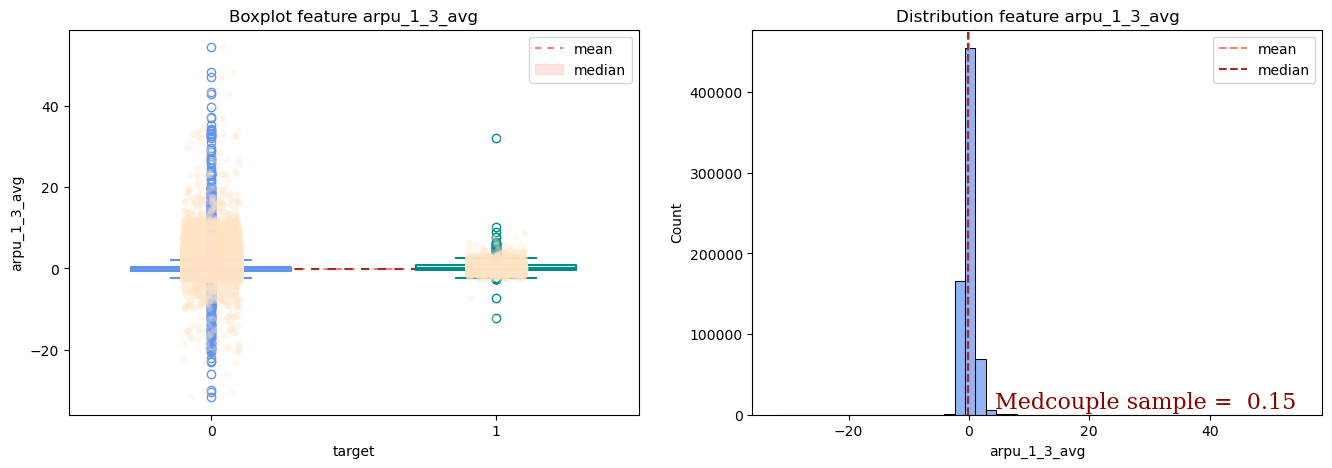

corr         =  0.02
phik         =  0.24
significance = 22.25


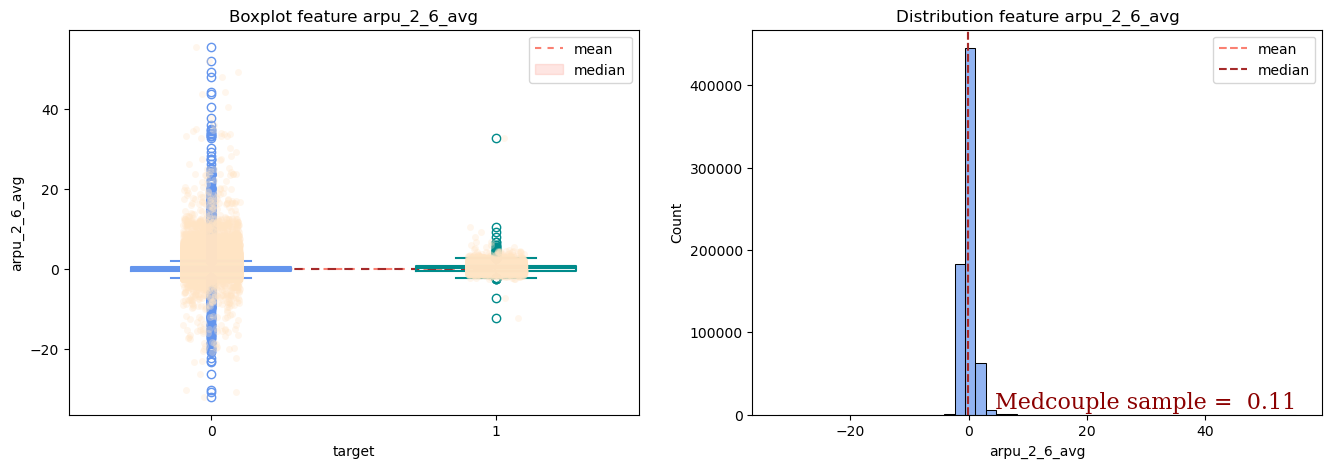

corr         =  0.02
phik         =  0.25
significance = 23.63


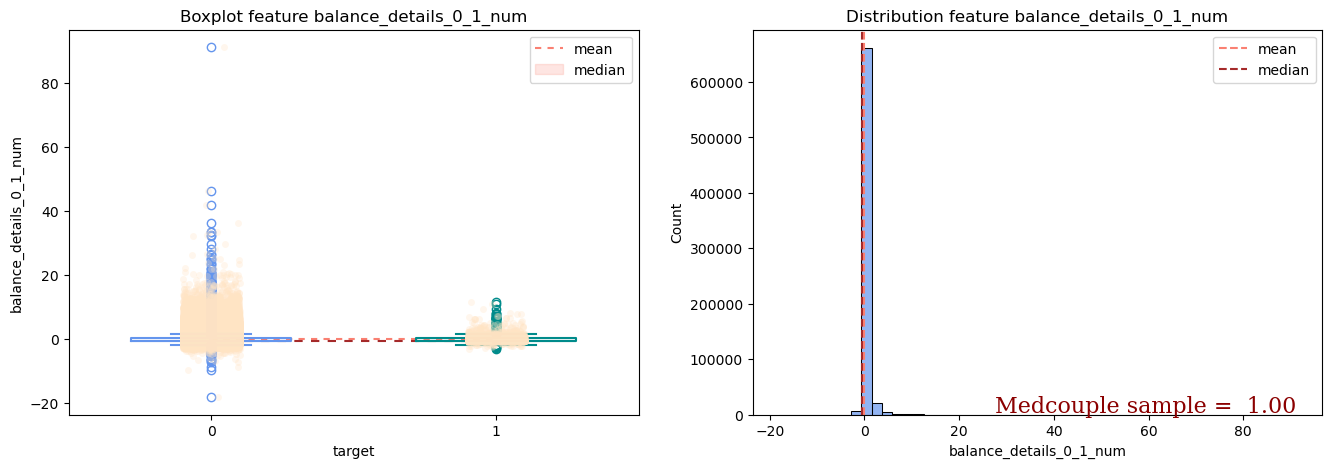

corr         =  -0.00
phik         =  0.00
significance = 4.19


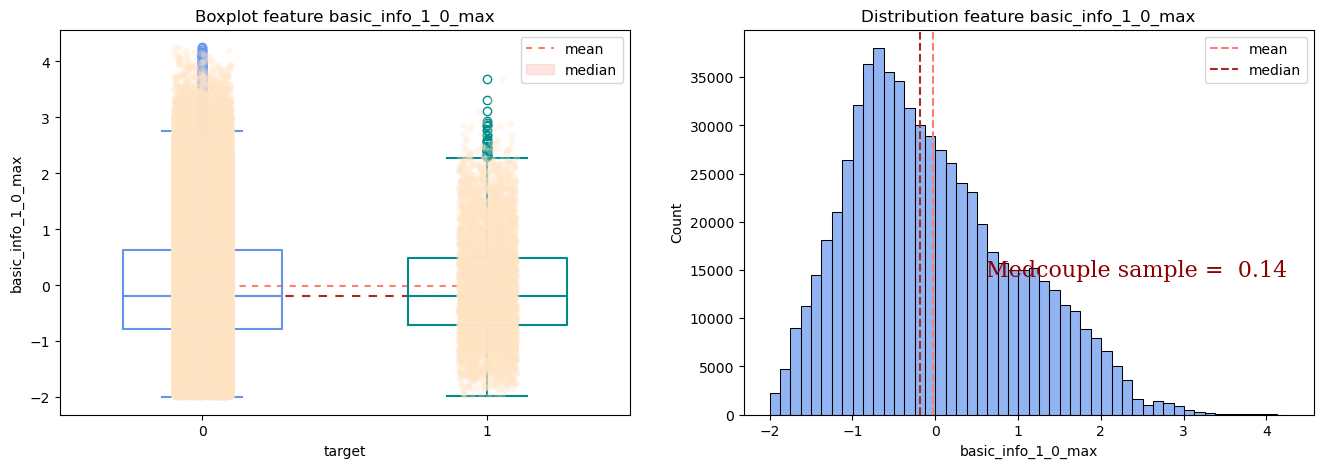

corr         =  -0.00
phik         =  0.00
significance = 1.61


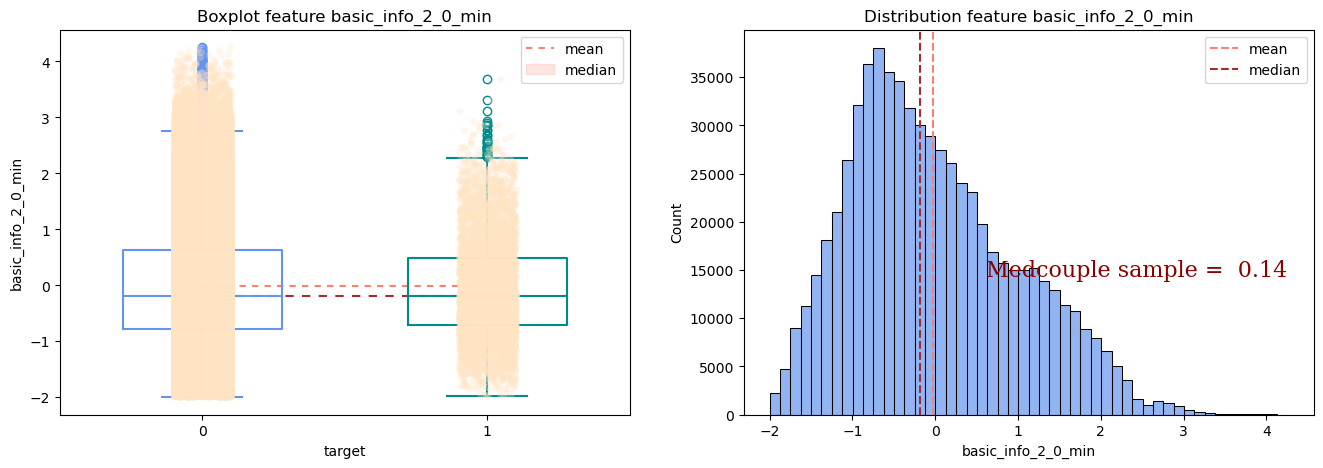

corr         =  -0.00
phik         =  0.00
significance = 1.63


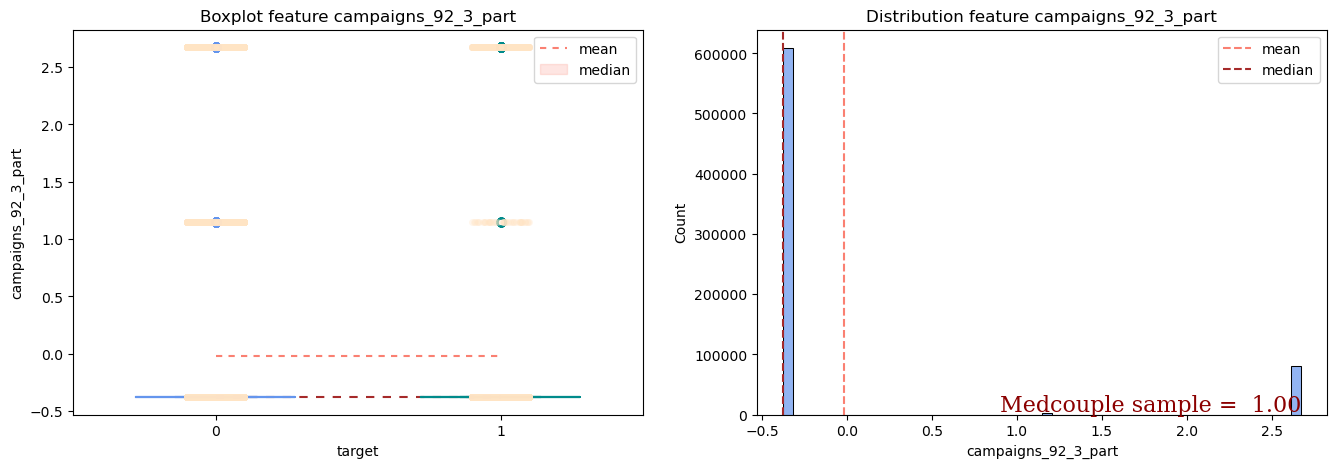

corr         =  0.01
phik         =  0.02
significance = 12.63


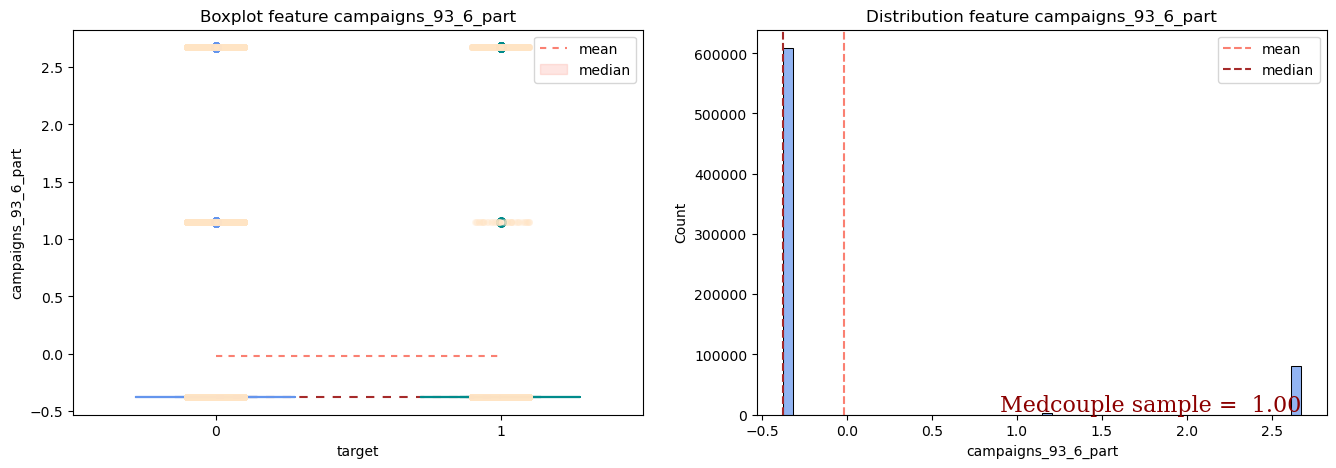

corr         =  0.01
phik         =  0.02
significance = 12.63


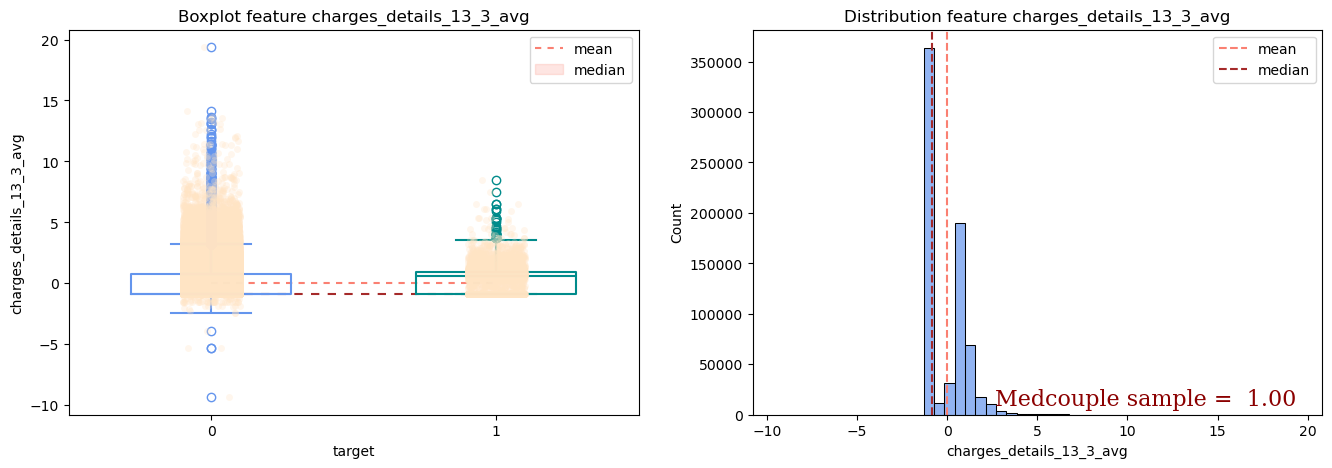

corr         =  0.03
phik         =  0.27
significance = 29.19


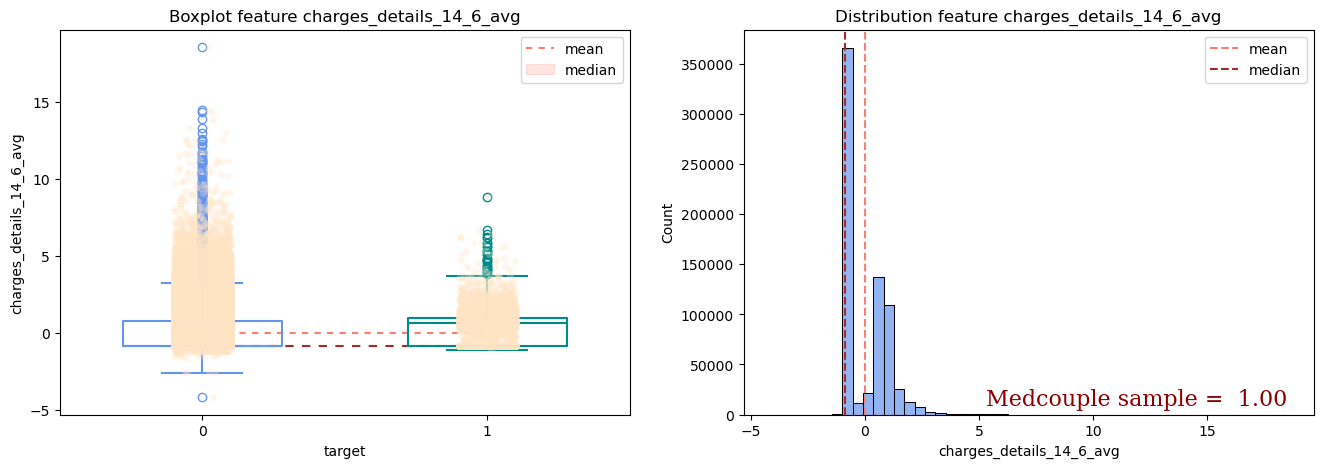

corr         =  0.03
phik         =  0.34
significance = 33.70


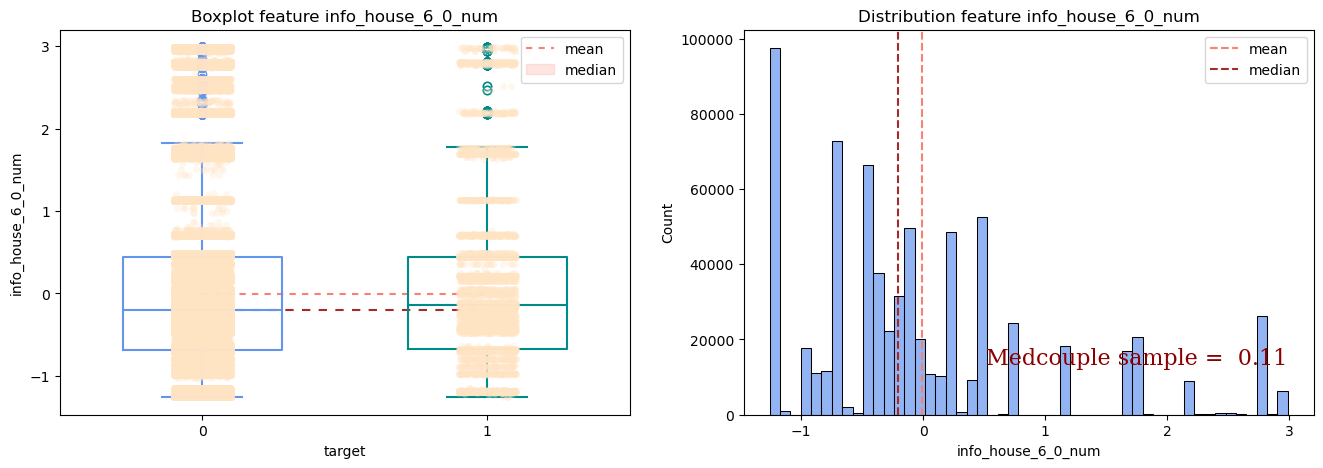

corr         =  0.01
phik         =  0.16
significance = 7.66


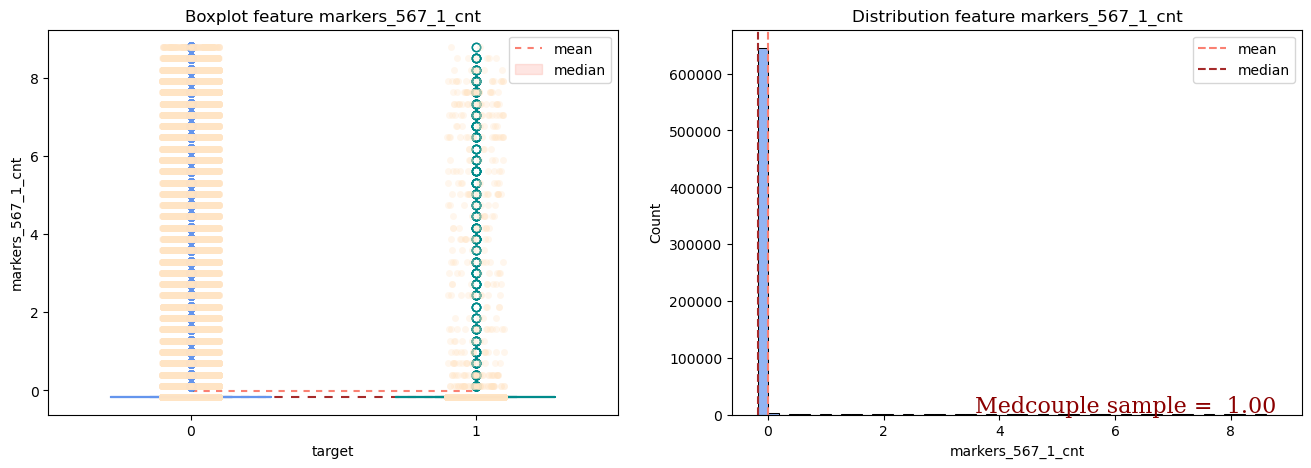

corr         =  0.01
phik         =  0.02
significance = 9.35


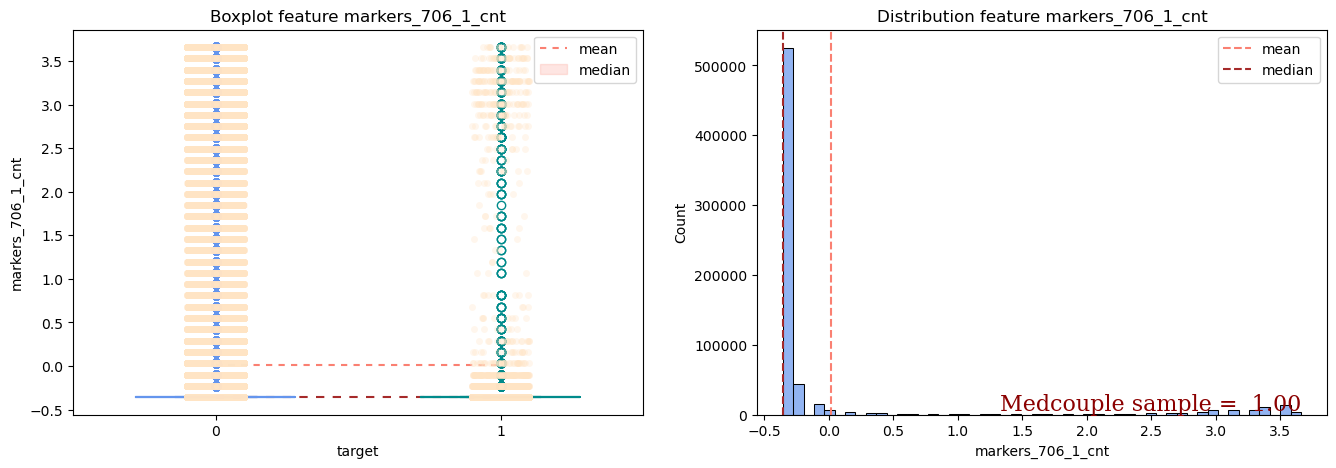

corr         =  -0.01
phik         =  0.02
significance = 11.94


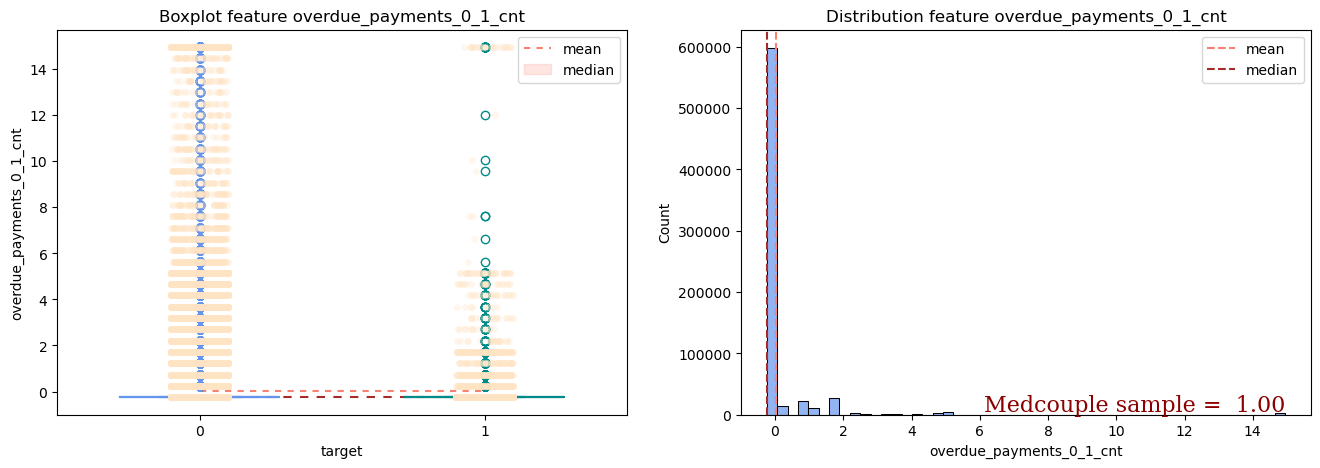

corr         =  0.00
phik         =  0.01
significance = 5.67


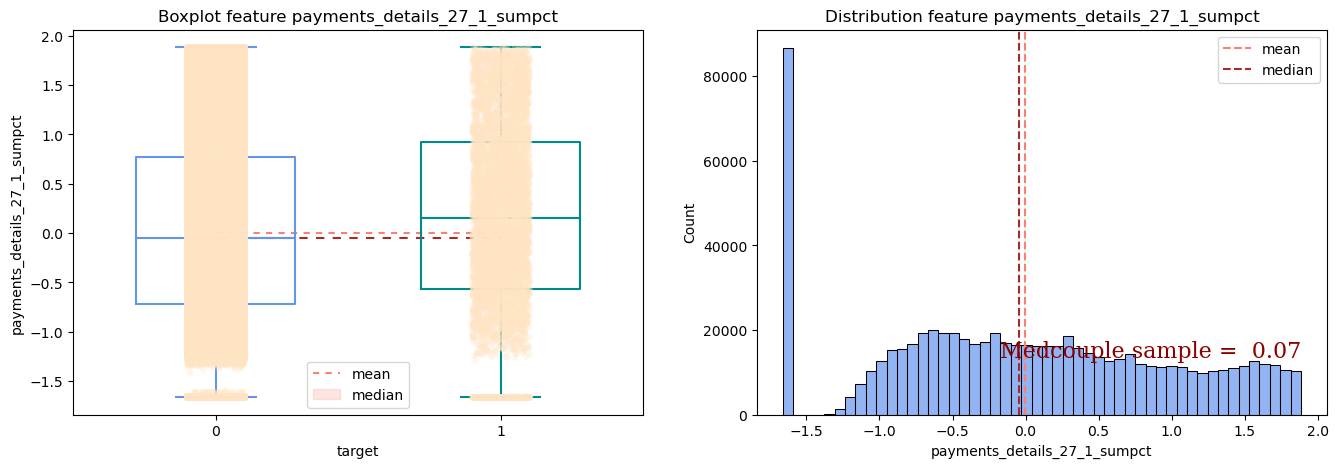

corr         =  0.01
phik         =  0.39
significance = 30.11


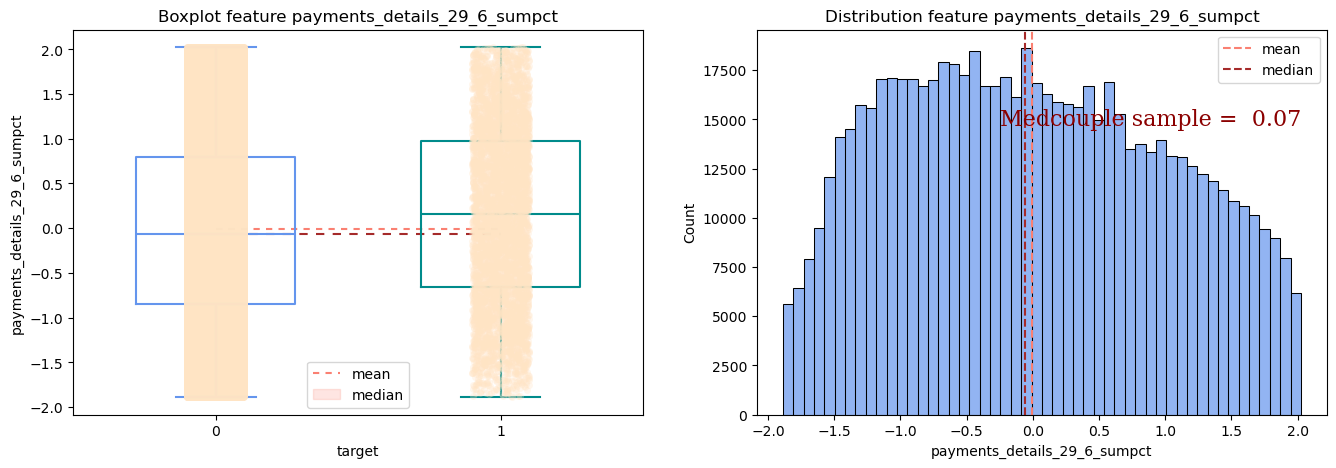

corr         =  0.01
phik         =  0.51
significance = 31.96


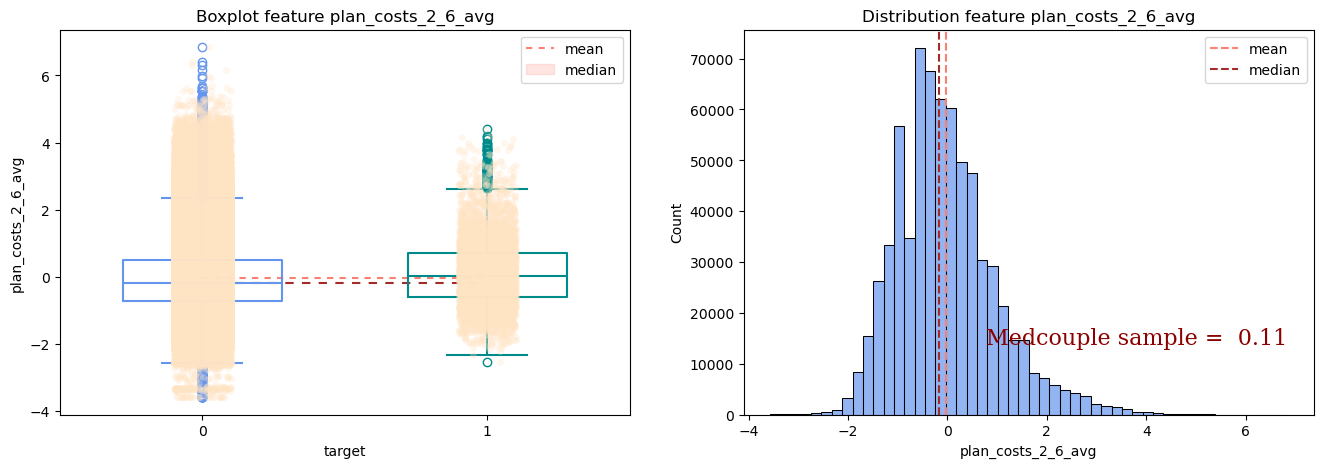

corr         =  0.02
phik         =  0.06
significance = 10.34


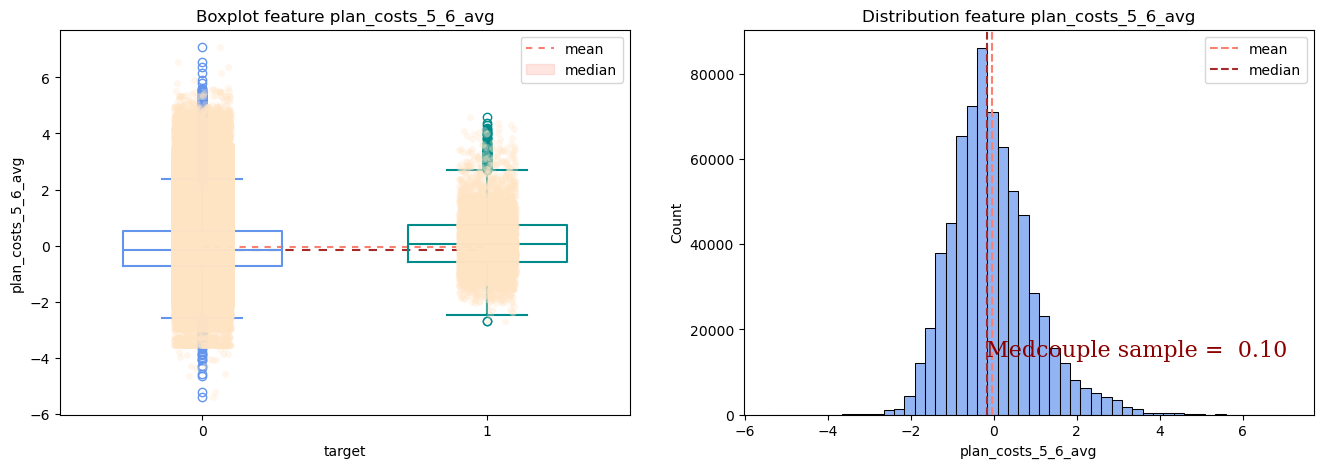

corr         =  0.02
phik         =  0.07
significance = 11.78


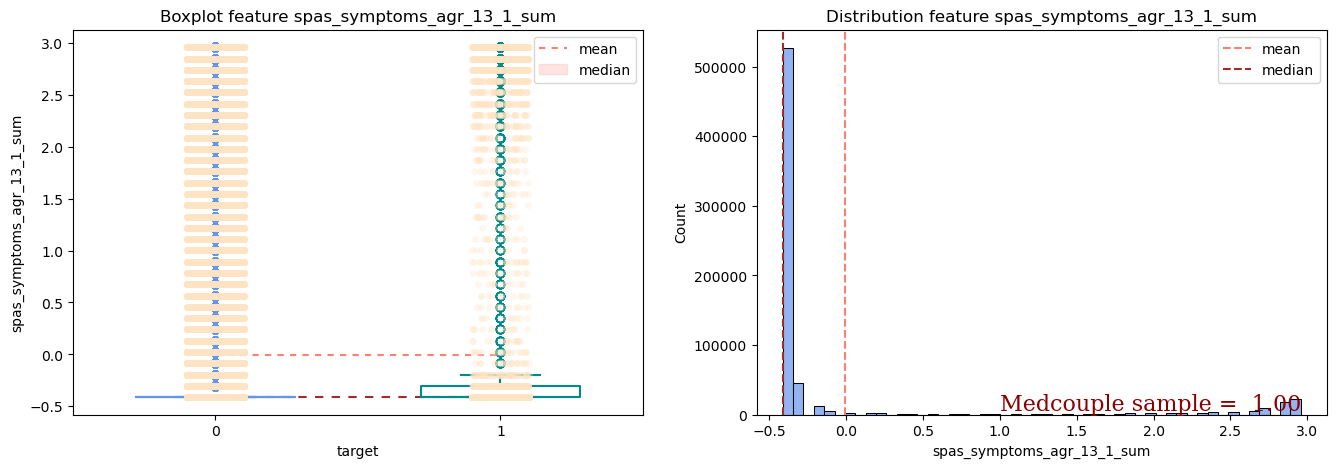

corr         =  0.02
phik         =  0.03
significance = 17.13


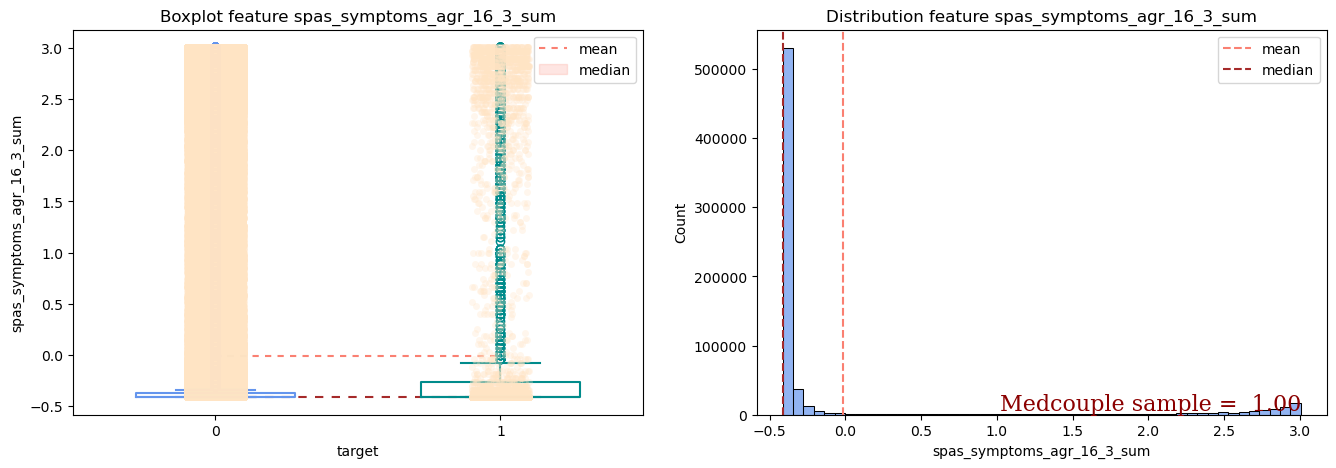

corr         =  0.02
phik         =  0.03
significance = 16.74


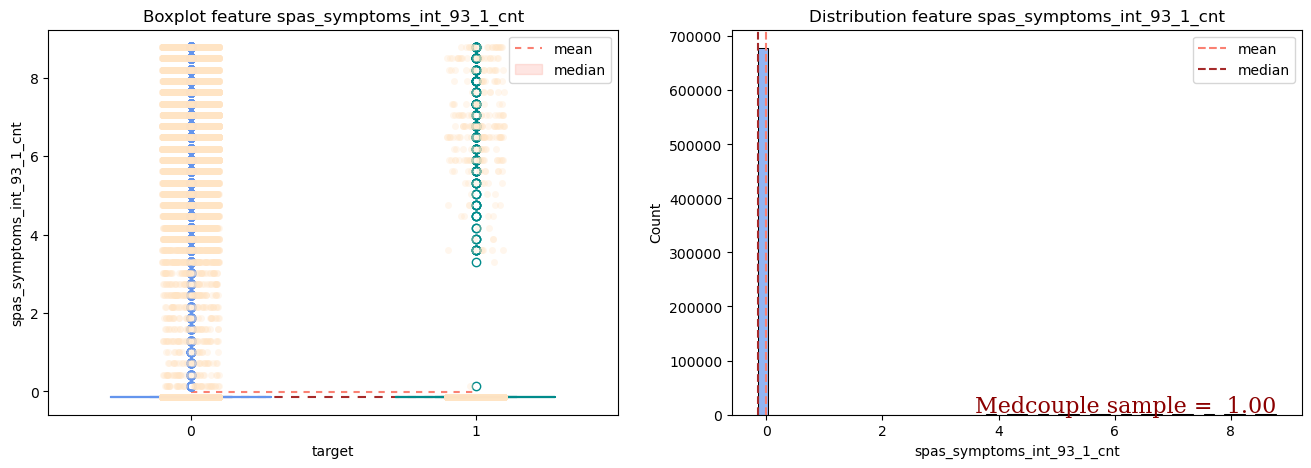

corr         =  0.02
phik         =  0.02
significance = 11.60


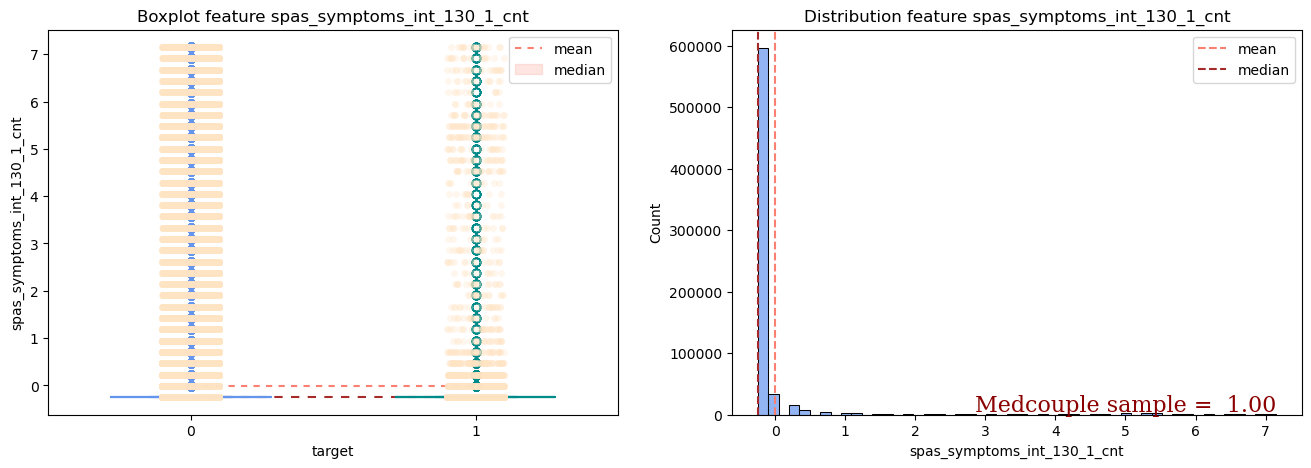

corr         =  0.02
phik         =  0.03
significance = 15.42


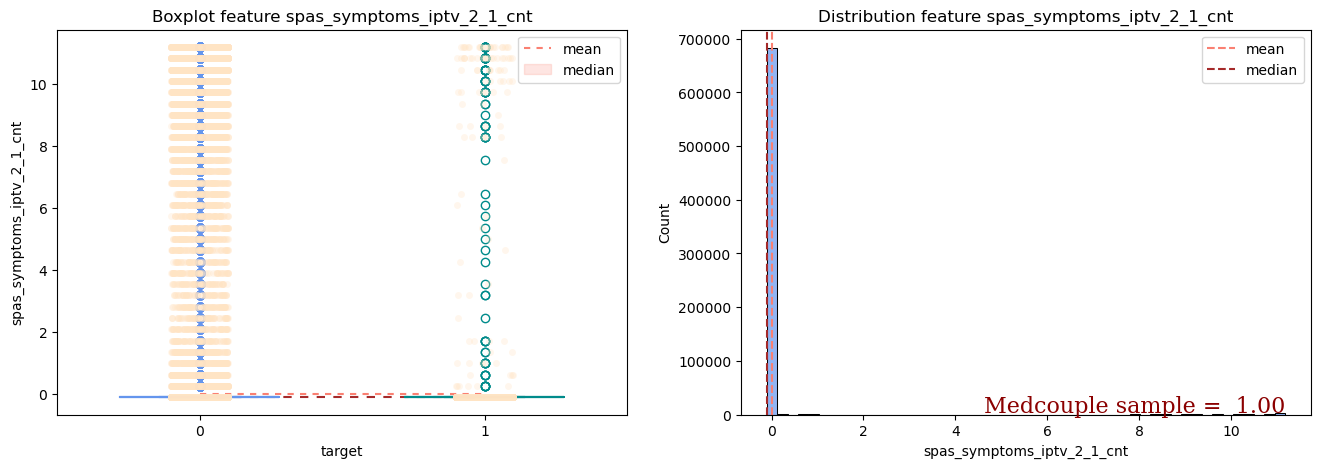

corr         =  0.00
phik         =  0.01
significance = 4.06


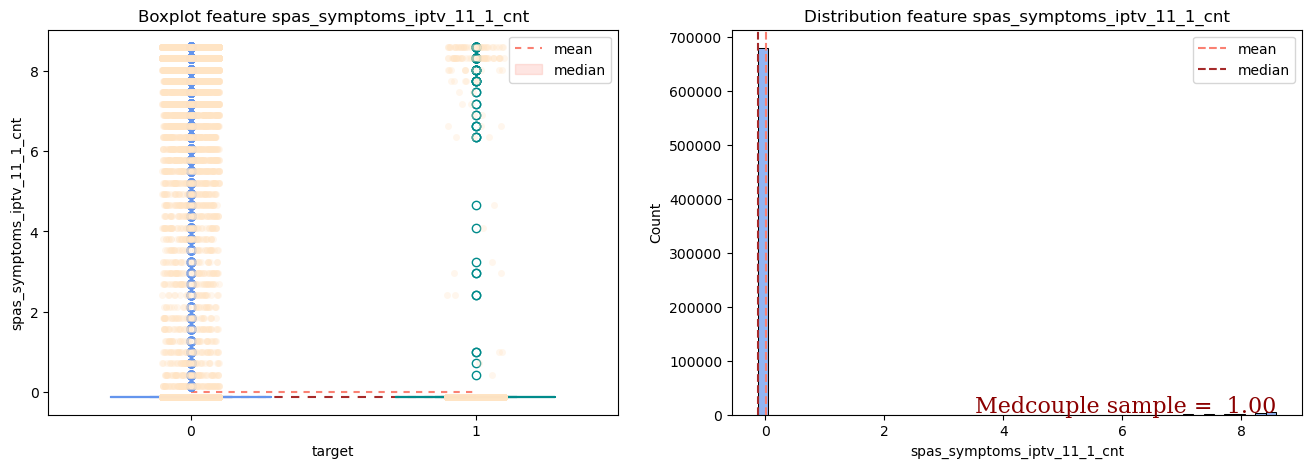

corr         =  0.00
phik         =  0.01
significance = 4.41


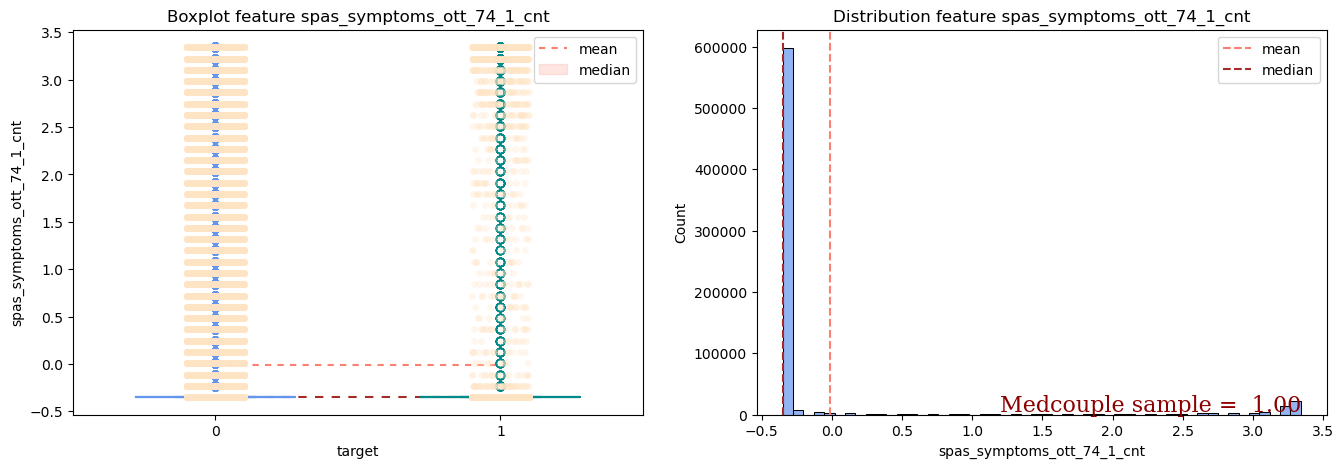

corr         =  0.02
phik         =  0.03
significance = 16.74


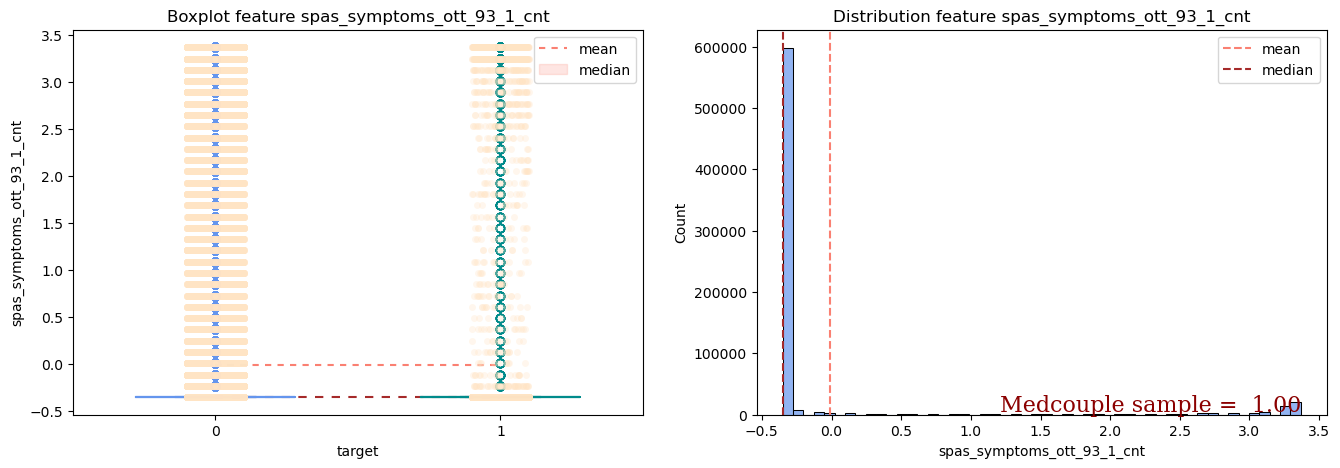

corr         =  0.02
phik         =  0.03
significance = 16.78


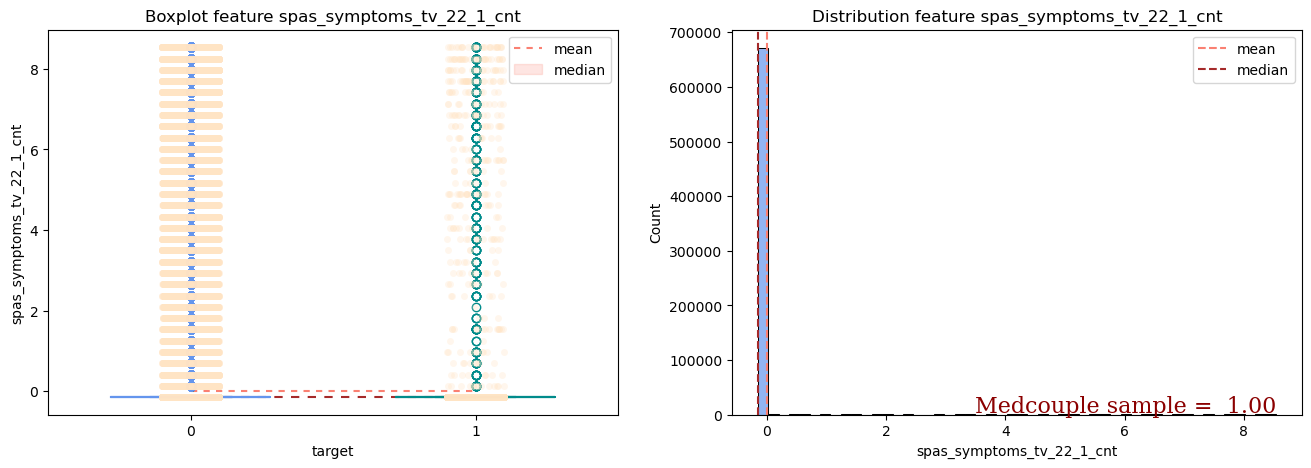

corr         =  0.02
phik         =  0.02
significance = 11.72


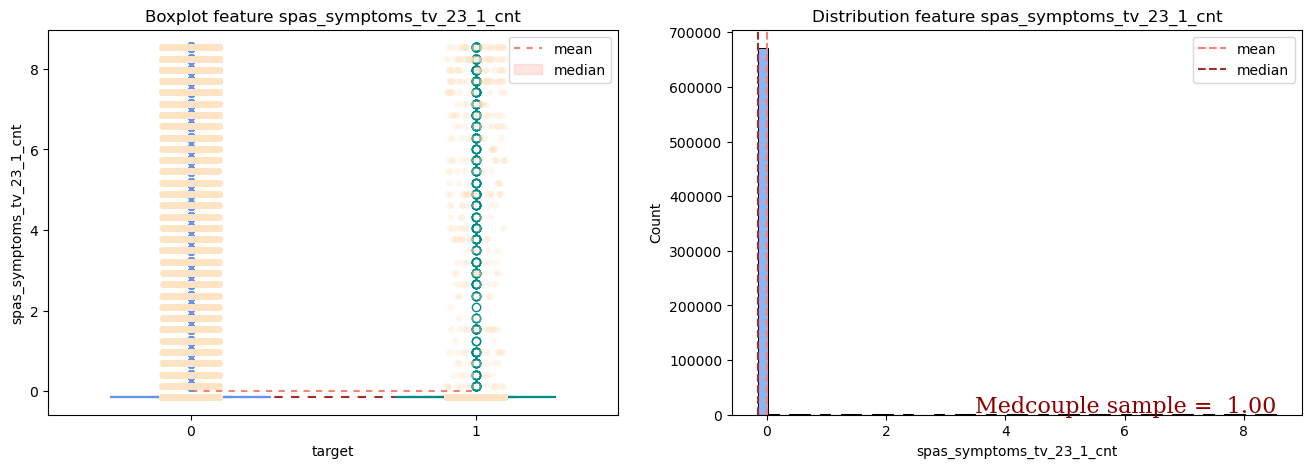

corr         =  0.02
phik         =  0.02
significance = 11.73


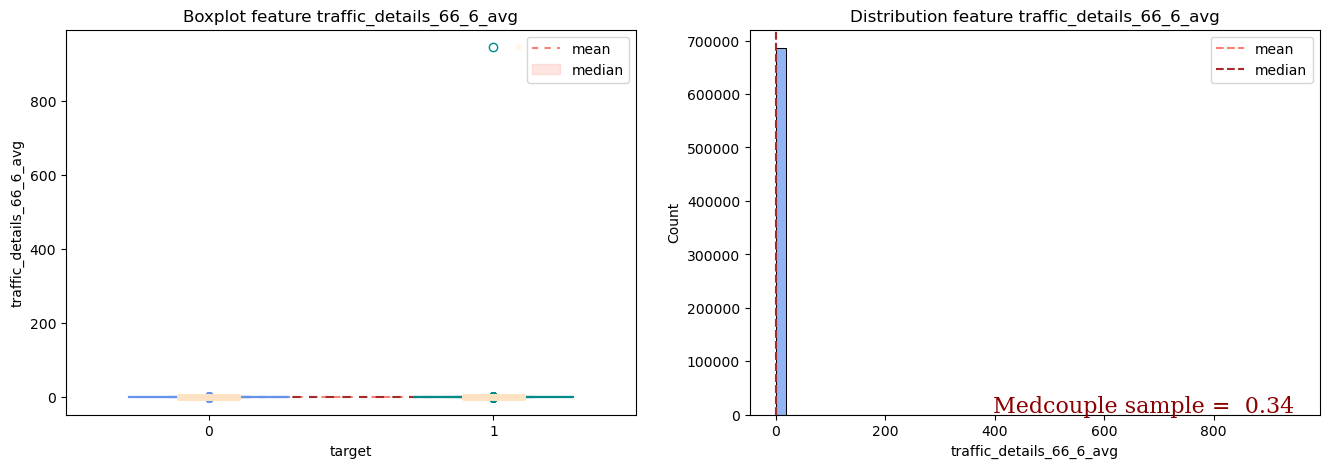

corr         =  0.01
phik         =  0.12
significance = 32.34


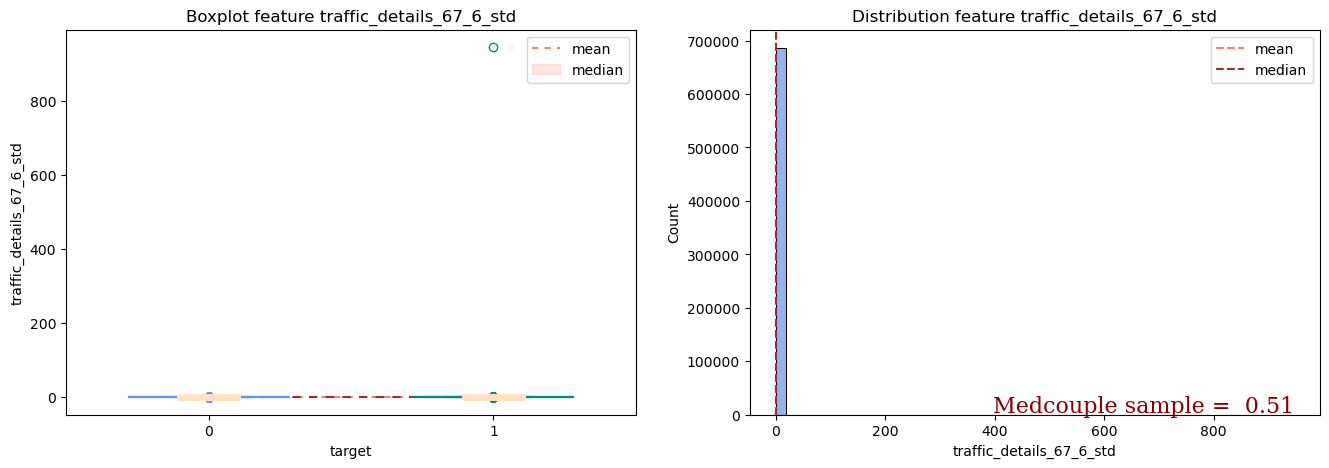

corr         =  0.01
phik         =  0.13
significance = 32.35


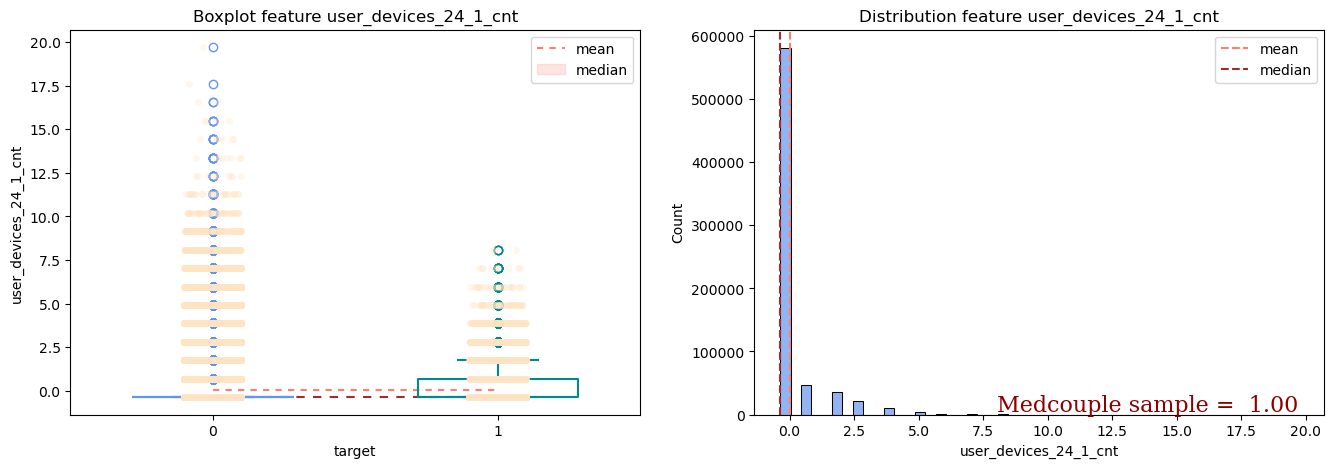

corr         =  0.02
phik         =  0.03
significance = 17.98


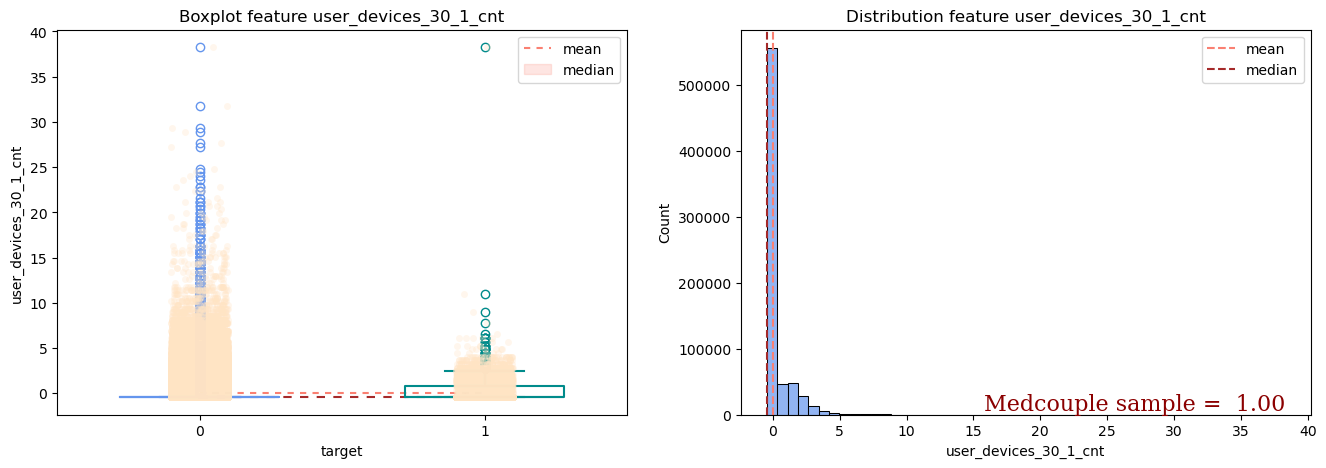

corr         =  0.02
phik         =  0.03
significance = 18.47


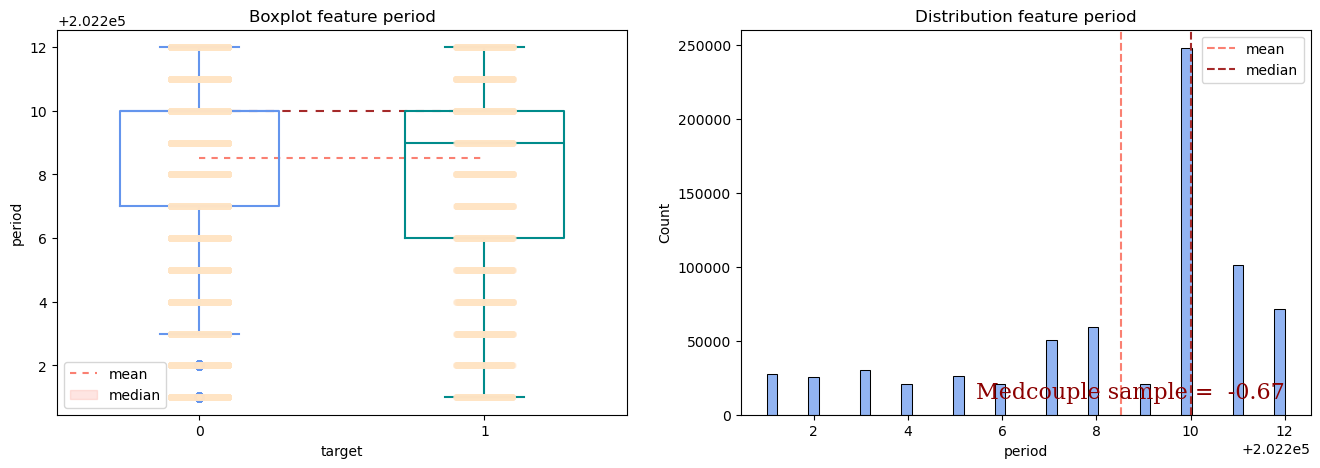

corr         =  -0.02
phik         =  0.04
significance = 24.96


In [17]:
for column in numerical_features:
    mean, median = data[column].mean(), data[column].median()
    show_base_info_numerical_columns(data, column)

## Статегия обработки и исключения

Итак, у нас есть данные о распределении, зависимости, влияния и важности признаков. Проанализируем все в комплексе. Рассматривать будем в разрезе важности для классификатора CatBoost.

 - продажи чаще всего происходят из **канала** 3 (более 60%). Но иногда срабатывают и другие коммуникации. Причем это не разовые продажи, т.е. мы не может расценивать эти данные как выбросы или исключения. 
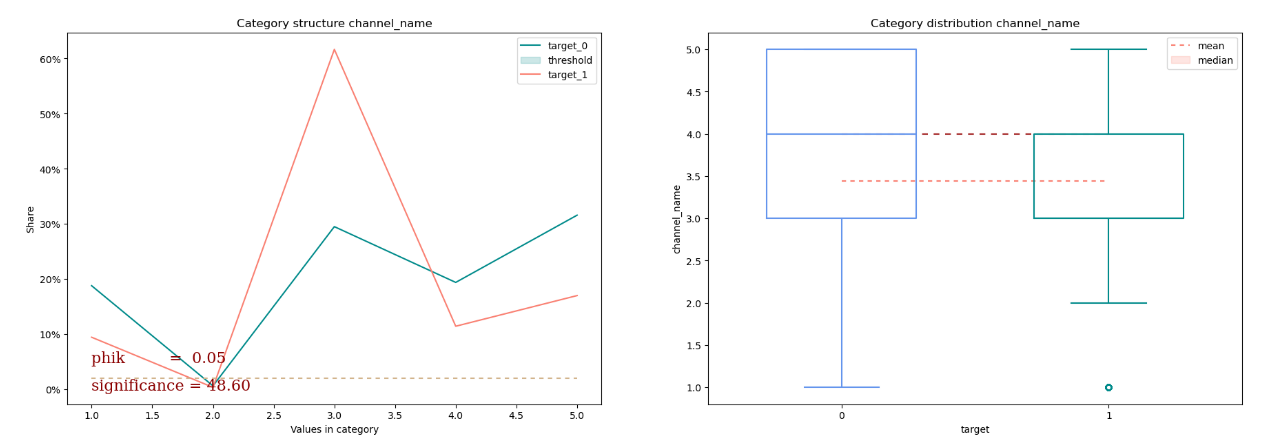
 - **type_av_100_0_1_ctg**. Основная доля абонетов имеет категорию 2, и все таки принадлежность к другим категориям оказывает значительное влияние на прогнозирование - чем выше категория, тем ниже вероятность продаж. Здесь, гипотеза, ранее выдвинутая в процессе оценки влияния признаков на прогноз, так же подтверждается данными.
 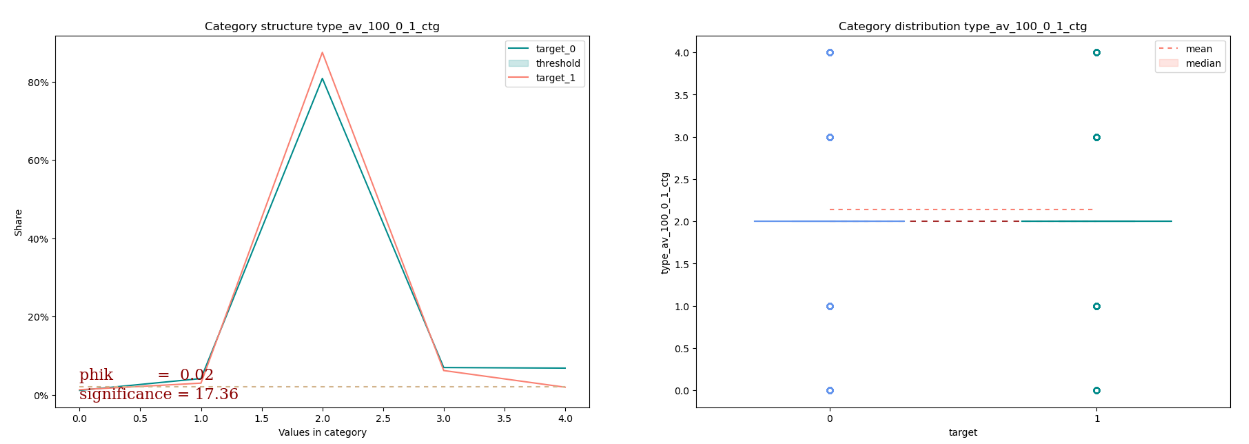
  - **communication_availability_30_1_flg**. Доступность связи. Нет противоречия в реальных данных и оценке влияния - действительно, чем при отрицательном значении  флага вероятность продажи уменьшается.
 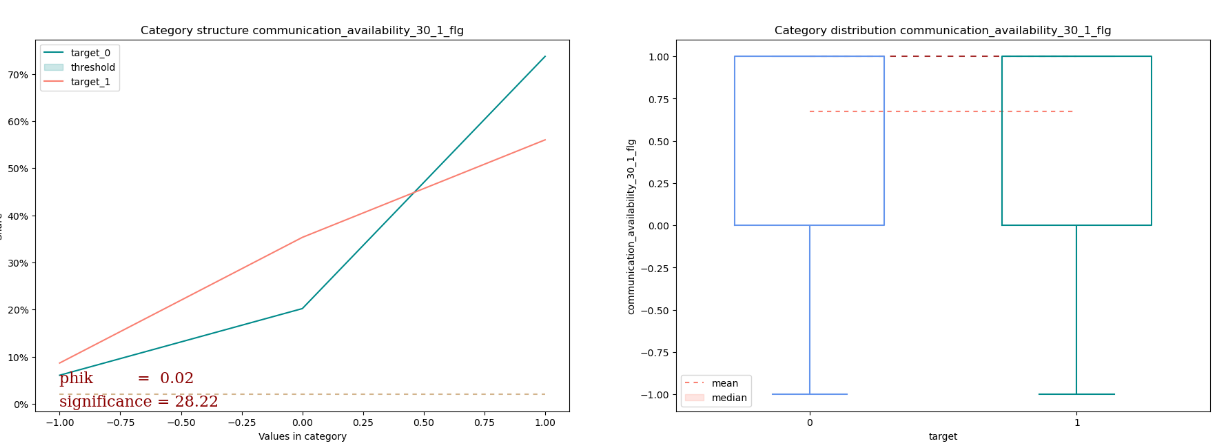  
 
 Эти три признака в стуктуре важности для модели формируют около 50%. 
 
  - **traffic_details_66_6_avg**. Здесь все сложнее. На графике мы можем увидеть, что была совершена разовая продажа при значениях свыше 800 пунктов. Мы не может выкинуть эти данные или обработать как выбросы, потому что они имеют сильное влияние на точность прогноза модели, но мы можем попытаться их как-то сгладить. Следует отметить, что эта мера носит временный характер и уместна ровно до того момента пока по более высоким тарифным значениям не будет накоплено больше данных. **traffic_details_67_6_std** - очевидно, что это таже покупка, но чтобы сильно не искажать выброс, с этим признаком делать ничего не будем.
  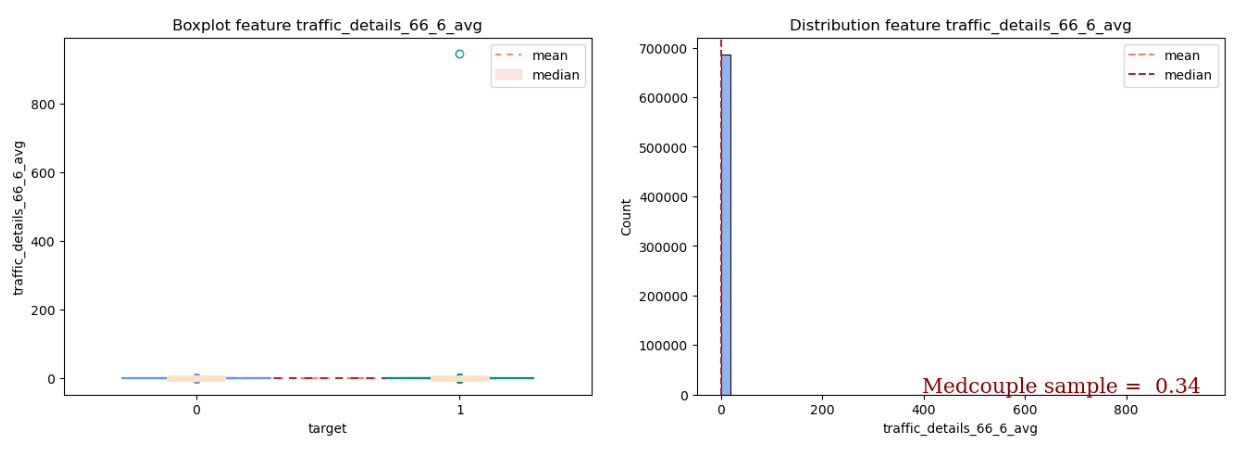
 - по **706 маркеру** оценка влияния отработала не совсем корректно. Согласно анализу большие значения должны уменьшать верояность покупки. Как мы видим из графика это не совсем так: покупки конечно совершаются чаще при значениях до 0, но и при маркере свыше двух они происходят достаточно часто, а том от 0 до 2 - скорее носят эпизодических характер. В связи с этим была выдвинута гипотеза, что и модель может интерпретировать эти значения не корректно. Попробуем увеличить разрыв между большими и малыми данными, чтобы модель лучше уловила эту взяимосвязь.
 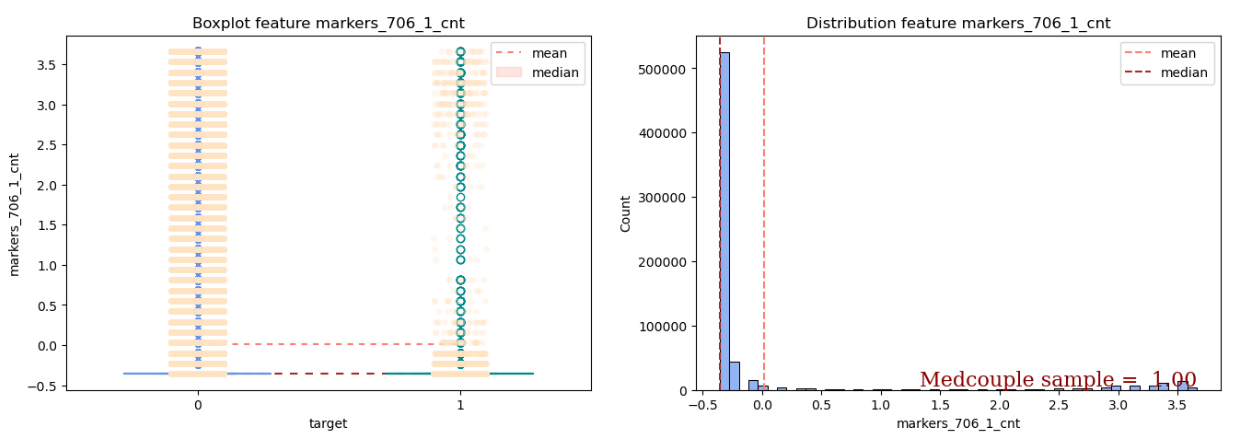
 - признаки с маркировкой **arpu** имеют более высокую зависимость (в сравнении с другими), но не очень заметны для модели. По ним есть смысл немного увеличить значения, например возведя их в квадрат.
 - дополнительно была рассчитана линейная корреляция для всех числовых признаков (в тетради код не приведен, расчет шел по **всем** числовых колонкам исходного датасета), и признаки, которые лучше всего коррелируют с целевым были добавлены в нашу выборку.
 - числовые и категориальные признаки, имеющие зависимости с тагрегом, близкие к 0, и по которым совсем отсутствовала зависимость от экстремальных (нетипичных) даннных были удалены.
 - нормализация остальных числовых признаков со смещением распределения не дала прироста, что в принципе ожидаемо - бустинги прекрасно работают и с сырыми данными.
 - в процессе выбора признаков, на первые позиции по влиянию то и дело выходил признак **user_devices_30_1_cnt**. 
 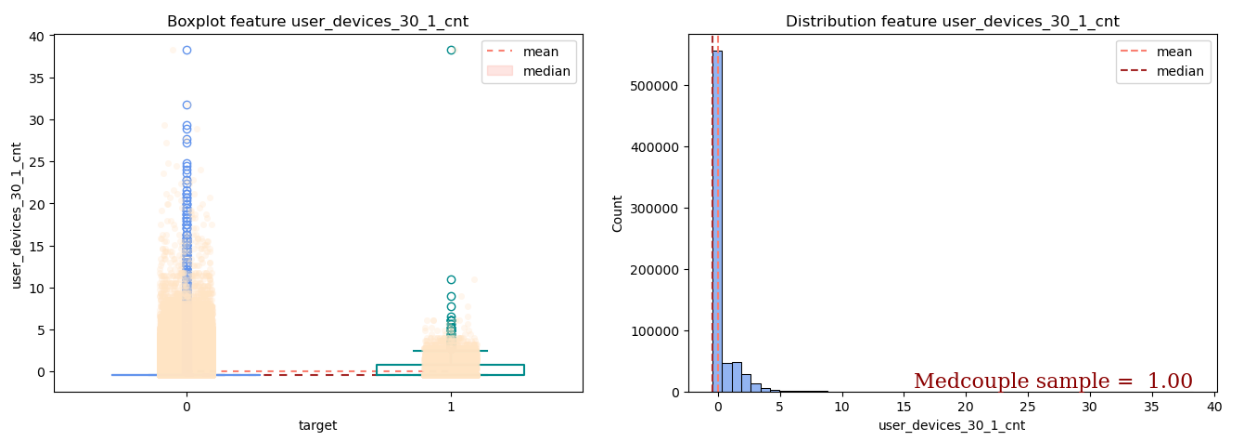 В нем тоже присутствуют данные с экстремальными значениями, при которых была совершена покупка и для качественного прогноза этот признак оказался важен. Чтобы сохранить его и в тоже время и уменьшить влияние на отрицательную оценку прогноза было принято решение увеличить разрыв между покупками при высоких значениях (выбросами) и всеми остальными, что положительно отразилось на прогнозах модели.

## Обучение по подобранным признакам

Теперь нас есть итоговый набор признаков. Присутпим к обучению.

In [18]:
list_features_new = ['agreement_type_0_0_ctg', 'area_1_0_ctg', 'arpu_1_3_avg',
       'arpu_2_6_avg', 'autopay_8_0_ctg', 'autopay_3_1_flg',
       'balance_details_0_1_num', 'basic_info_1_0_max', 'basic_info_2_0_min',
       'campaigns_92_3_part', 'campaigns_93_6_part', 
       'charges_details_13_3_avg', 'charges_details_14_6_avg', 'charges_details_12_1_sum', 'charges_details_1_3_avg',
       'cities_1_0_ctg', 'cities_2_0_ctg',
       'communication_availability_17_1_flg',
       'communication_availability_30_1_flg', 'deact_react_7_1_ctg', 
       'deact_react_10_1_ctg', 'exist_tariff_0_1_flg', 'exist_tariff_2_1_flg',
       'info_house_6_0_num', 'info_house_9_0_flg', 'markers_567_1_cnt',
       'markers_706_1_cnt', 'materials_details_10_1_flg', 
       'materials_details_20_1_flg', 'materials_details_15_1_ctg', 'migrant_0_1_flg', 
       'payments_details_27_1_sumpct', 'overdue_payments_0_1_cnt', 
       'payments_details_29_6_sumpct', 'plan_costs_2_6_avg',
       'plan_costs_5_6_avg', 'scheme_types_0_1_flg', 'scheme_types_2_1_flg',
       'social_dem_1_0_flg', 'social_dem_4_0_flg',
       'spas_symptoms_agr_13_1_sum', 'spas_symptoms_agr_16_3_sum', 'spas_symptoms_agr_105_12_std',
       'spas_symptoms_int_93_1_cnt', 'spas_symptoms_int_130_1_cnt',
       'spas_symptoms_iptv_2_1_cnt', 
       'spas_symptoms_ott_74_1_cnt', 'spas_symptoms_ott_93_1_cnt',
       'spas_symptoms_tv_22_1_cnt', 'spas_symptoms_tv_23_1_cnt',
       'tariff_plans_16_1_ctg', 'tariff_plans_17_src_id', 
       'tariff_plans_19_src_id', 'tariff_plans_18_1_ctg', 'tariff_plans_13_src_id',
       'traffic_details_66_6_avg', 'traffic_details_67_6_std',
       'type_av_100_0_1_ctg',  'user_active_10_1_flg', 
       'user_devices_24_1_cnt', 'user_devices_30_1_cnt',
       'user_lifetime_0_1_ctg', 'user_lifetime_1_1_flg', 'period', 
       'channel_name']

In [19]:
def preprocessing(df):
    df['payments_details_27_1_sumpct'] = df['payments_details_27_1_sumpct']**2
    df['payments_details_29_6_sumpct'] = df['payments_details_29_6_sumpct']**2
    df['traffic_details_66_6_avg'] = np.where(1/np.log(df['traffic_details_66_6_avg'])**10>-1, 
                                              1/np.log(df['traffic_details_66_6_avg'])**10, 0)
    df['markers_706_1_cnt'] = df['markers_706_1_cnt']**10
    df['user_devices_30_1_cnt'] = df['user_devices_30_1_cnt']**10
    return df

In [20]:
features_train, features_test, target_train, target_test, _, test = get_datasets(list_features_new, mode='pr')

0:	total: 24.9ms	remaining: 24.9s
999:	total: 23.4s	remaining: 0us
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    152418
           1       1.00      0.07      0.12      1367

    accuracy                           0.99    153785
   macro avg       1.00      0.53      0.56    153785
weighted avg       0.99      0.99      0.99    153785



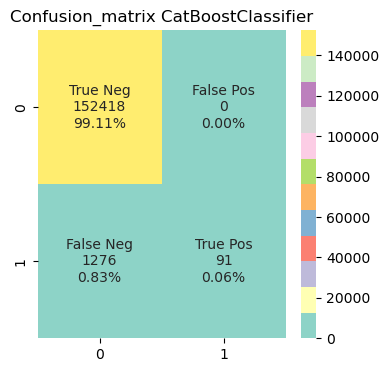

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    152418
           1       1.00      0.06      0.11      1367

    accuracy                           0.99    153785
   macro avg       1.00      0.53      0.55    153785
weighted avg       0.99      0.99      0.99    153785



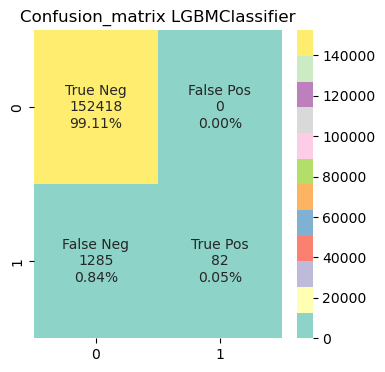

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    152418
           1       1.00      0.05      0.10      1367

    accuracy                           0.99    153785
   macro avg       1.00      0.53      0.55    153785
weighted avg       0.99      0.99      0.99    153785



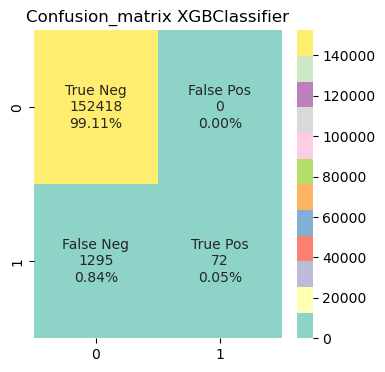

In [21]:
#получим метрики по всем моделям
list_metrics = []
for model in models:
    model.fit(features_train, target_train)
    show_metric(model, features_test, target_test)

In [22]:
pd.DataFrame(list_metrics, columns = ['model', 'roc_auc', 'gini', 'model_fit'])[['model', 'roc_auc', 'gini']]

model   roc_auc      gini
0  CatBoostClassifier  0.770274  0.540548
1      LGBMClassifier  0.768065  0.536130
2       XGBClassifier  0.762784  0.525568

Отлично, roc-auc увеличилась до 0,77, а gini до 0,54. Напоследок посмотрим, как изменилась важность признаков для модели.

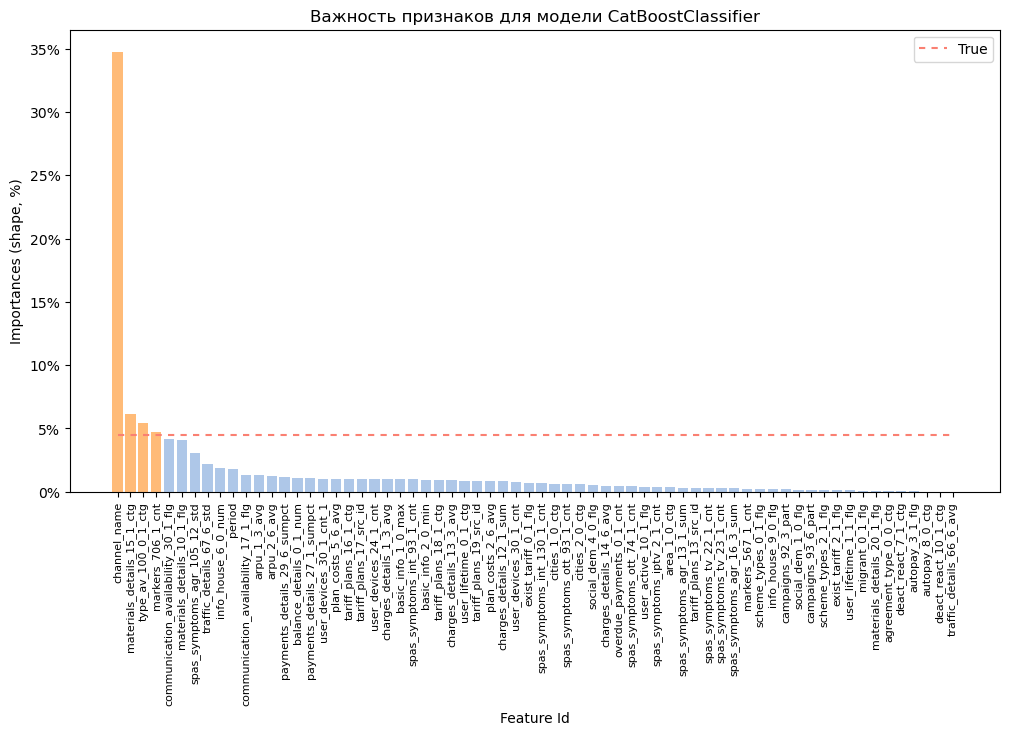

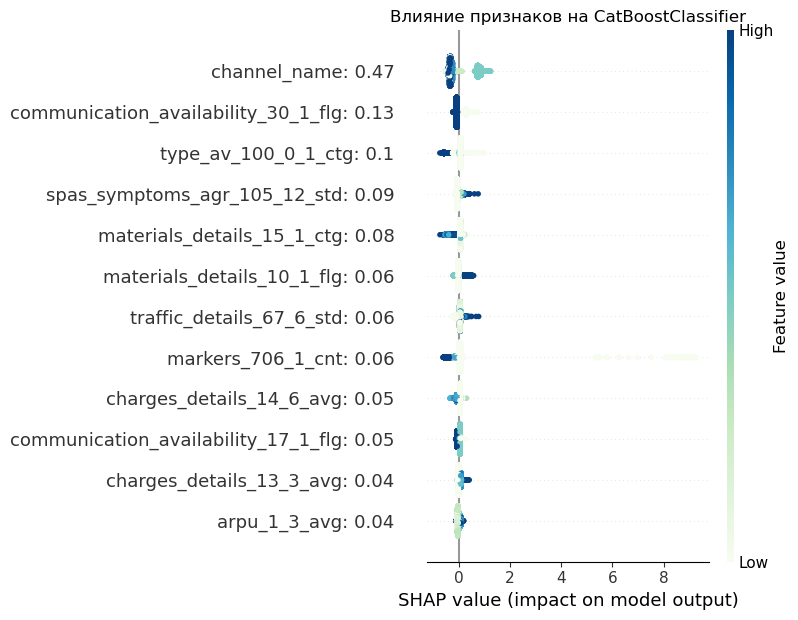

In [23]:
get_feature_importance(list_metrics[0][-1])

Экстремальные прогнозы мы сгладили, а для маркера 706 низкие значения увеличивают вероятность покупки - все логично.
Настало время сделать итоговый сабмит.

## Сабмит

In [24]:
test = test.fillna(test.median())

model = CatBoostClassifier(random_seed=RANDOM_SEED, eval_metric='AUC',metric_period=1000, learning_rate = 0.037, 
                       depth=5, l2_leaf_reg=9.337230928976561, min_data_in_leaf=6)
model.fit(features_train, target_train)
probabilities = model.predict_proba(test)[:,1]

0:	total: 27.3ms	remaining: 27.3s
999:	total: 23.7s	remaining: 0us


In [25]:
result = pd.DataFrame([test.index, probabilities]).T.rename(columns={0: 'id',1: 'target'})
result['id'] = result['id'].astype('int')
result = result.set_index('id')
result.to_csv(os.path.join(path, 'sample_submission_best.csv'), index=True)

Метрика roc-auc на тесте составила 0,6648.

## Выводы

Цель проекта - разработка модели склонности (бинарной классификации) к покупке клиентом оборудования после коммуникации с ним в одном из каналов
1. Датасет собран для случайного множества клиентов, и включал в себя более чем 2700 признаков. 
Выбор признаков для обучения был произведен с использованием методов, основанных на отборе по критерию хи-квадрат, измеряющим зависимость между случайными переменными - отсеиваются признаки, которые с наибольшой вероятностью не зависят от класса.
2. В качестве моделей были обучены:
- CatBoostClassifier
- LGBMClassifier
- XGBClassifier
3. С базовым набором признаков нам удалось получить значение площади под кривой, превышающей 0,76. Этот результат показала модель, обученная с помощью классификатора CatBoost, другие же хуже спрогнозировали вероятность положительного класса, что дало  чуть более низкий результат метрики. CatBoostClassifier продемонстрировал и самый высокий процент правильных ответов по единицам, в сравнении с остальными - разрыв получился значительный. 
Эта модель была принята как основная. 
4. По данным о распределении, зависимости, влияния и важности признаков, для классификатора CatBoost, был сформирован итоговый набор признаков. Часть данных была трансформирована для того, чтобы повысить качество предсказания модели. Все решения были приняты основываясь на анализе и оценке исходной информации и ее влияния на модель, рассчитанную с помощью инструментов snap.
5. Итоговая метрика на тесте составила 0,6648
6. Следует отметить, что часть преобразований для данных была сделана с учетом предоставленной информации, и по мере ее изменения и накопления, особенно в части данных по продажам, где присутствуют экстремальные значения, может потребоваться ее корректировка.  

